In [1]:
import os
import pandas as pd
import numpy as np
from skimage.measure import block_reduce
import time
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

autotune = tf.data.AUTOTUNE

In [2]:
image_sizes = {
    "cryptopunks": (32, 32),
    "cryptocorgis": (32, 32)
    }
batch_size = 32

In [3]:
def get_data(collection):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./%s"%collection,
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_sizes[collection],
        #batch_size=batch_size,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./%s"%collection,
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_sizes[collection],
        #batch_size=batch_size,
    )
    return train_ds, val_ds


train_ds, val_ds = get_data("cryptocorgis")

#Try removing this as well 
def process(image,label):
    #image = tf.cast((image - 127.5)/127.5 ,tf.float32)
    return image,label

train_ds = train_ds.map(process)

Found 8273 files belonging to 1 classes.
Using 6619 files for training.
Found 8273 files belonging to 1 classes.
Using 1654 files for validation.


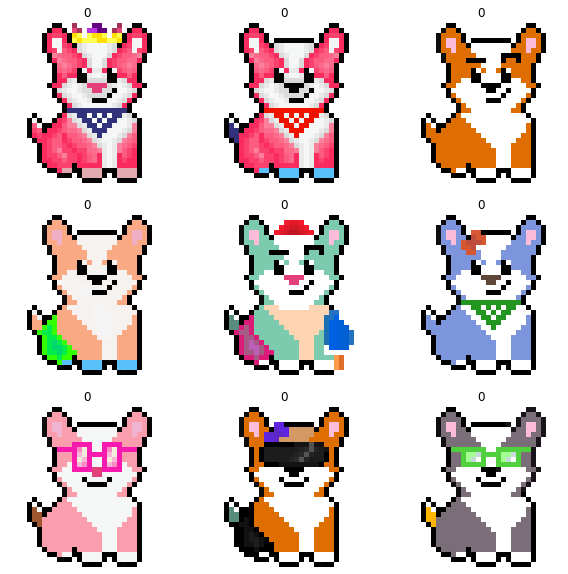

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy()).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [6]:
train_ds2, val_ds2 = get_data("cryptopunks")

train_ds2 = train_ds2.map(process)

Found 9999 files belonging to 1 classes.
Using 8000 files for training.
Found 9999 files belonging to 1 classes.
Using 1999 files for validation.


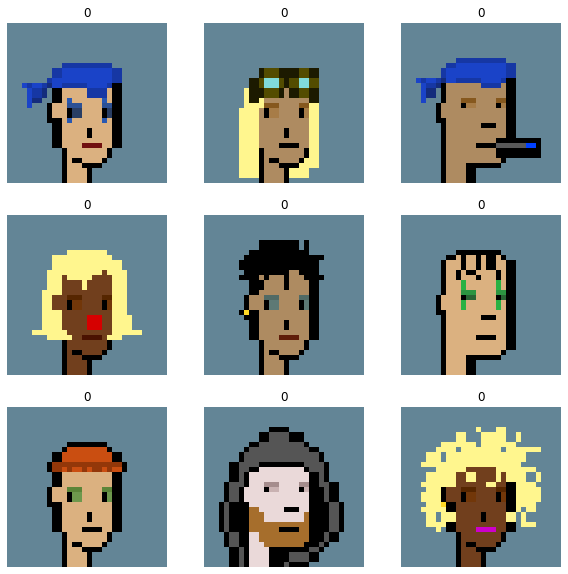

In [7]:
plt.figure(figsize=(10, 10))
for images2, labels2 in train_ds2.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images2[i].numpy()).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
train_ds2 = train_ds2.prefetch(buffer_size=32)
val_ds2 = val_ds2.prefetch(buffer_size=32)

In [9]:
# Define the standard image size.
orig_img_size = (32, 32)

# Size of the random crops to be used during training.
input_img_size = (32, 32, 3)

# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Define buffer and batch sizes
buffer_size = 256
batch_size = 1


def normalize_img(img):
    #img = tf.cast(img, dtype=tf.uint8)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

# This function is used to add variety to the dataset by randomly flipping and cropping the image
def preprocess_train_image_ds(img, labels_we_dont_care_about_nor_have):
    image = tf.cast(img, tf.float32)
    
    # Random flip
    image = tf.image.random_flip_left_right(image)

    # Resize to the original size first(1,256, 256, 3)
    image = tf.image.resize(image, [32,32])

    # Random crop to 256X256
    image = tf.image.random_crop(image, [1,32,32,3])

    # Normalize the pixel values in the range [-1, 1]
    image = normalize_img(image)

    # Reshape the image to a 32x32 RGB 
    image = tf.reshape(image,[32,32,3])
    return image


def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

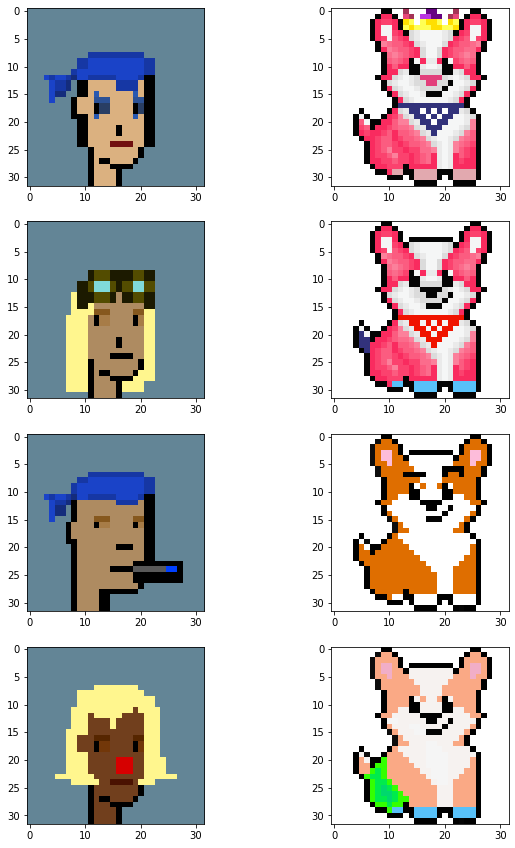

In [10]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_ds2.take(4), train_ds.take(4))):

    corgi = (images2[i].numpy()).astype("uint8")
    punk = (images[i].numpy()).astype("uint8")
    ax[i, 0].imshow(corgi)
    ax[i, 1].imshow(punk)
plt.show()

In [11]:
# Apply the preprocessing operations to the training data
train_ds = (
    train_ds.map(preprocess_train_image_ds, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)

)

In [12]:
train_ds2 = (
    train_ds2.map(preprocess_train_image_ds, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)

)

In [13]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [14]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [15]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [17]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(train_ds2.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "./generated_images2_200/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

In [18]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

Epoch 1/200
207/207 [==============================] - ETA: 0s - G_loss: 8.3070 - F_loss: 5.2721 - D_X_loss: 0.0529 - D_Y_loss: 0.0555

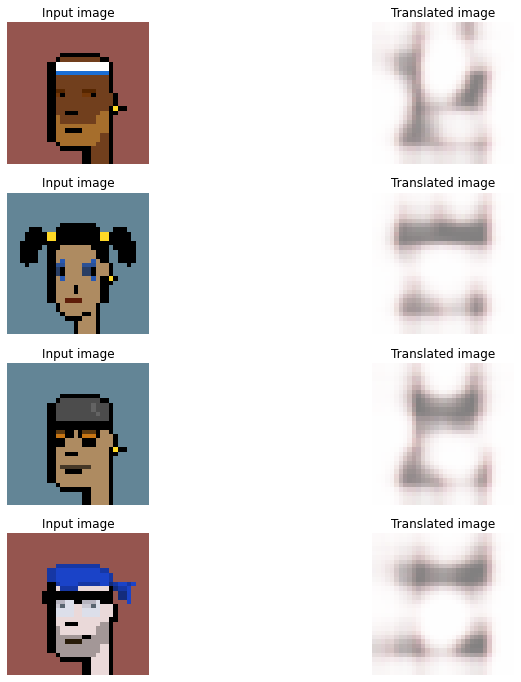

207/207 [==============================] - 141s 371ms/step - G_loss: 8.3049 - F_loss: 5.2708 - D_X_loss: 0.0527 - D_Y_loss: 0.0552
Epoch 2/200
207/207 [==============================] - ETA: 0s - G_loss: 6.8362 - F_loss: 4.9589 - D_X_loss: 0.0257 - D_Y_loss: 2.8631e-04

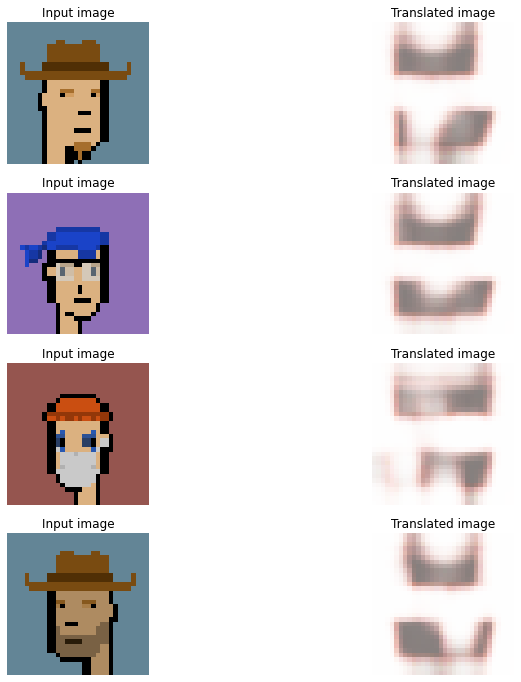

207/207 [==============================] - 78s 378ms/step - G_loss: 6.8322 - F_loss: 4.9560 - D_X_loss: 0.0267 - D_Y_loss: 2.8534e-04
Epoch 3/200
207/207 [==============================] - ETA: 0s - G_loss: 6.6122 - F_loss: 4.7738 - D_X_loss: 0.0502 - D_Y_loss: 1.4366e-04

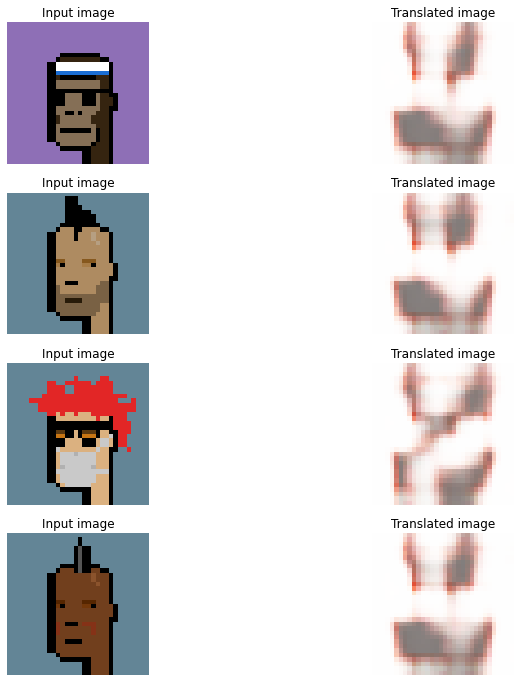

207/207 [==============================] - 77s 372ms/step - G_loss: 6.6231 - F_loss: 4.7701 - D_X_loss: 0.0500 - D_Y_loss: 1.4351e-04
Epoch 4/200
207/207 [==============================] - ETA: 0s - G_loss: 6.3869 - F_loss: 4.3784 - D_X_loss: 0.0829 - D_Y_loss: 1.1675e-04

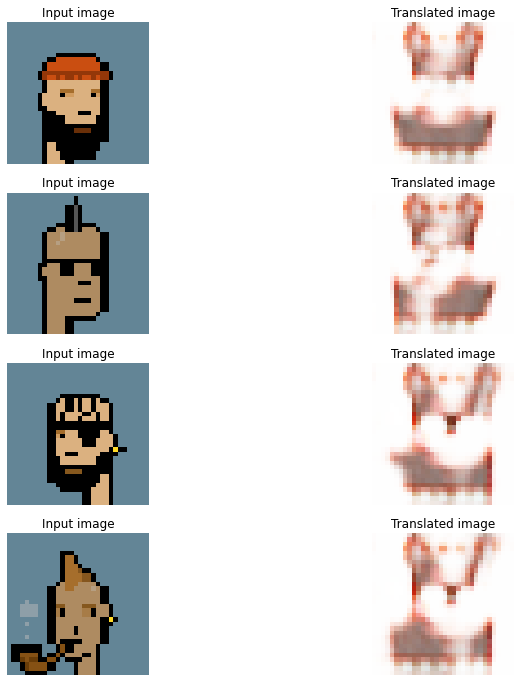

207/207 [==============================] - 77s 372ms/step - G_loss: 6.3896 - F_loss: 4.3737 - D_X_loss: 0.0825 - D_Y_loss: 1.1638e-04
Epoch 5/200
207/207 [==============================] - ETA: 0s - G_loss: 6.1504 - F_loss: 4.2074 - D_X_loss: 0.1101 - D_Y_loss: 0.0089

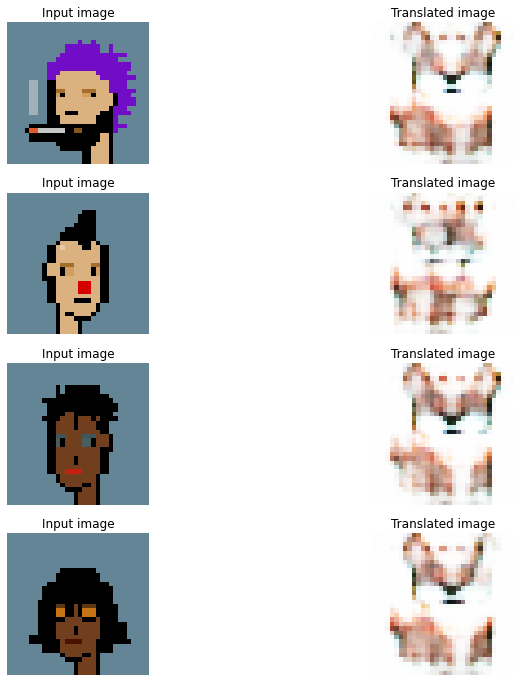

207/207 [==============================] - 76s 369ms/step - G_loss: 6.1456 - F_loss: 4.2085 - D_X_loss: 0.1100 - D_Y_loss: 0.0088
Epoch 6/200
207/207 [==============================] - ETA: 0s - G_loss: 5.5083 - F_loss: 4.4230 - D_X_loss: 0.1066 - D_Y_loss: 0.0696

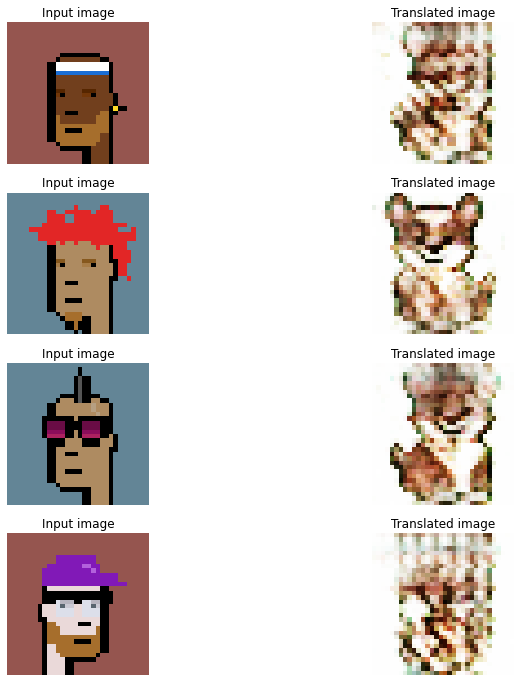

207/207 [==============================] - 76s 369ms/step - G_loss: 5.5073 - F_loss: 4.4127 - D_X_loss: 0.1066 - D_Y_loss: 0.0711
Epoch 7/200
207/207 [==============================] - ETA: 0s - G_loss: 4.6558 - F_loss: 4.0463 - D_X_loss: 0.1187 - D_Y_loss: 0.1034

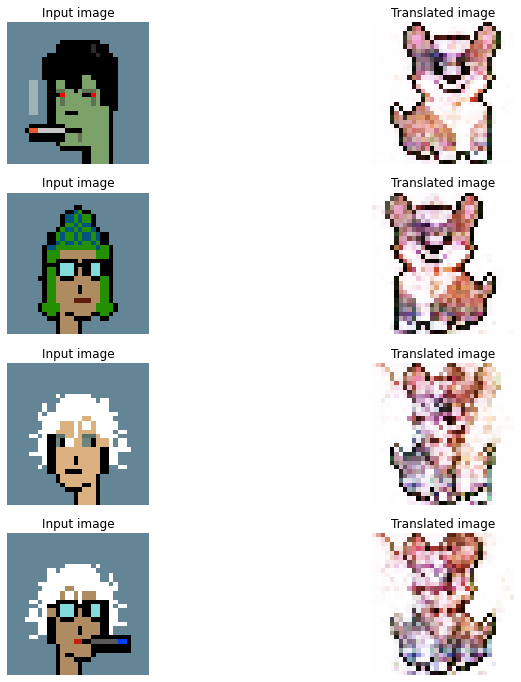

207/207 [==============================] - 75s 362ms/step - G_loss: 4.6547 - F_loss: 4.0442 - D_X_loss: 0.1185 - D_Y_loss: 0.1047
Epoch 8/200
207/207 [==============================] - ETA: 0s - G_loss: 4.0046 - F_loss: 4.0684 - D_X_loss: 0.1231 - D_Y_loss: 0.1822

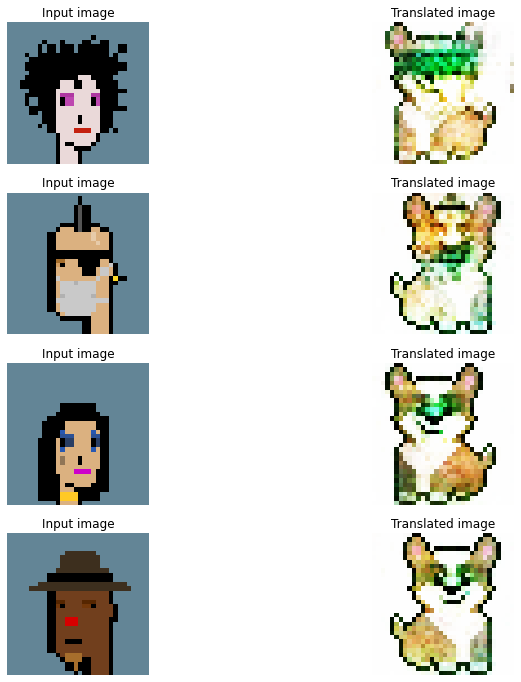

207/207 [==============================] - 74s 360ms/step - G_loss: 3.9997 - F_loss: 4.0707 - D_X_loss: 0.1231 - D_Y_loss: 0.1821
Epoch 9/200
207/207 [==============================] - ETA: 0s - G_loss: 3.9313 - F_loss: 3.9498 - D_X_loss: 0.1058 - D_Y_loss: 0.1684

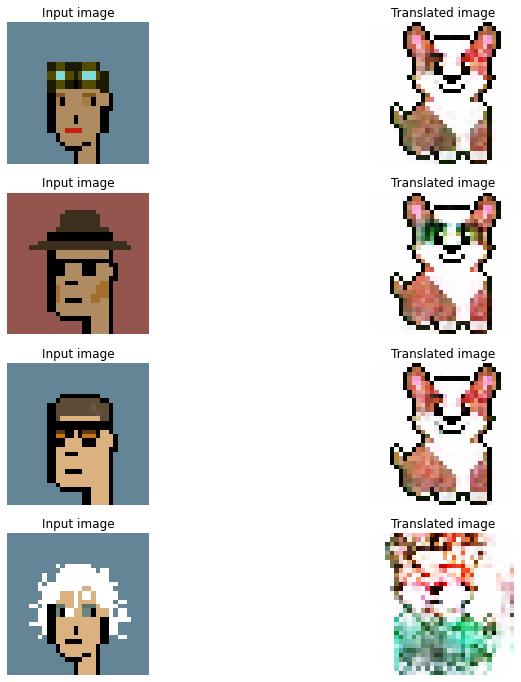

207/207 [==============================] - 71s 343ms/step - G_loss: 3.9298 - F_loss: 3.9435 - D_X_loss: 0.1062 - D_Y_loss: 0.1686
Epoch 10/200
207/207 [==============================] - ETA: 0s - G_loss: 3.9292 - F_loss: 4.0537 - D_X_loss: 0.0904 - D_Y_loss: 0.1572

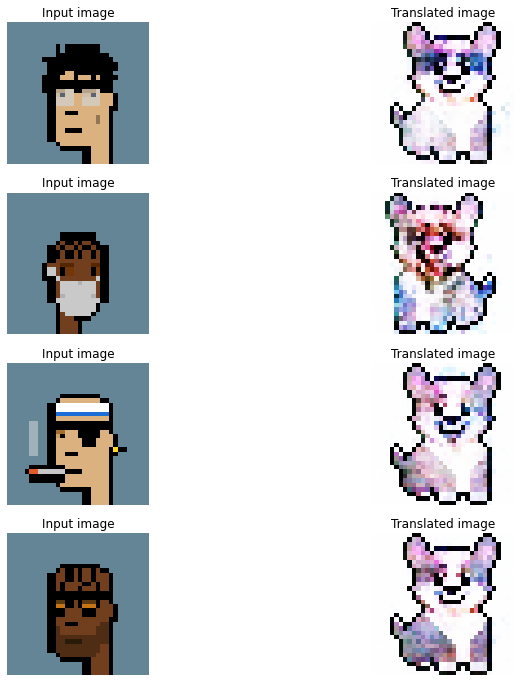

207/207 [==============================] - 74s 358ms/step - G_loss: 3.9254 - F_loss: 4.0521 - D_X_loss: 0.0902 - D_Y_loss: 0.1568
Epoch 11/200
207/207 [==============================] - ETA: 0s - G_loss: 3.8460 - F_loss: 3.9294 - D_X_loss: 0.0903 - D_Y_loss: 0.1359

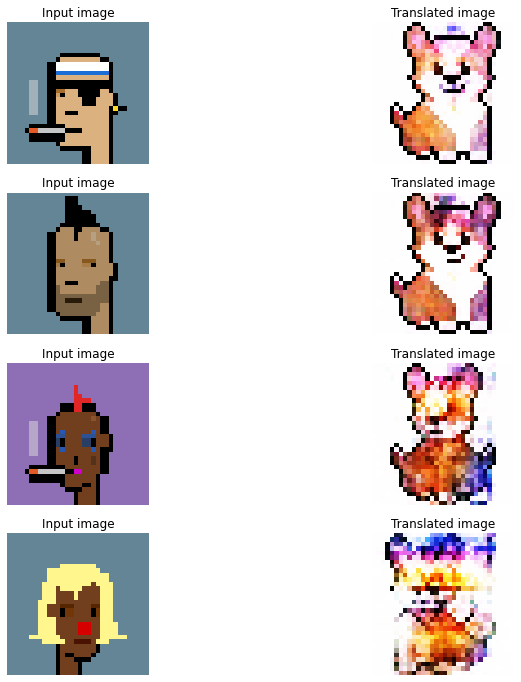

207/207 [==============================] - 71s 343ms/step - G_loss: 3.8556 - F_loss: 3.9265 - D_X_loss: 0.0902 - D_Y_loss: 0.1355
Epoch 12/200
207/207 [==============================] - ETA: 0s - G_loss: 3.8020 - F_loss: 3.7390 - D_X_loss: 0.0969 - D_Y_loss: 0.1426

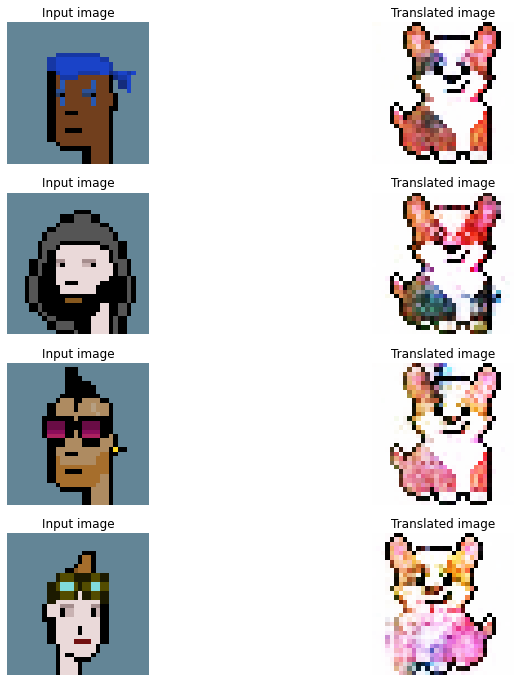

207/207 [==============================] - 71s 343ms/step - G_loss: 3.8092 - F_loss: 3.7501 - D_X_loss: 0.0966 - D_Y_loss: 0.1420
Epoch 13/200
207/207 [==============================] - ETA: 0s - G_loss: 3.8505 - F_loss: 3.7937 - D_X_loss: 0.0893 - D_Y_loss: 0.1313

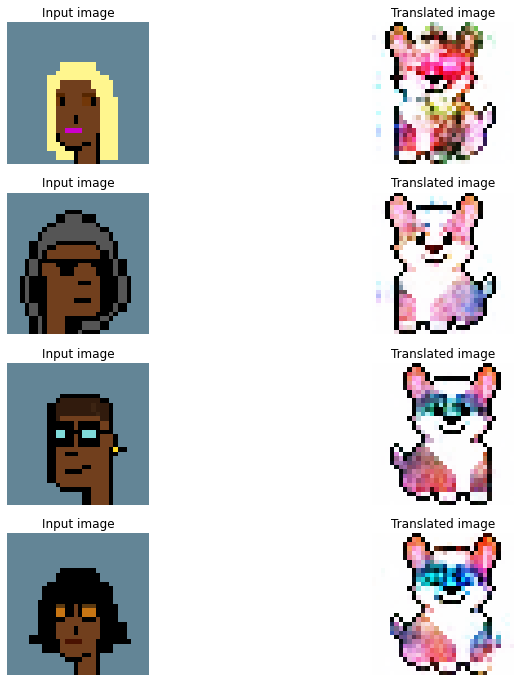

207/207 [==============================] - 71s 344ms/step - G_loss: 3.8451 - F_loss: 3.7887 - D_X_loss: 0.0889 - D_Y_loss: 0.1308
Epoch 14/200
207/207 [==============================] - ETA: 0s - G_loss: 3.8670 - F_loss: 3.7066 - D_X_loss: 0.0728 - D_Y_loss: 0.1268

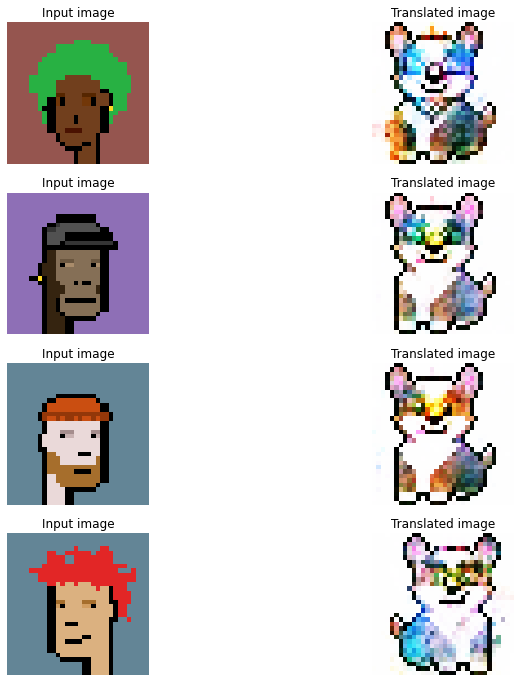

207/207 [==============================] - 71s 344ms/step - G_loss: 3.8696 - F_loss: 3.7059 - D_X_loss: 0.0725 - D_Y_loss: 0.1263
Epoch 15/200
207/207 [==============================] - ETA: 0s - G_loss: 3.6879 - F_loss: 3.5846 - D_X_loss: 0.0829 - D_Y_loss: 0.1230

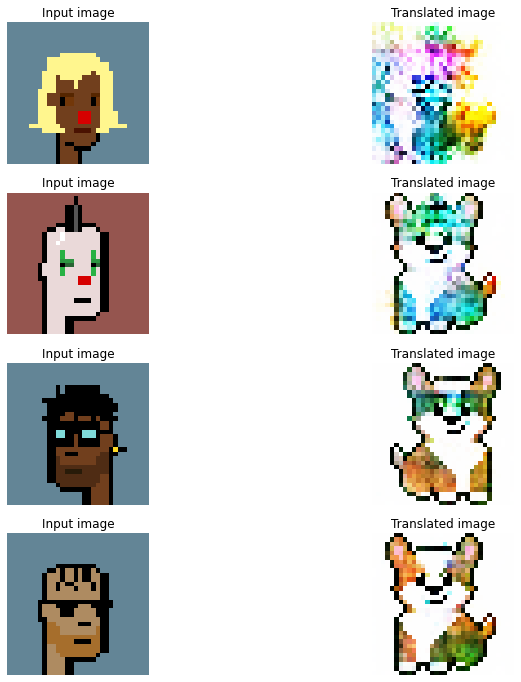

207/207 [==============================] - 71s 343ms/step - G_loss: 3.6942 - F_loss: 3.5824 - D_X_loss: 0.0825 - D_Y_loss: 0.1225
Epoch 16/200
207/207 [==============================] - ETA: 0s - G_loss: 3.7028 - F_loss: 3.5901 - D_X_loss: 0.0757 - D_Y_loss: 0.1181

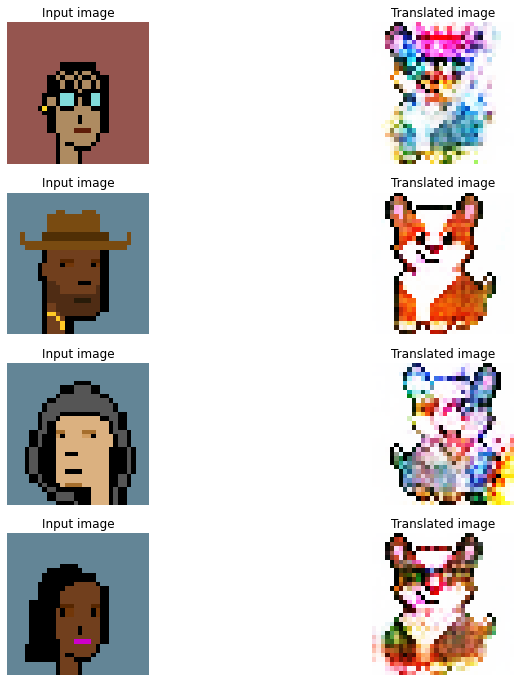

207/207 [==============================] - 71s 343ms/step - G_loss: 3.7053 - F_loss: 3.5895 - D_X_loss: 0.0753 - D_Y_loss: 0.1181
Epoch 17/200
207/207 [==============================] - ETA: 0s - G_loss: 3.6448 - F_loss: 3.5524 - D_X_loss: 0.0797 - D_Y_loss: 0.1189

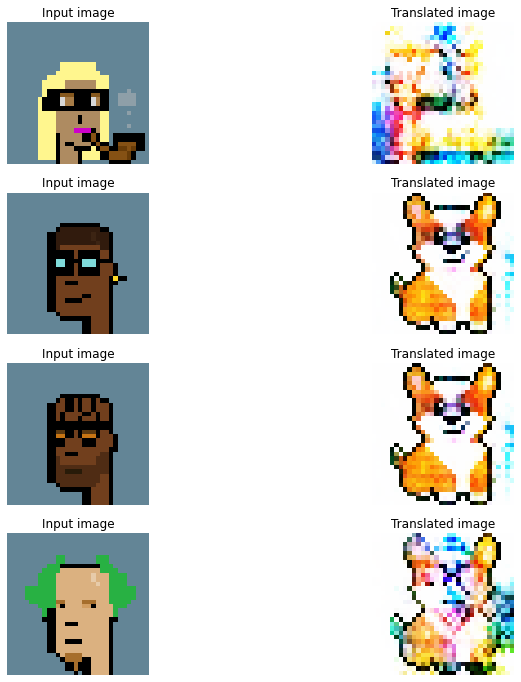

207/207 [==============================] - 71s 344ms/step - G_loss: 3.6418 - F_loss: 3.5484 - D_X_loss: 0.0794 - D_Y_loss: 0.1183
Epoch 18/200
207/207 [==============================] - ETA: 0s - G_loss: 3.4962 - F_loss: 3.4922 - D_X_loss: 0.0780 - D_Y_loss: 0.1330

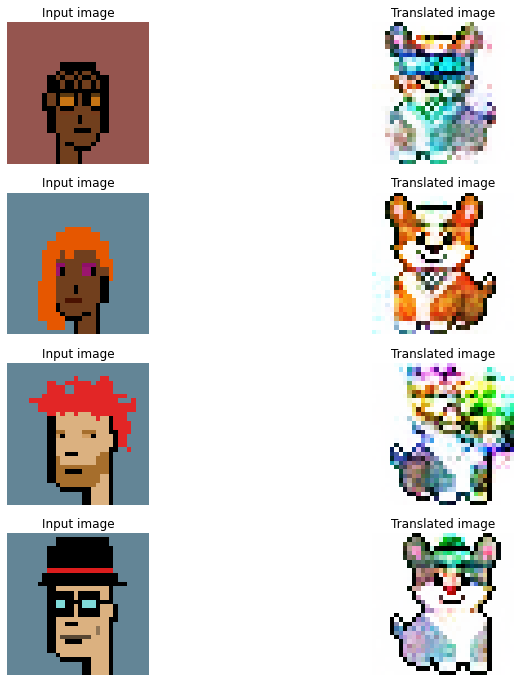

207/207 [==============================] - 71s 342ms/step - G_loss: 3.4942 - F_loss: 3.4832 - D_X_loss: 0.0788 - D_Y_loss: 0.1338
Epoch 19/200
207/207 [==============================] - ETA: 0s - G_loss: 3.4501 - F_loss: 3.4387 - D_X_loss: 0.0693 - D_Y_loss: 0.1322

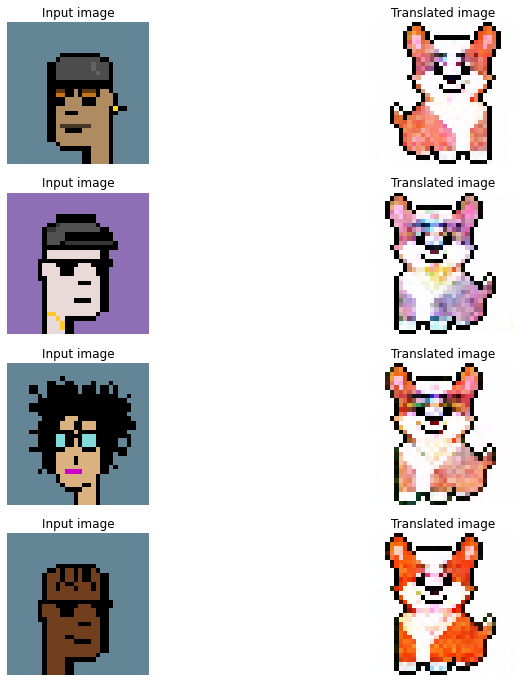

207/207 [==============================] - 71s 343ms/step - G_loss: 3.4566 - F_loss: 3.4483 - D_X_loss: 0.0691 - D_Y_loss: 0.1318
Epoch 20/200
207/207 [==============================] - ETA: 0s - G_loss: 3.4200 - F_loss: 3.2831 - D_X_loss: 0.0582 - D_Y_loss: 0.1198

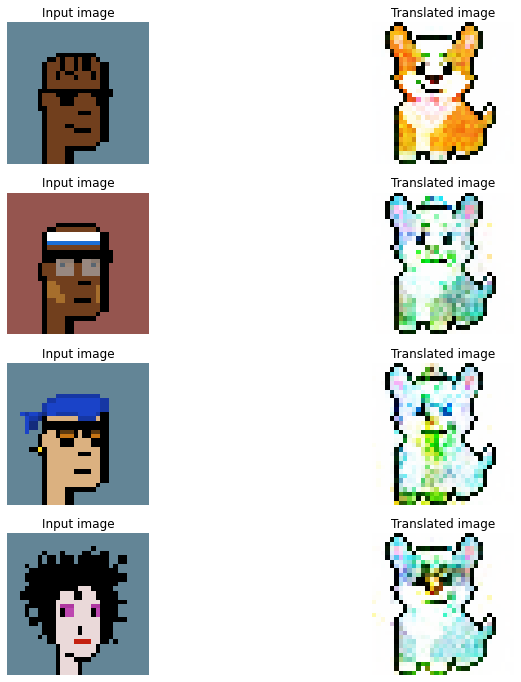

207/207 [==============================] - 71s 344ms/step - G_loss: 3.4242 - F_loss: 3.2775 - D_X_loss: 0.0582 - D_Y_loss: 0.1195
Epoch 21/200
207/207 [==============================] - ETA: 0s - G_loss: 3.3933 - F_loss: 3.4059 - D_X_loss: 0.0732 - D_Y_loss: 0.1206

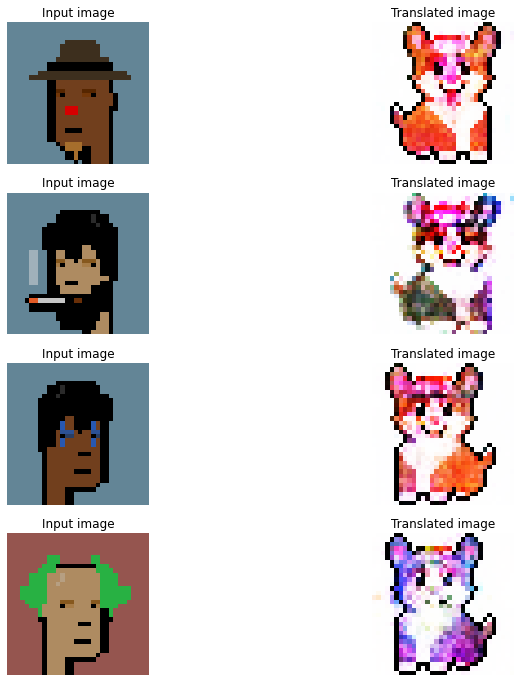

207/207 [==============================] - 71s 343ms/step - G_loss: 3.3954 - F_loss: 3.3960 - D_X_loss: 0.0744 - D_Y_loss: 0.1201
Epoch 22/200
207/207 [==============================] - ETA: 0s - G_loss: 3.4056 - F_loss: 3.3232 - D_X_loss: 0.0825 - D_Y_loss: 0.1231

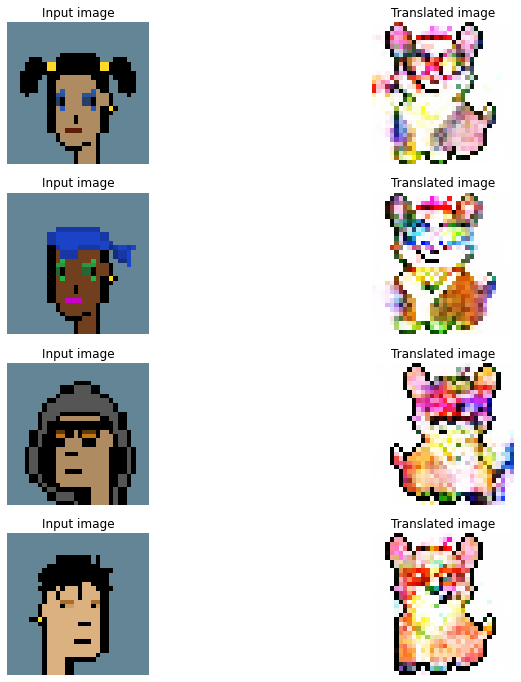

207/207 [==============================] - 71s 344ms/step - G_loss: 3.4147 - F_loss: 3.3210 - D_X_loss: 0.0822 - D_Y_loss: 0.1228
Epoch 23/200
207/207 [==============================] - ETA: 0s - G_loss: 3.3767 - F_loss: 3.3185 - D_X_loss: 0.0723 - D_Y_loss: 0.1155

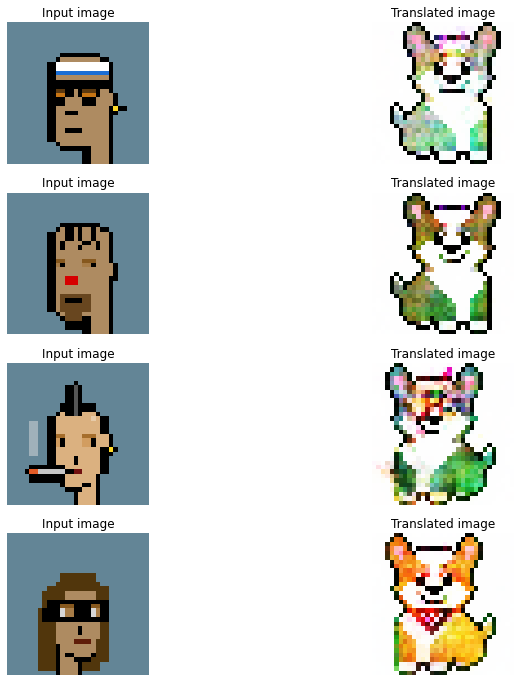

207/207 [==============================] - 71s 342ms/step - G_loss: 3.3815 - F_loss: 3.3077 - D_X_loss: 0.0740 - D_Y_loss: 0.1159
Epoch 24/200
207/207 [==============================] - ETA: 0s - G_loss: 3.3184 - F_loss: 3.3659 - D_X_loss: 0.0614 - D_Y_loss: 0.1103

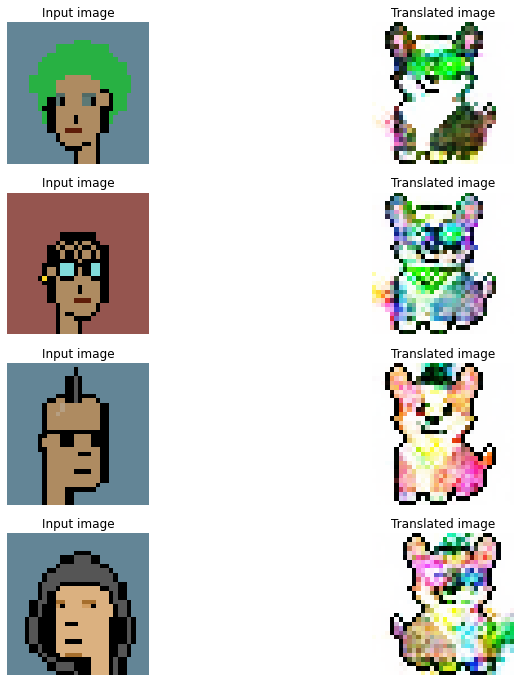

207/207 [==============================] - 71s 341ms/step - G_loss: 3.3181 - F_loss: 3.3589 - D_X_loss: 0.0612 - D_Y_loss: 0.1124
Epoch 25/200
207/207 [==============================] - ETA: 0s - G_loss: 3.2663 - F_loss: 3.2885 - D_X_loss: 0.0694 - D_Y_loss: 0.1100

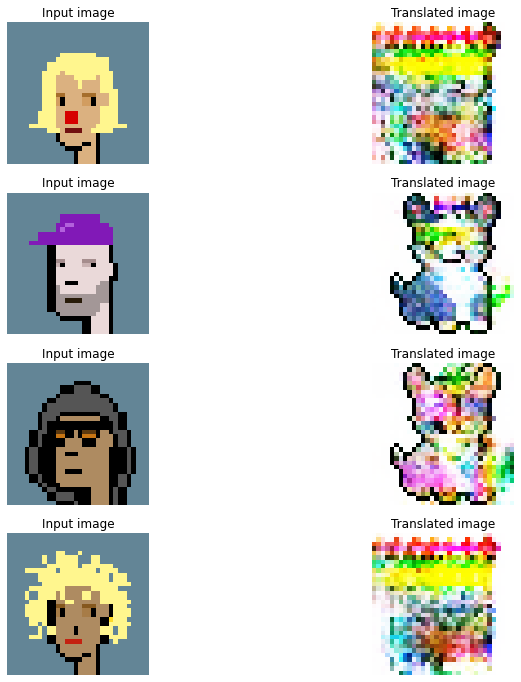

207/207 [==============================] - 71s 342ms/step - G_loss: 3.2722 - F_loss: 3.2857 - D_X_loss: 0.0691 - D_Y_loss: 0.1097
Epoch 26/200
207/207 [==============================] - ETA: 0s - G_loss: 3.3268 - F_loss: 3.2641 - D_X_loss: 0.0839 - D_Y_loss: 0.1156

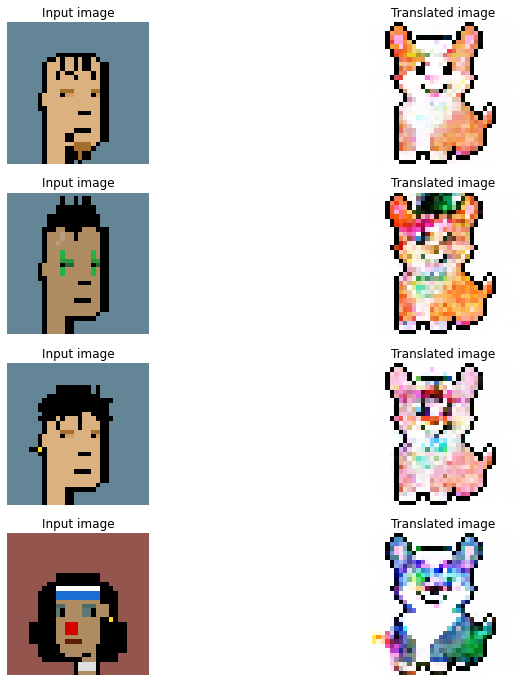

207/207 [==============================] - 71s 341ms/step - G_loss: 3.3230 - F_loss: 3.2782 - D_X_loss: 0.0839 - D_Y_loss: 0.1170
Epoch 27/200
207/207 [==============================] - ETA: 0s - G_loss: 3.2739 - F_loss: 3.2124 - D_X_loss: 0.0777 - D_Y_loss: 0.1073

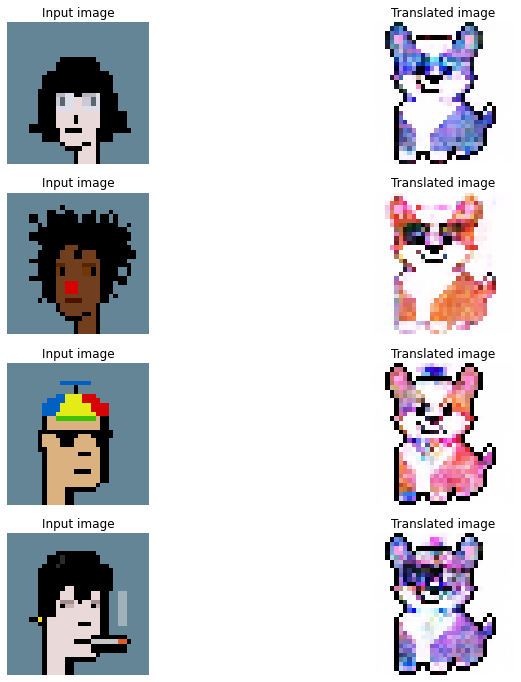

207/207 [==============================] - 71s 341ms/step - G_loss: 3.2775 - F_loss: 3.2130 - D_X_loss: 0.0773 - D_Y_loss: 0.1069
Epoch 28/200
207/207 [==============================] - ETA: 0s - G_loss: 3.2369 - F_loss: 3.1254 - D_X_loss: 0.0749 - D_Y_loss: 0.1068

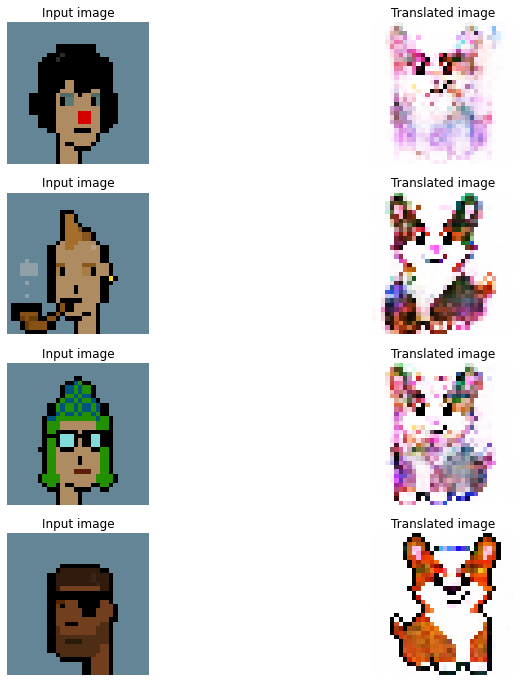

207/207 [==============================] - 70s 340ms/step - G_loss: 3.2409 - F_loss: 3.1361 - D_X_loss: 0.0746 - D_Y_loss: 0.1064
Epoch 29/200
207/207 [==============================] - ETA: 0s - G_loss: 3.2202 - F_loss: 3.3349 - D_X_loss: 0.0716 - D_Y_loss: 0.1138

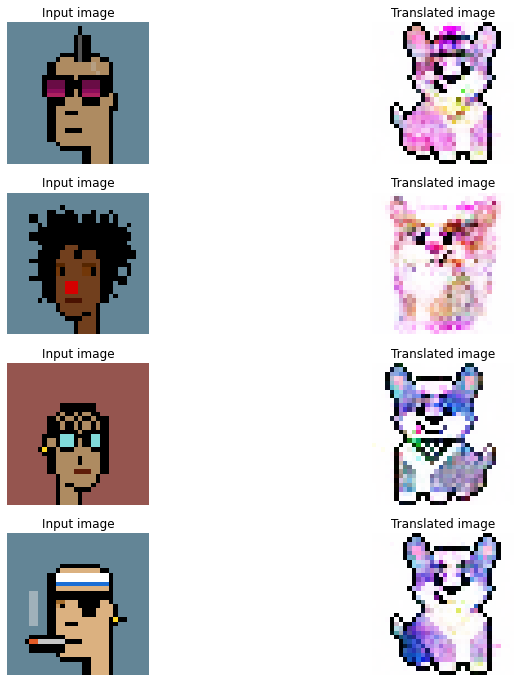

207/207 [==============================] - 70s 339ms/step - G_loss: 3.2213 - F_loss: 3.3386 - D_X_loss: 0.0717 - D_Y_loss: 0.1134
Epoch 30/200
207/207 [==============================] - ETA: 0s - G_loss: 3.1083 - F_loss: 3.1426 - D_X_loss: 0.0769 - D_Y_loss: 0.1149

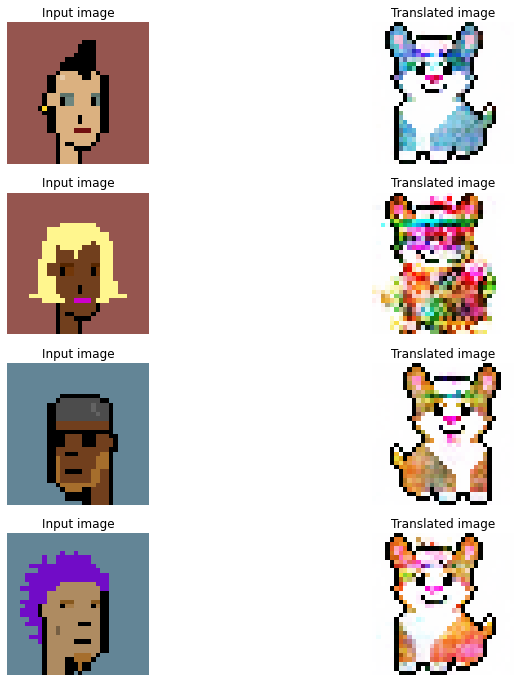

207/207 [==============================] - 70s 339ms/step - G_loss: 3.1109 - F_loss: 3.1391 - D_X_loss: 0.0767 - D_Y_loss: 0.1145
Epoch 31/200
207/207 [==============================] - ETA: 0s - G_loss: 3.1427 - F_loss: 3.1122 - D_X_loss: 0.0885 - D_Y_loss: 0.1052

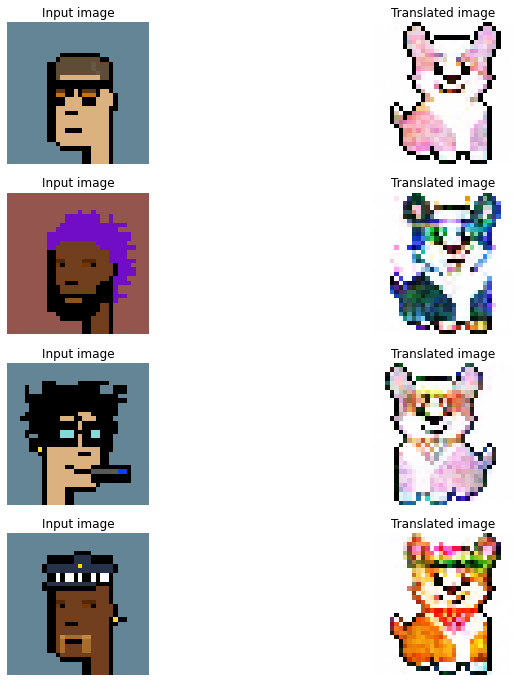

207/207 [==============================] - 70s 339ms/step - G_loss: 3.1403 - F_loss: 3.1071 - D_X_loss: 0.0881 - D_Y_loss: 0.1048
Epoch 32/200
207/207 [==============================] - ETA: 0s - G_loss: 3.1092 - F_loss: 2.9508 - D_X_loss: 0.0964 - D_Y_loss: 0.1067

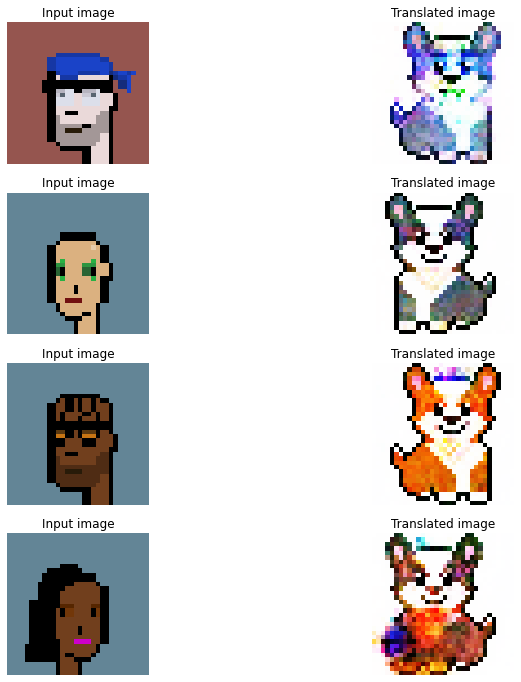

207/207 [==============================] - 70s 339ms/step - G_loss: 3.1164 - F_loss: 2.9491 - D_X_loss: 0.0969 - D_Y_loss: 0.1063
Epoch 33/200
207/207 [==============================] - ETA: 0s - G_loss: 3.1166 - F_loss: 2.9942 - D_X_loss: 0.0745 - D_Y_loss: 0.0969

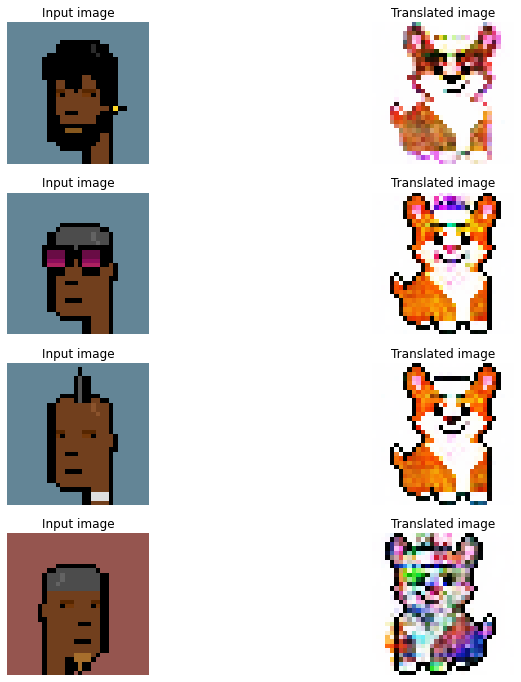

207/207 [==============================] - 70s 339ms/step - G_loss: 3.1126 - F_loss: 2.9886 - D_X_loss: 0.0743 - D_Y_loss: 0.0966
Epoch 34/200
207/207 [==============================] - ETA: 0s - G_loss: 3.0784 - F_loss: 2.9547 - D_X_loss: 0.0924 - D_Y_loss: 0.1137

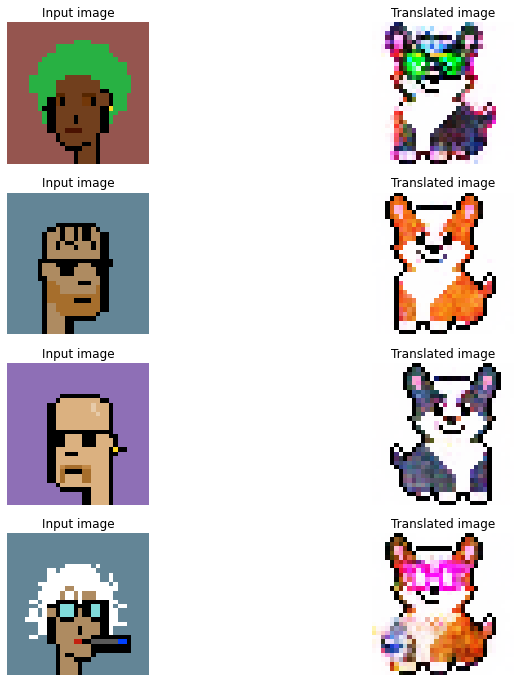

207/207 [==============================] - 70s 340ms/step - G_loss: 3.0753 - F_loss: 2.9558 - D_X_loss: 0.0923 - D_Y_loss: 0.1136
Epoch 35/200
207/207 [==============================] - ETA: 0s - G_loss: 3.0022 - F_loss: 2.7862 - D_X_loss: 0.0992 - D_Y_loss: 0.1044

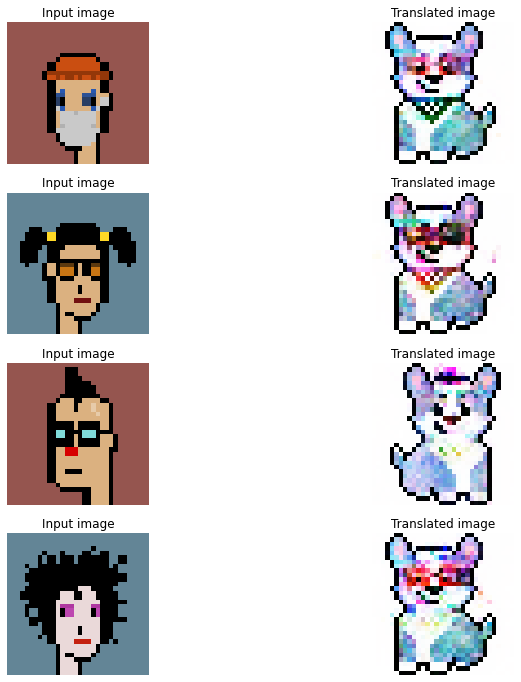

207/207 [==============================] - 70s 340ms/step - G_loss: 2.9974 - F_loss: 2.7890 - D_X_loss: 0.0987 - D_Y_loss: 0.1043
Epoch 36/200
207/207 [==============================] - ETA: 0s - G_loss: 2.9909 - F_loss: 2.8718 - D_X_loss: 0.0968 - D_Y_loss: 0.0949

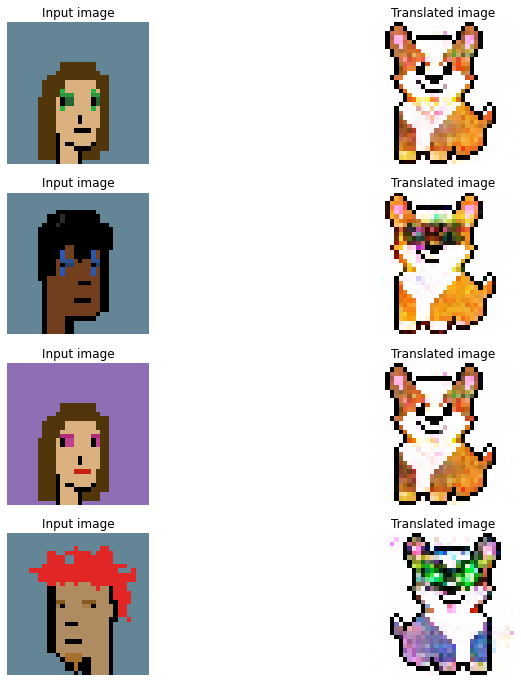

207/207 [==============================] - 70s 339ms/step - G_loss: 2.9953 - F_loss: 2.8780 - D_X_loss: 0.0969 - D_Y_loss: 0.0947
Epoch 37/200
207/207 [==============================] - ETA: 0s - G_loss: 3.0436 - F_loss: 2.7300 - D_X_loss: 0.0968 - D_Y_loss: 0.0988

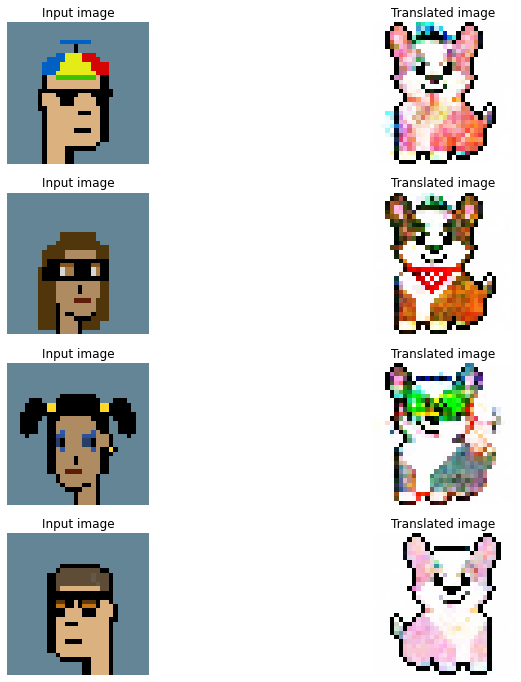

207/207 [==============================] - 71s 341ms/step - G_loss: 3.0362 - F_loss: 2.7363 - D_X_loss: 0.0964 - D_Y_loss: 0.0991
Epoch 38/200
207/207 [==============================] - ETA: 0s - G_loss: 2.9441 - F_loss: 2.7722 - D_X_loss: 0.0834 - D_Y_loss: 0.0984

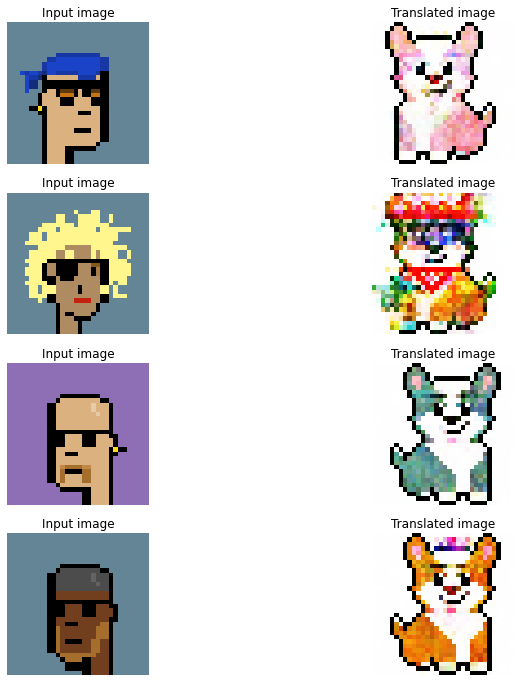

207/207 [==============================] - 71s 342ms/step - G_loss: 2.9439 - F_loss: 2.7689 - D_X_loss: 0.0830 - D_Y_loss: 0.0983
Epoch 39/200
207/207 [==============================] - ETA: 0s - G_loss: 3.0484 - F_loss: 2.7021 - D_X_loss: 0.0921 - D_Y_loss: 0.0890

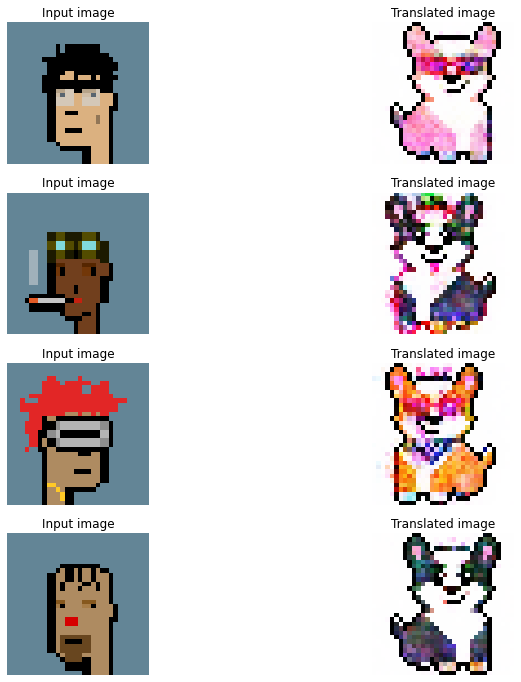

207/207 [==============================] - 71s 342ms/step - G_loss: 3.0505 - F_loss: 2.7109 - D_X_loss: 0.0919 - D_Y_loss: 0.0891
Epoch 40/200
207/207 [==============================] - ETA: 0s - G_loss: 2.9735 - F_loss: 2.7085 - D_X_loss: 0.1020 - D_Y_loss: 0.0971

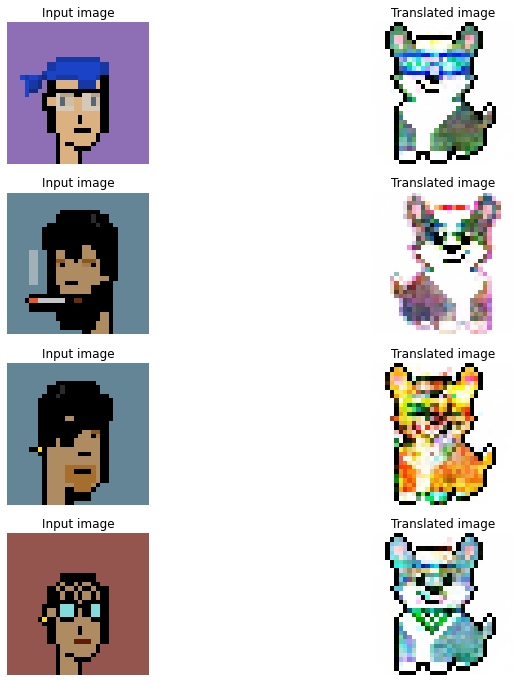

207/207 [==============================] - 71s 341ms/step - G_loss: 2.9755 - F_loss: 2.7047 - D_X_loss: 0.1029 - D_Y_loss: 0.0967
Epoch 41/200
207/207 [==============================] - ETA: 0s - G_loss: 2.9352 - F_loss: 2.7263 - D_X_loss: 0.0974 - D_Y_loss: 0.1031

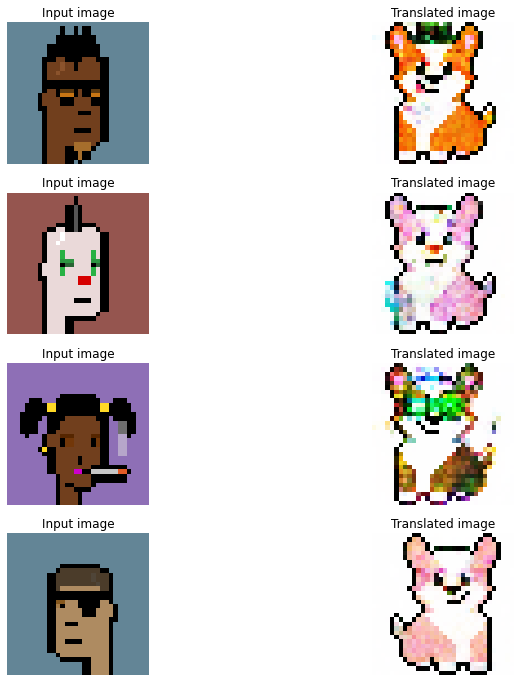

207/207 [==============================] - 71s 341ms/step - G_loss: 2.9363 - F_loss: 2.7297 - D_X_loss: 0.0972 - D_Y_loss: 0.1027
Epoch 42/200
207/207 [==============================] - ETA: 0s - G_loss: 2.8897 - F_loss: 2.7657 - D_X_loss: 0.0946 - D_Y_loss: 0.0938

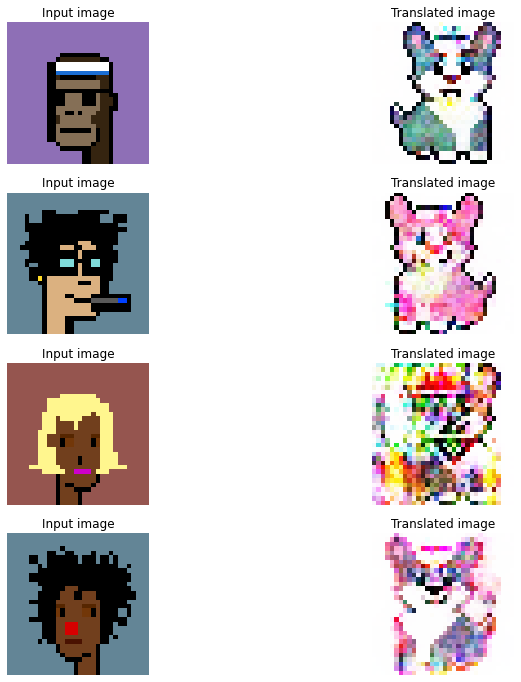

207/207 [==============================] - 70s 340ms/step - G_loss: 2.8913 - F_loss: 2.7652 - D_X_loss: 0.0942 - D_Y_loss: 0.0934
Epoch 43/200
207/207 [==============================] - ETA: 0s - G_loss: 2.9160 - F_loss: 2.7010 - D_X_loss: 0.0975 - D_Y_loss: 0.0975

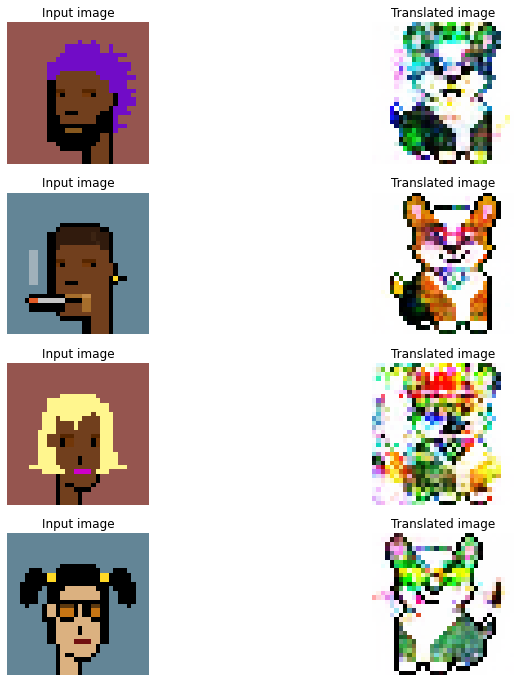

207/207 [==============================] - 70s 340ms/step - G_loss: 2.9100 - F_loss: 2.6964 - D_X_loss: 0.0986 - D_Y_loss: 0.0983
Epoch 44/200
207/207 [==============================] - ETA: 0s - G_loss: 2.9151 - F_loss: 2.5861 - D_X_loss: 0.0943 - D_Y_loss: 0.0958

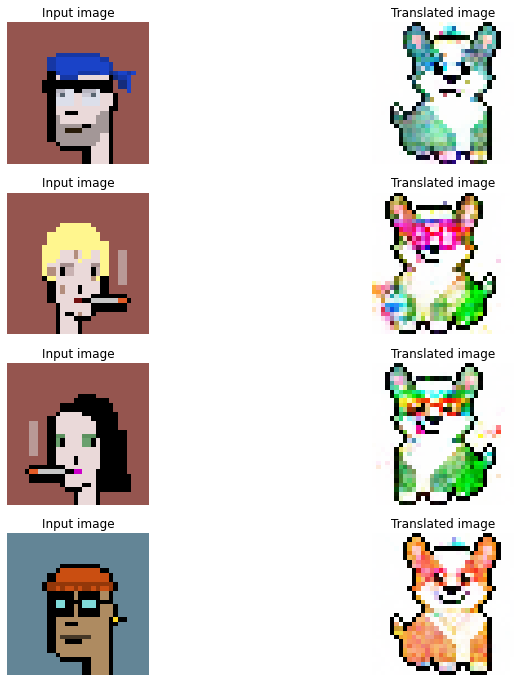

207/207 [==============================] - 70s 340ms/step - G_loss: 2.9163 - F_loss: 2.5842 - D_X_loss: 0.0940 - D_Y_loss: 0.0954
Epoch 45/200
207/207 [==============================] - ETA: 0s - G_loss: 2.8556 - F_loss: 2.6307 - D_X_loss: 0.0967 - D_Y_loss: 0.0889

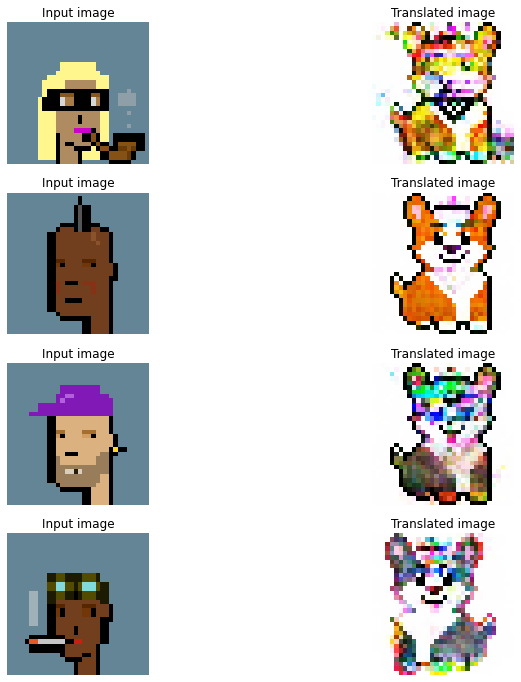

207/207 [==============================] - 70s 340ms/step - G_loss: 2.8508 - F_loss: 2.6334 - D_X_loss: 0.0969 - D_Y_loss: 0.0886
Epoch 46/200
207/207 [==============================] - ETA: 0s - G_loss: 2.8267 - F_loss: 2.6093 - D_X_loss: 0.1031 - D_Y_loss: 0.0880

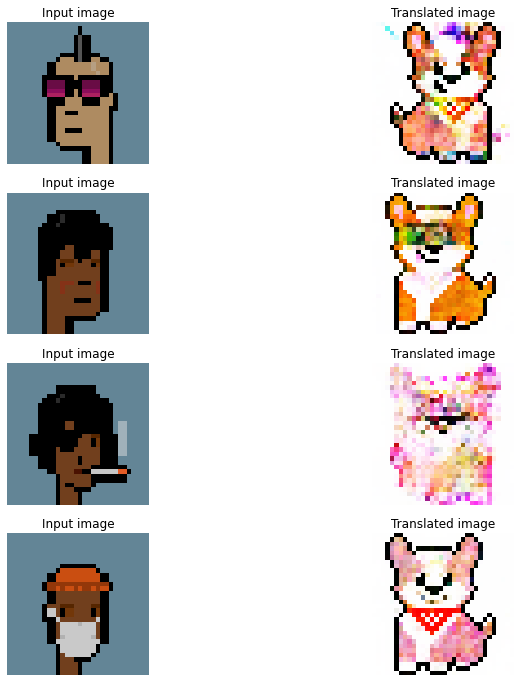

207/207 [==============================] - 70s 339ms/step - G_loss: 2.8264 - F_loss: 2.6064 - D_X_loss: 0.1027 - D_Y_loss: 0.0878
Epoch 47/200
207/207 [==============================] - ETA: 0s - G_loss: 2.8322 - F_loss: 2.7129 - D_X_loss: 0.0973 - D_Y_loss: 0.0894

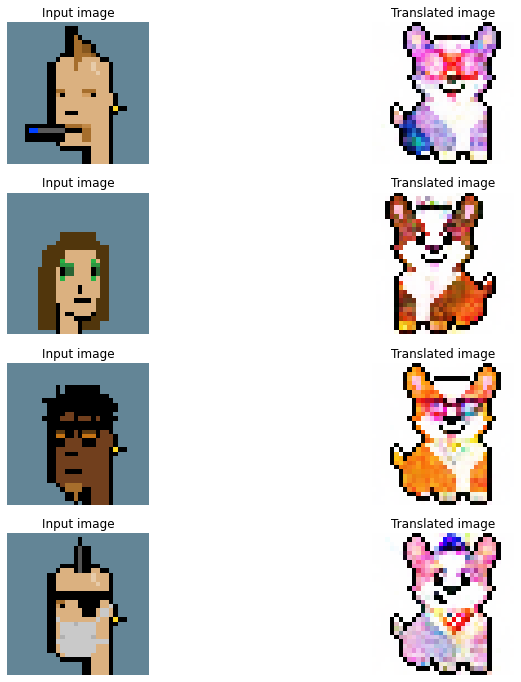

207/207 [==============================] - 70s 339ms/step - G_loss: 2.8329 - F_loss: 2.7111 - D_X_loss: 0.0980 - D_Y_loss: 0.0890
Epoch 48/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7975 - F_loss: 2.5282 - D_X_loss: 0.0927 - D_Y_loss: 0.0913

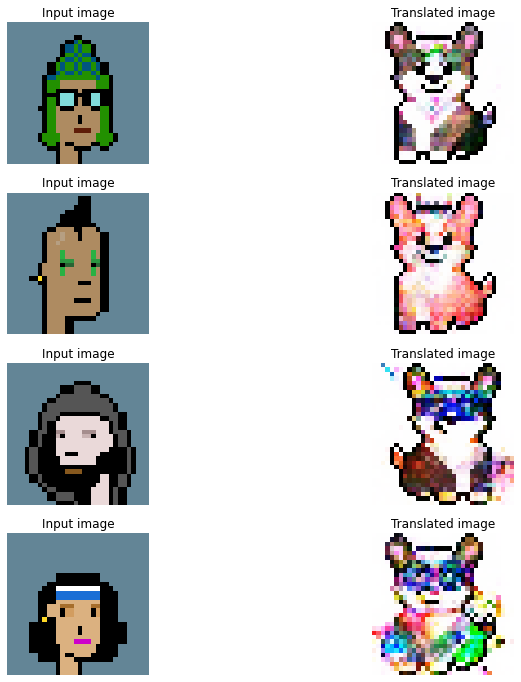

207/207 [==============================] - 70s 339ms/step - G_loss: 2.7969 - F_loss: 2.5260 - D_X_loss: 0.0925 - D_Y_loss: 0.0913
Epoch 49/200
207/207 [==============================] - ETA: 0s - G_loss: 2.8321 - F_loss: 2.5011 - D_X_loss: 0.1010 - D_Y_loss: 0.0888

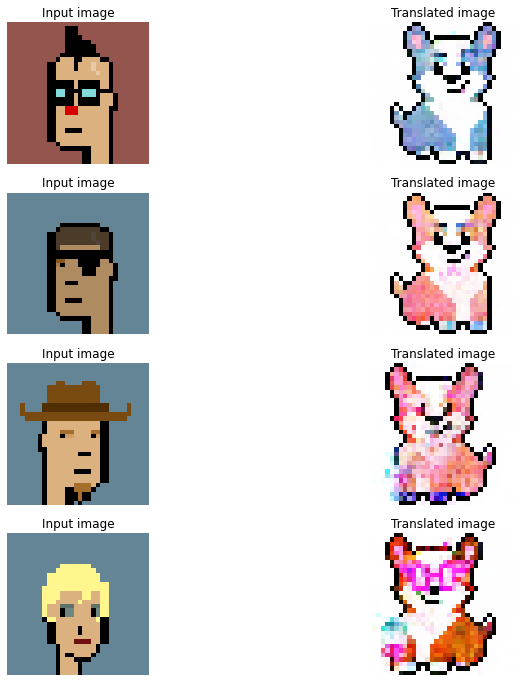

207/207 [==============================] - 70s 340ms/step - G_loss: 2.8328 - F_loss: 2.4954 - D_X_loss: 0.1022 - D_Y_loss: 0.0885
Epoch 50/200
207/207 [==============================] - ETA: 0s - G_loss: 2.8199 - F_loss: 2.6708 - D_X_loss: 0.0935 - D_Y_loss: 0.0958

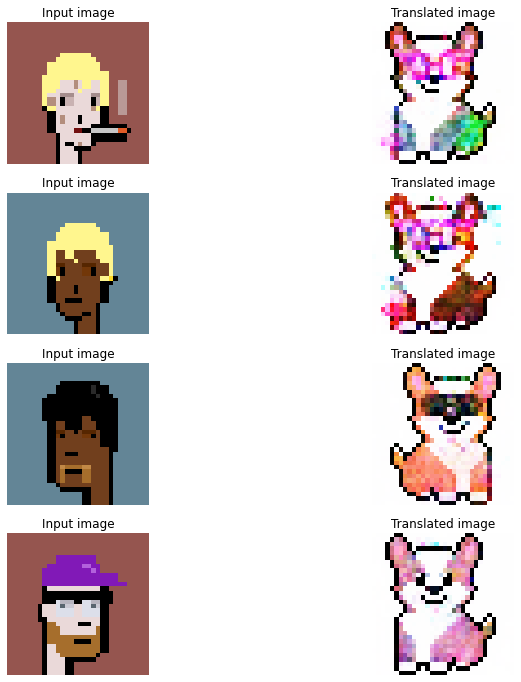

207/207 [==============================] - 71s 341ms/step - G_loss: 2.8176 - F_loss: 2.6703 - D_X_loss: 0.0933 - D_Y_loss: 0.0955
Epoch 51/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7718 - F_loss: 2.6107 - D_X_loss: 0.0846 - D_Y_loss: 0.0867

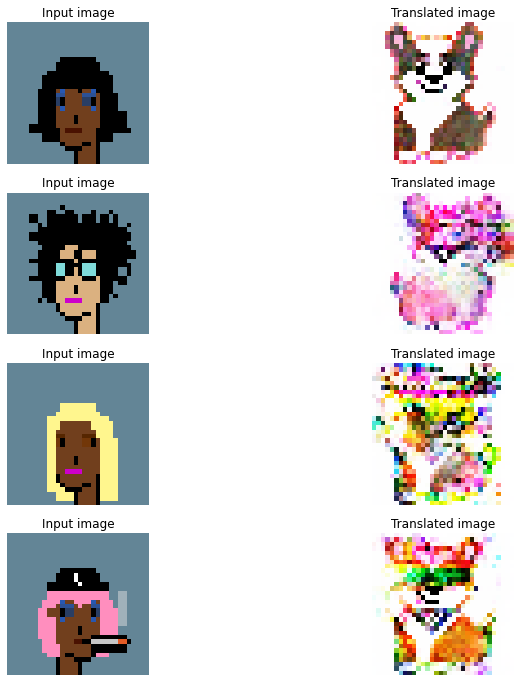

207/207 [==============================] - 71s 341ms/step - G_loss: 2.7696 - F_loss: 2.6134 - D_X_loss: 0.0844 - D_Y_loss: 0.0883
Epoch 52/200
207/207 [==============================] - ETA: 0s - G_loss: 2.8083 - F_loss: 2.6838 - D_X_loss: 0.0919 - D_Y_loss: 0.0915

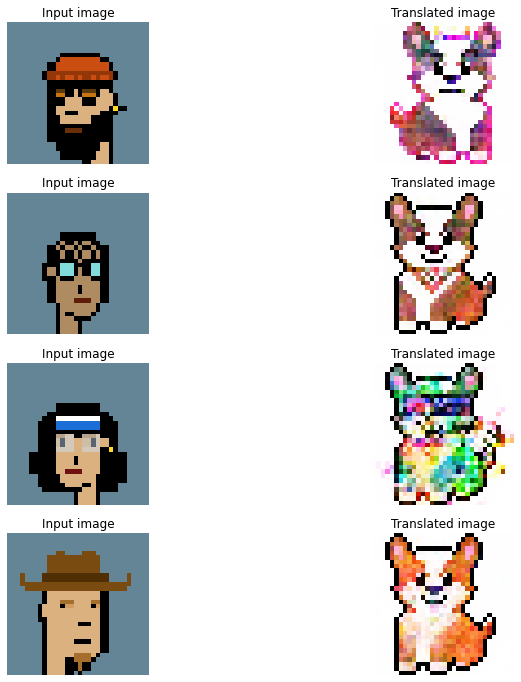

207/207 [==============================] - 71s 341ms/step - G_loss: 2.8073 - F_loss: 2.6781 - D_X_loss: 0.0923 - D_Y_loss: 0.0926
Epoch 53/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7346 - F_loss: 2.5094 - D_X_loss: 0.1004 - D_Y_loss: 0.0982

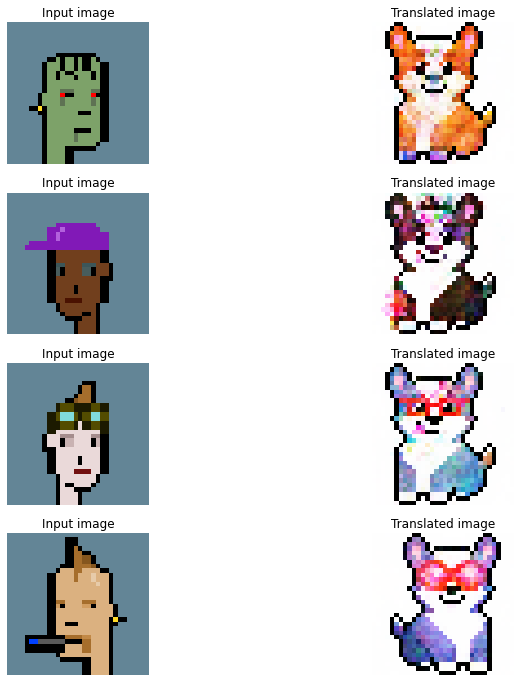

207/207 [==============================] - 70s 340ms/step - G_loss: 2.7344 - F_loss: 2.5044 - D_X_loss: 0.1004 - D_Y_loss: 0.0986
Epoch 54/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7062 - F_loss: 2.5613 - D_X_loss: 0.1098 - D_Y_loss: 0.1021

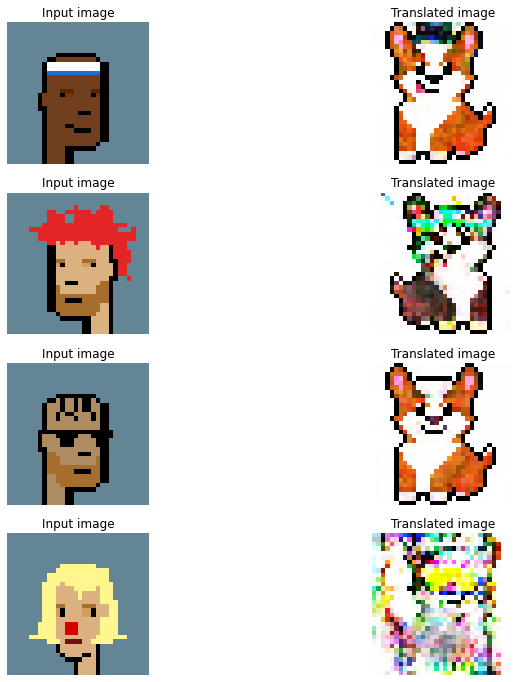

207/207 [==============================] - 70s 340ms/step - G_loss: 2.7055 - F_loss: 2.5578 - D_X_loss: 0.1093 - D_Y_loss: 0.1021
Epoch 55/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7003 - F_loss: 2.4774 - D_X_loss: 0.0921 - D_Y_loss: 0.0974

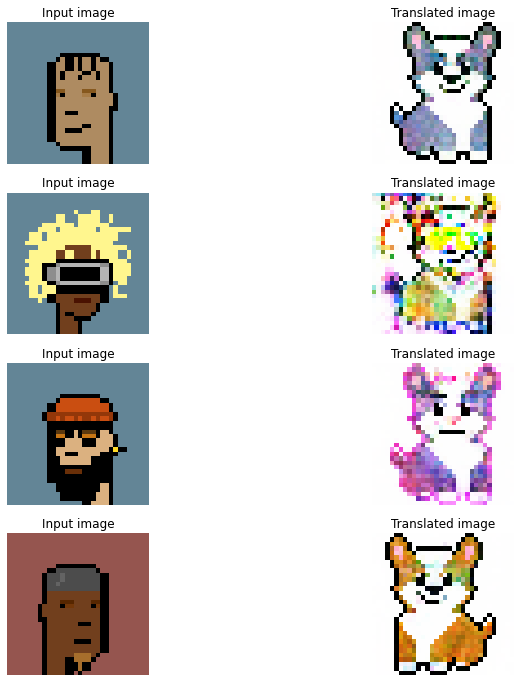

207/207 [==============================] - 71s 341ms/step - G_loss: 2.7019 - F_loss: 2.4820 - D_X_loss: 0.0917 - D_Y_loss: 0.0977
Epoch 56/200
207/207 [==============================] - ETA: 0s - G_loss: 2.6643 - F_loss: 2.5279 - D_X_loss: 0.0974 - D_Y_loss: 0.1010

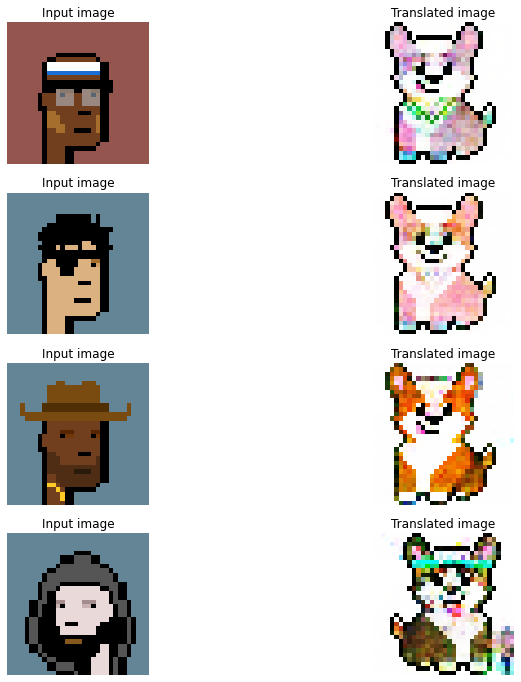

207/207 [==============================] - 70s 340ms/step - G_loss: 2.6622 - F_loss: 2.5330 - D_X_loss: 0.0970 - D_Y_loss: 0.1010
Epoch 57/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7270 - F_loss: 2.5826 - D_X_loss: 0.0996 - D_Y_loss: 0.0901

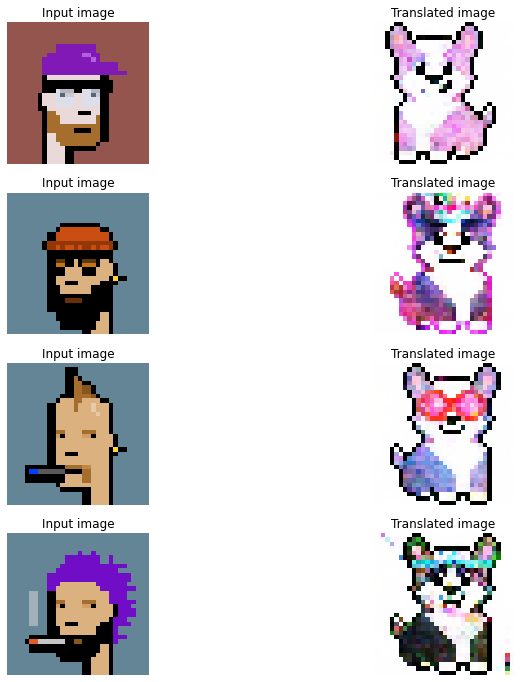

207/207 [==============================] - 70s 340ms/step - G_loss: 2.7257 - F_loss: 2.5752 - D_X_loss: 0.1001 - D_Y_loss: 0.0901
Epoch 58/200
207/207 [==============================] - ETA: 0s - G_loss: 2.6590 - F_loss: 2.4901 - D_X_loss: 0.0996 - D_Y_loss: 0.1014

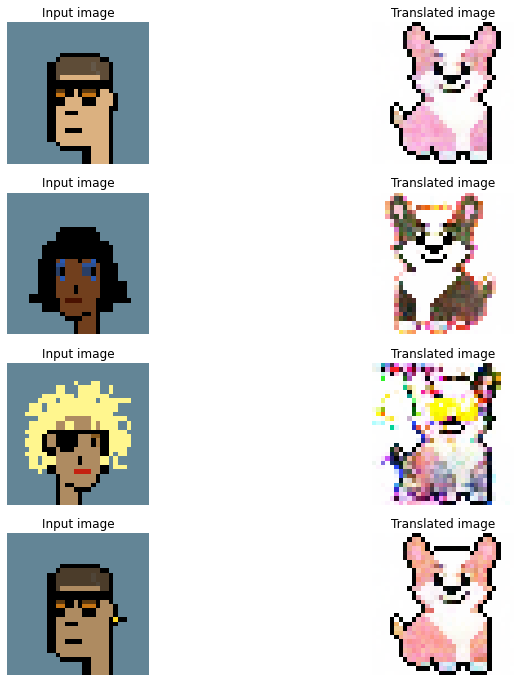

207/207 [==============================] - 70s 340ms/step - G_loss: 2.6623 - F_loss: 2.4865 - D_X_loss: 0.0992 - D_Y_loss: 0.1013
Epoch 59/200
207/207 [==============================] - ETA: 0s - G_loss: 2.6544 - F_loss: 2.4257 - D_X_loss: 0.0996 - D_Y_loss: 0.0913

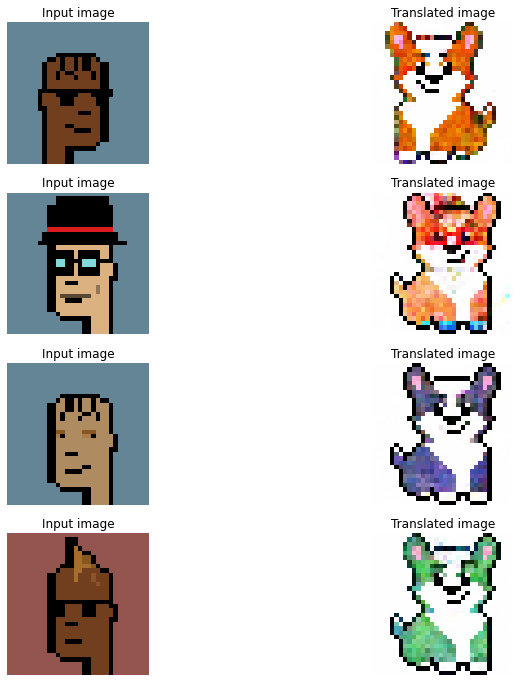

207/207 [==============================] - 70s 339ms/step - G_loss: 2.6542 - F_loss: 2.4193 - D_X_loss: 0.1010 - D_Y_loss: 0.0909
Epoch 60/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5953 - F_loss: 2.4022 - D_X_loss: 0.1044 - D_Y_loss: 0.1069

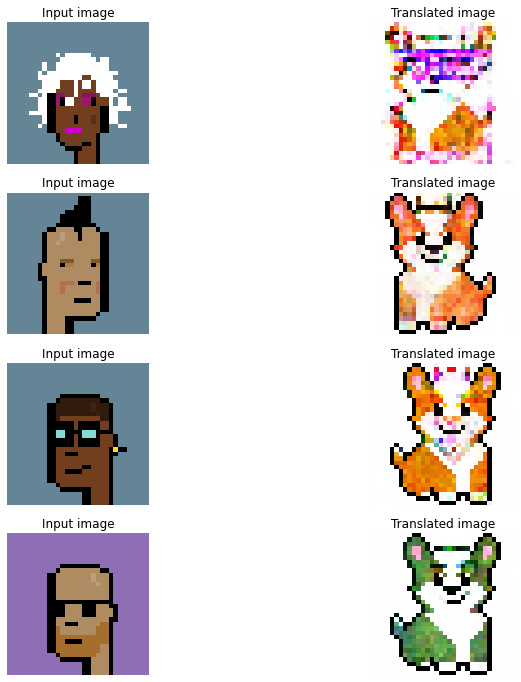

207/207 [==============================] - 70s 339ms/step - G_loss: 2.5993 - F_loss: 2.3982 - D_X_loss: 0.1040 - D_Y_loss: 0.1064
Epoch 61/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5845 - F_loss: 2.3747 - D_X_loss: 0.1115 - D_Y_loss: 0.1009

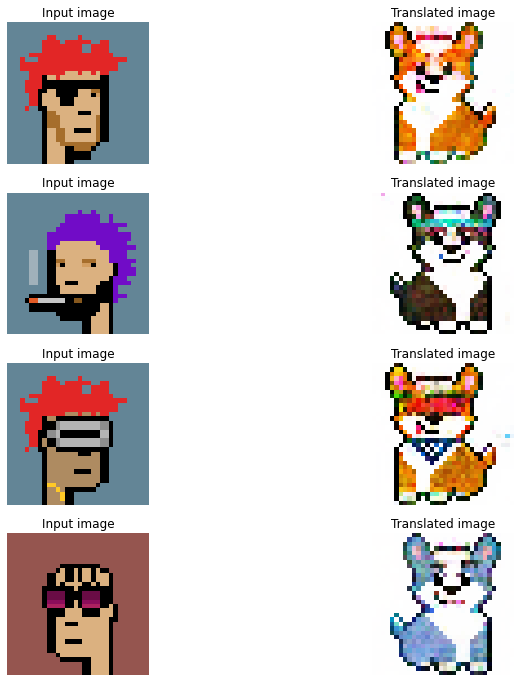

207/207 [==============================] - 70s 340ms/step - G_loss: 2.5861 - F_loss: 2.3771 - D_X_loss: 0.1117 - D_Y_loss: 0.1007
Epoch 62/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5605 - F_loss: 2.3229 - D_X_loss: 0.1127 - D_Y_loss: 0.0968

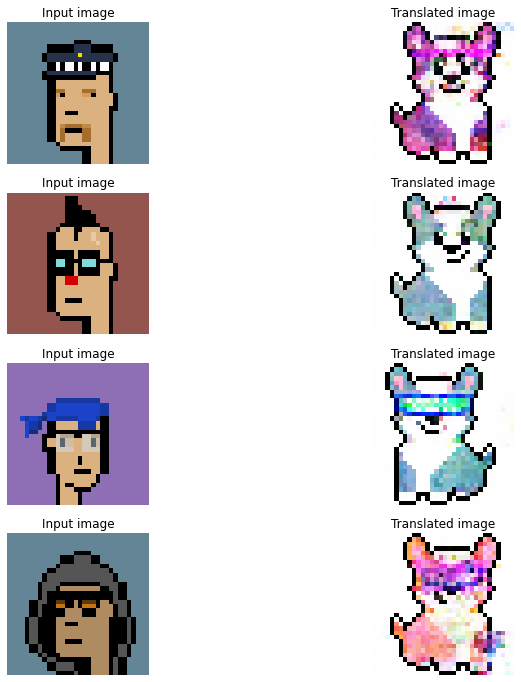

207/207 [==============================] - 70s 340ms/step - G_loss: 2.5582 - F_loss: 2.3177 - D_X_loss: 0.1137 - D_Y_loss: 0.0965
Epoch 63/200
207/207 [==============================] - ETA: 0s - G_loss: 2.6050 - F_loss: 2.4777 - D_X_loss: 0.1018 - D_Y_loss: 0.0997

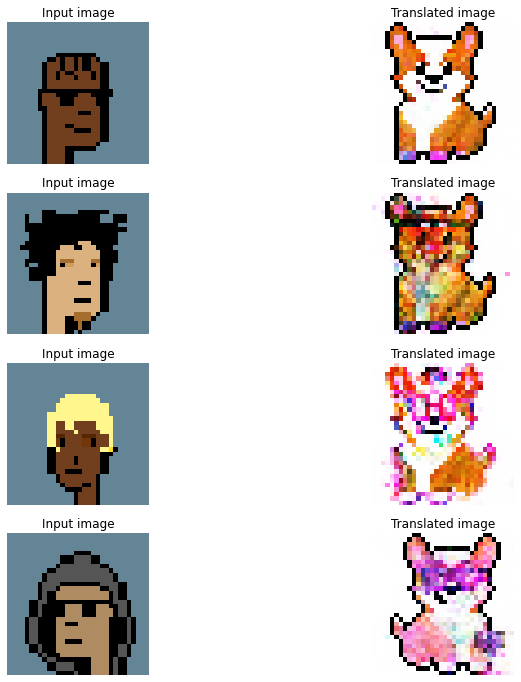

207/207 [==============================] - 71s 341ms/step - G_loss: 2.6039 - F_loss: 2.4752 - D_X_loss: 0.1014 - D_Y_loss: 0.0993
Epoch 64/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5981 - F_loss: 2.4710 - D_X_loss: 0.0936 - D_Y_loss: 0.0979

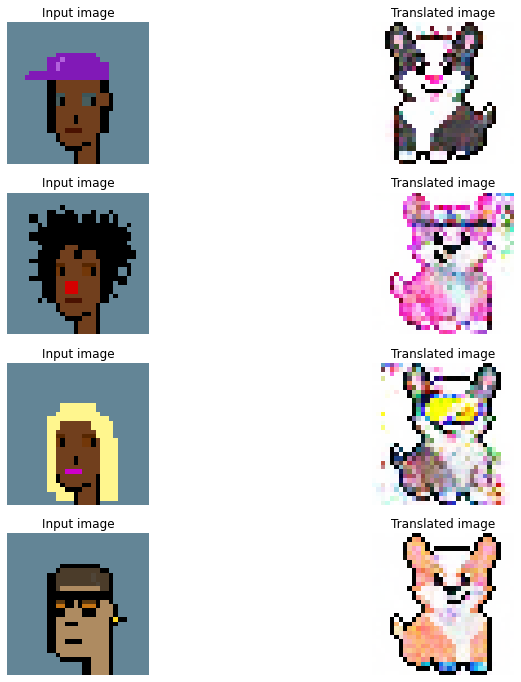

207/207 [==============================] - 70s 340ms/step - G_loss: 2.6072 - F_loss: 2.4641 - D_X_loss: 0.0943 - D_Y_loss: 0.0975
Epoch 65/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4753 - F_loss: 2.3930 - D_X_loss: 0.0997 - D_Y_loss: 0.1093

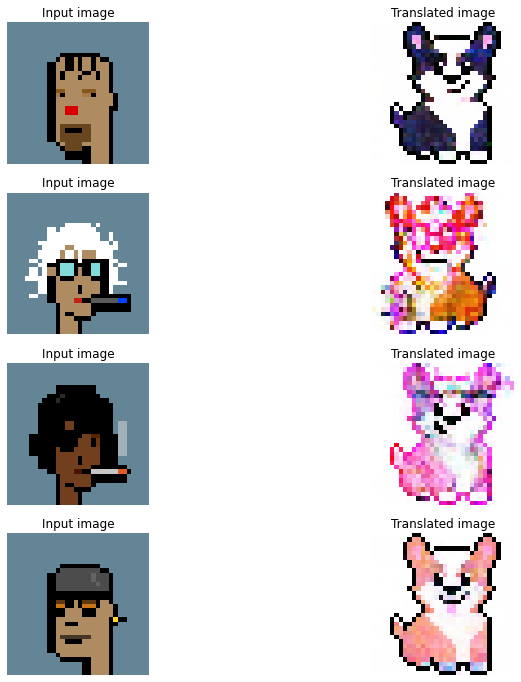

207/207 [==============================] - 70s 341ms/step - G_loss: 2.4847 - F_loss: 2.3985 - D_X_loss: 0.0993 - D_Y_loss: 0.1088
Epoch 66/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4601 - F_loss: 2.4141 - D_X_loss: 0.1033 - D_Y_loss: 0.1101

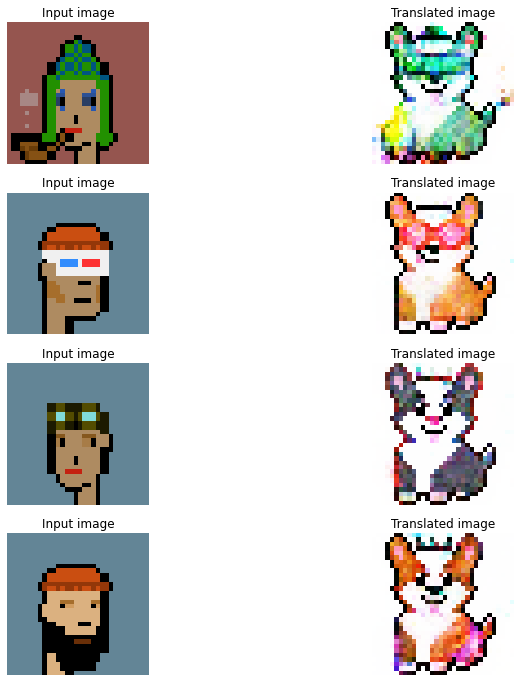

207/207 [==============================] - 70s 339ms/step - G_loss: 2.4612 - F_loss: 2.4143 - D_X_loss: 0.1031 - D_Y_loss: 0.1096
Epoch 67/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4833 - F_loss: 2.4357 - D_X_loss: 0.1017 - D_Y_loss: 0.1067

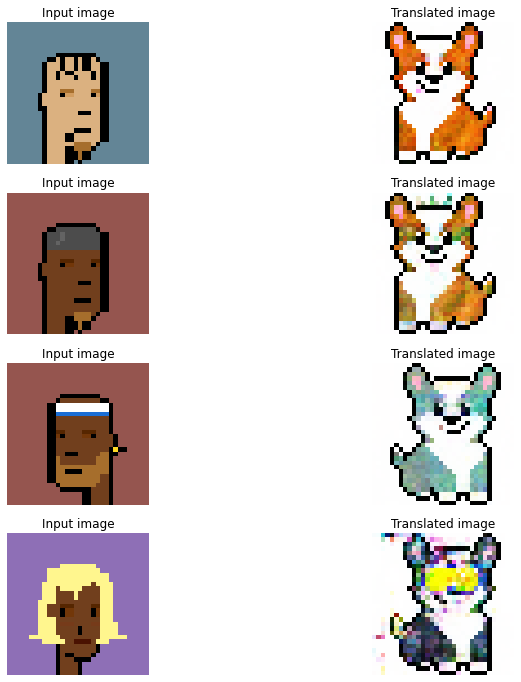

207/207 [==============================] - 70s 339ms/step - G_loss: 2.4863 - F_loss: 2.4476 - D_X_loss: 0.1024 - D_Y_loss: 0.1064
Epoch 68/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4401 - F_loss: 2.4171 - D_X_loss: 0.1018 - D_Y_loss: 0.1154

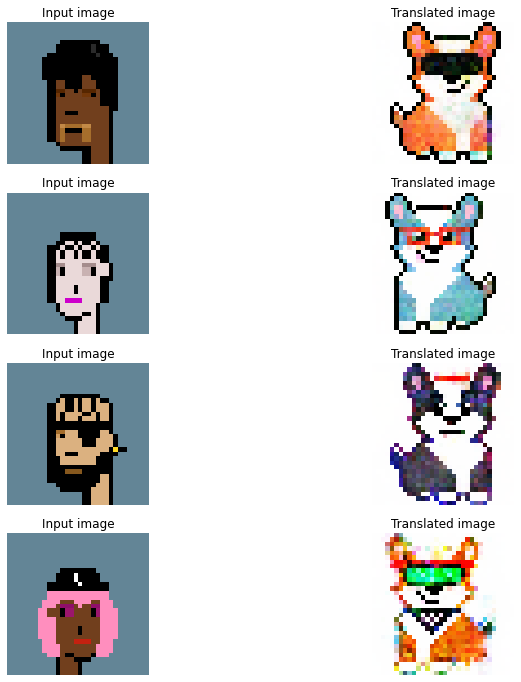

207/207 [==============================] - 70s 340ms/step - G_loss: 2.4431 - F_loss: 2.4201 - D_X_loss: 0.1015 - D_Y_loss: 0.1149
Epoch 69/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5147 - F_loss: 2.4296 - D_X_loss: 0.0891 - D_Y_loss: 0.0937

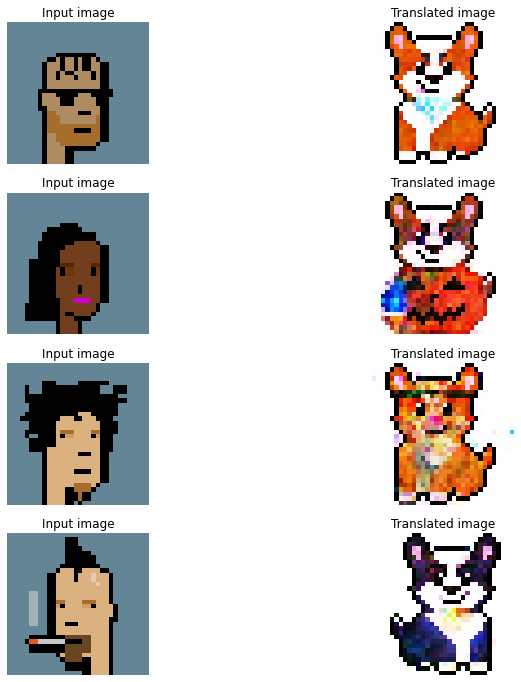

207/207 [==============================] - 70s 339ms/step - G_loss: 2.5167 - F_loss: 2.4325 - D_X_loss: 0.0888 - D_Y_loss: 0.0947
Epoch 70/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4379 - F_loss: 2.3833 - D_X_loss: 0.1156 - D_Y_loss: 0.1017

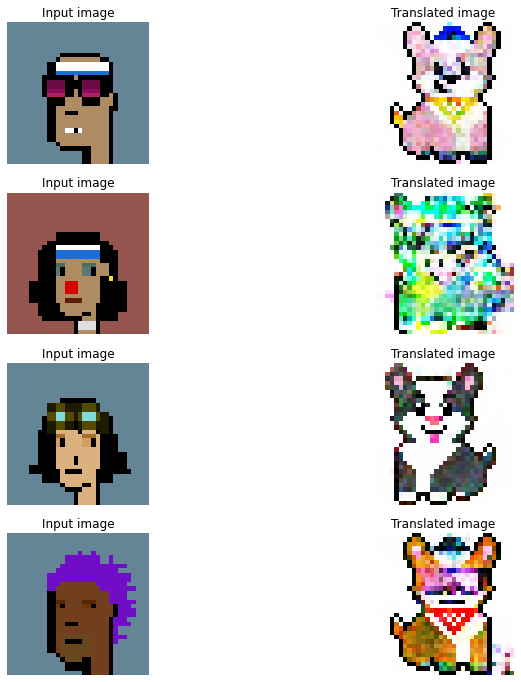

207/207 [==============================] - 70s 339ms/step - G_loss: 2.4348 - F_loss: 2.3831 - D_X_loss: 0.1152 - D_Y_loss: 0.1019
Epoch 71/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4856 - F_loss: 2.4248 - D_X_loss: 0.1178 - D_Y_loss: 0.1061

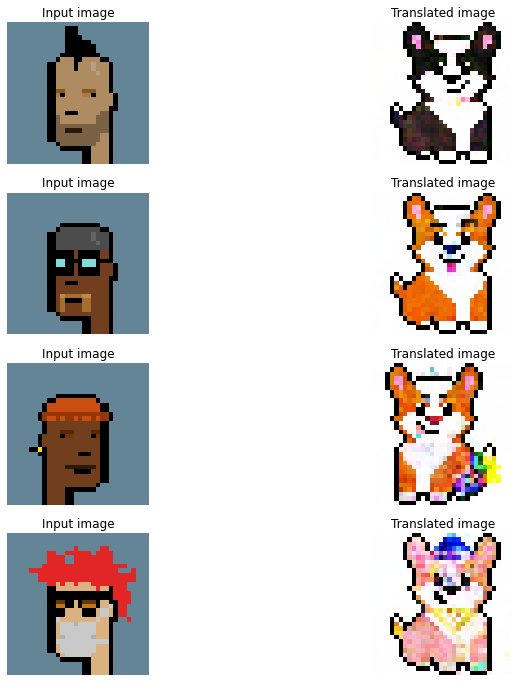

207/207 [==============================] - 70s 337ms/step - G_loss: 2.4878 - F_loss: 2.4316 - D_X_loss: 0.1174 - D_Y_loss: 0.1058
Epoch 72/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4553 - F_loss: 2.2212 - D_X_loss: 0.1240 - D_Y_loss: 0.0980

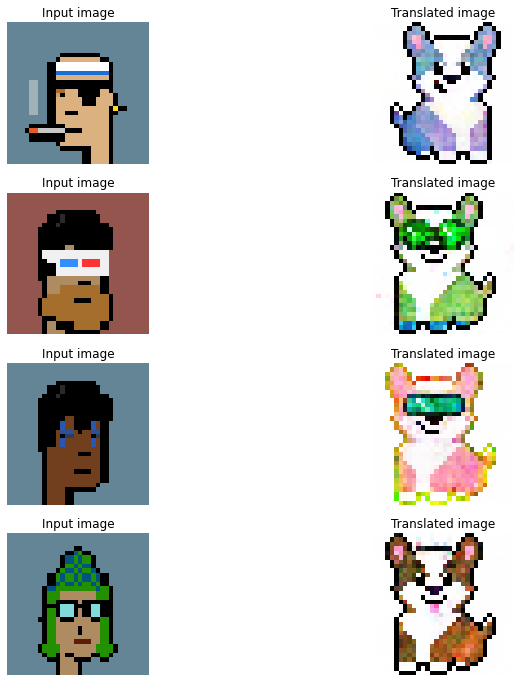

207/207 [==============================] - 70s 337ms/step - G_loss: 2.4584 - F_loss: 2.2209 - D_X_loss: 0.1235 - D_Y_loss: 0.0994
Epoch 73/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4013 - F_loss: 2.3349 - D_X_loss: 0.1120 - D_Y_loss: 0.1077

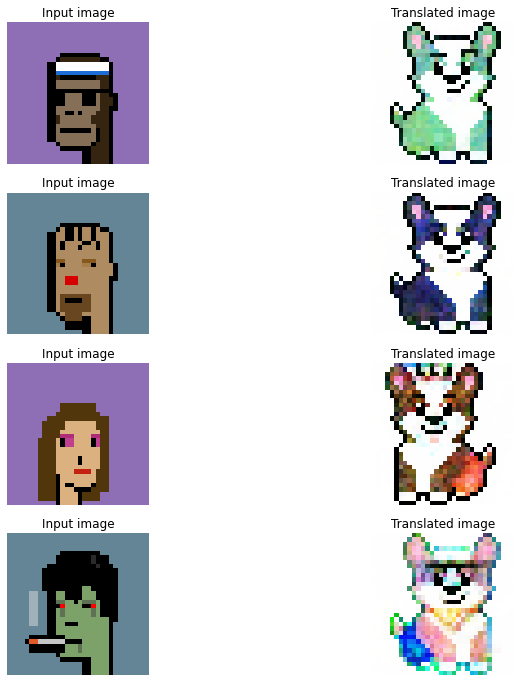

207/207 [==============================] - 70s 339ms/step - G_loss: 2.3969 - F_loss: 2.3476 - D_X_loss: 0.1125 - D_Y_loss: 0.1073
Epoch 74/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4679 - F_loss: 2.2024 - D_X_loss: 0.1219 - D_Y_loss: 0.1104

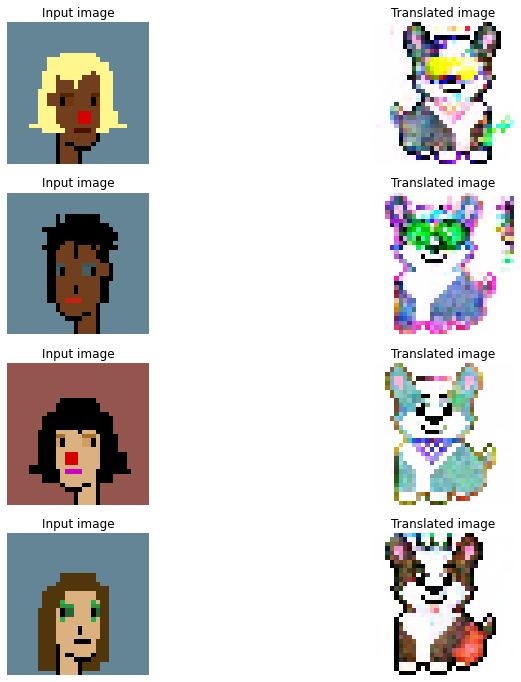

207/207 [==============================] - 70s 339ms/step - G_loss: 2.4665 - F_loss: 2.2055 - D_X_loss: 0.1214 - D_Y_loss: 0.1110
Epoch 75/200
207/207 [==============================] - ETA: 0s - G_loss: 2.3638 - F_loss: 2.2306 - D_X_loss: 0.1245 - D_Y_loss: 0.1062

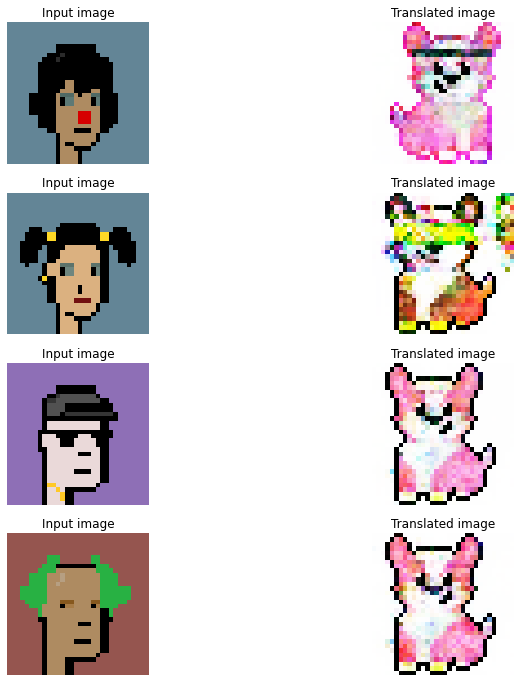

207/207 [==============================] - 70s 339ms/step - G_loss: 2.3600 - F_loss: 2.2293 - D_X_loss: 0.1240 - D_Y_loss: 0.1068
Epoch 76/200
207/207 [==============================] - ETA: 0s - G_loss: 2.3648 - F_loss: 2.1746 - D_X_loss: 0.1208 - D_Y_loss: 0.1059

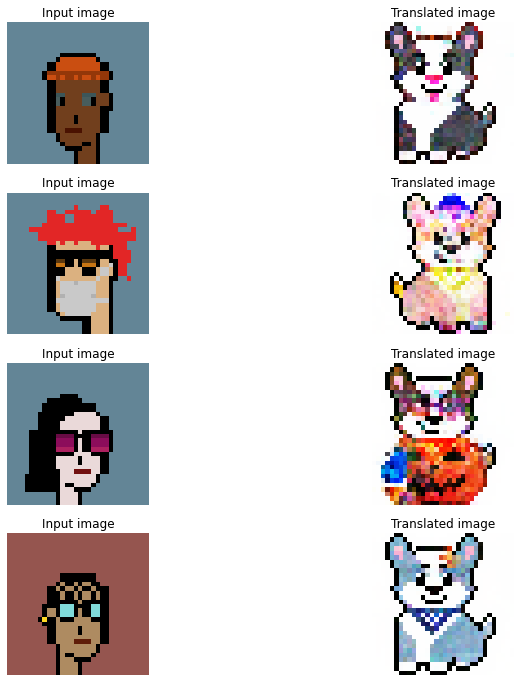

207/207 [==============================] - 70s 339ms/step - G_loss: 2.3664 - F_loss: 2.1736 - D_X_loss: 0.1205 - D_Y_loss: 0.1054
Epoch 77/200
207/207 [==============================] - ETA: 0s - G_loss: 2.3103 - F_loss: 2.2476 - D_X_loss: 0.1124 - D_Y_loss: 0.1143

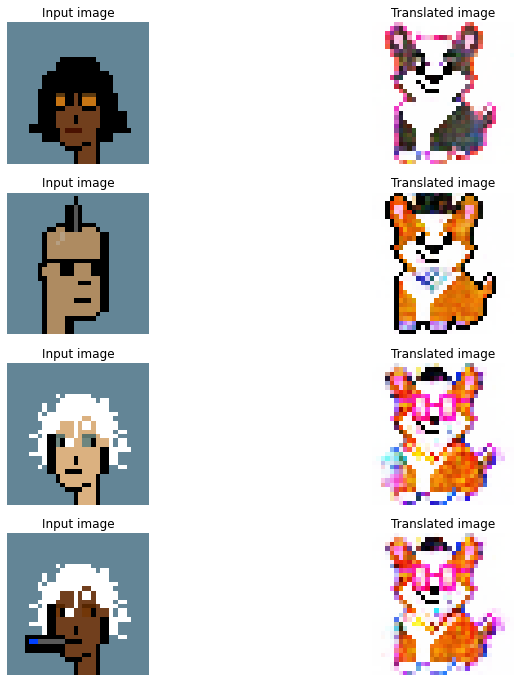

207/207 [==============================] - 70s 339ms/step - G_loss: 2.3112 - F_loss: 2.2480 - D_X_loss: 0.1122 - D_Y_loss: 0.1139
Epoch 78/200
207/207 [==============================] - ETA: 0s - G_loss: 2.3674 - F_loss: 2.1728 - D_X_loss: 0.1167 - D_Y_loss: 0.1060

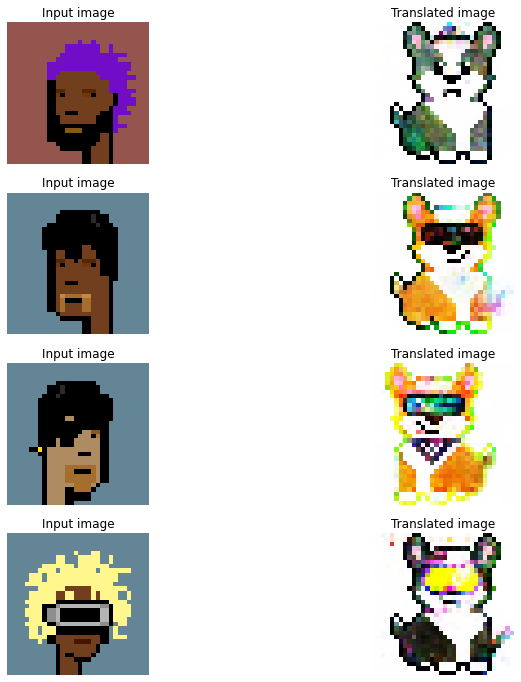

207/207 [==============================] - 70s 339ms/step - G_loss: 2.3616 - F_loss: 2.1738 - D_X_loss: 0.1162 - D_Y_loss: 0.1062
Epoch 79/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2996 - F_loss: 2.2233 - D_X_loss: 0.1113 - D_Y_loss: 0.1157

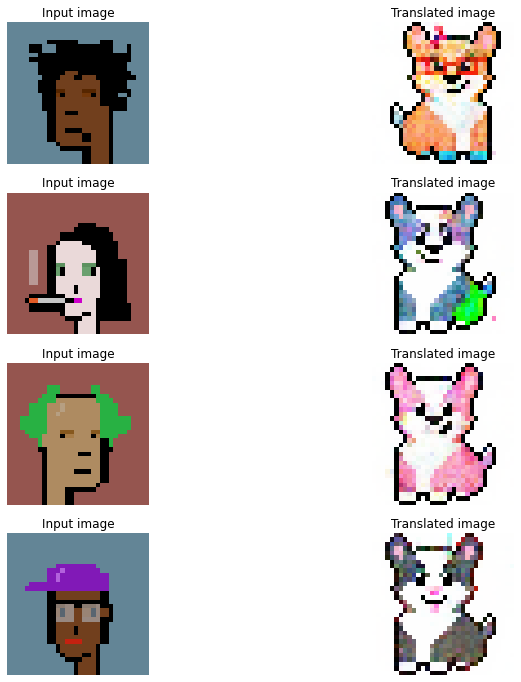

207/207 [==============================] - 70s 340ms/step - G_loss: 2.2958 - F_loss: 2.2229 - D_X_loss: 0.1119 - D_Y_loss: 0.1159
Epoch 80/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2987 - F_loss: 2.3165 - D_X_loss: 0.1011 - D_Y_loss: 0.1250

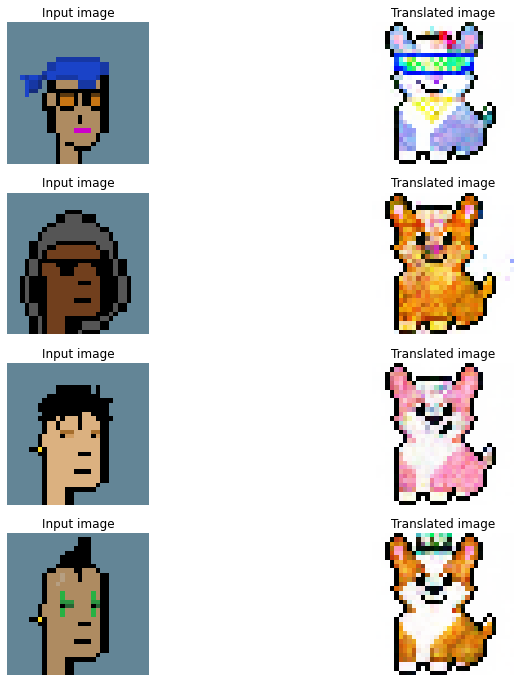

207/207 [==============================] - 70s 339ms/step - G_loss: 2.2927 - F_loss: 2.3104 - D_X_loss: 0.1027 - D_Y_loss: 0.1266
Epoch 81/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2862 - F_loss: 2.2163 - D_X_loss: 0.1091 - D_Y_loss: 0.1187

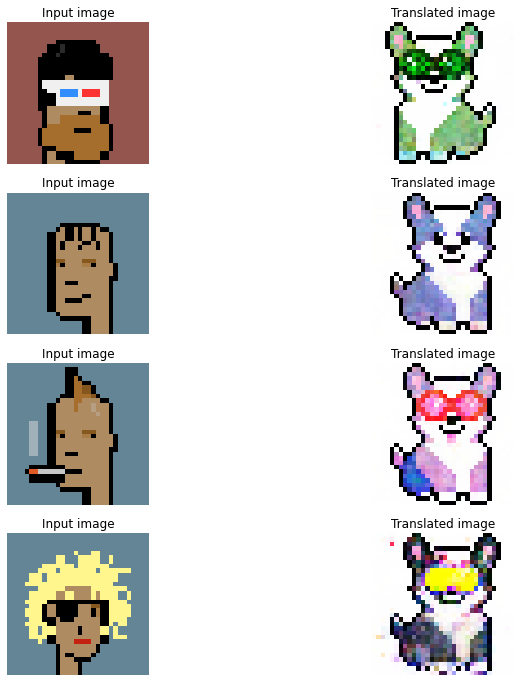

207/207 [==============================] - 70s 338ms/step - G_loss: 2.2842 - F_loss: 2.2296 - D_X_loss: 0.1089 - D_Y_loss: 0.1188
Epoch 82/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2596 - F_loss: 2.2827 - D_X_loss: 0.1193 - D_Y_loss: 0.1201

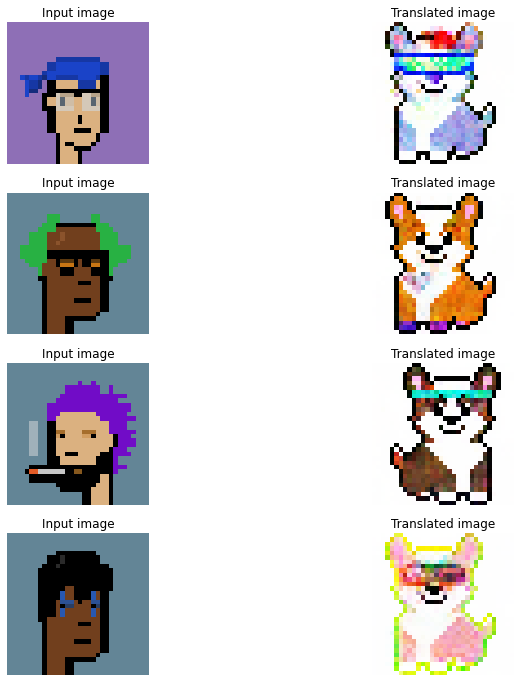

207/207 [==============================] - 70s 339ms/step - G_loss: 2.2559 - F_loss: 2.3021 - D_X_loss: 0.1188 - D_Y_loss: 0.1201
Epoch 83/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2551 - F_loss: 2.3551 - D_X_loss: 0.1088 - D_Y_loss: 0.1253

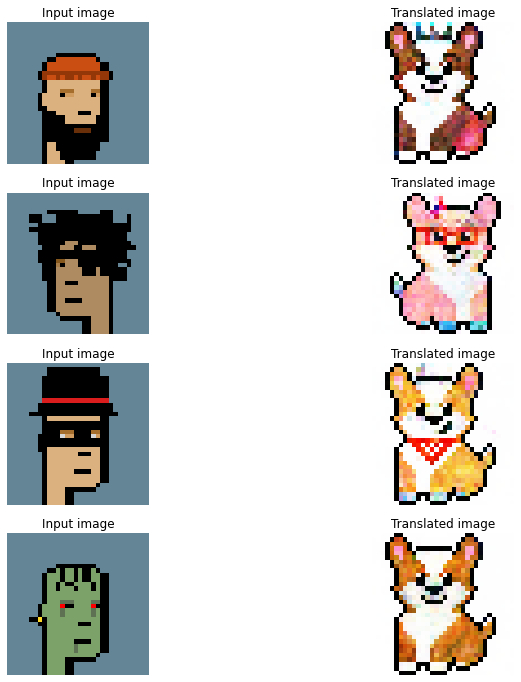

207/207 [==============================] - 70s 338ms/step - G_loss: 2.2524 - F_loss: 2.3530 - D_X_loss: 0.1103 - D_Y_loss: 0.1257
Epoch 84/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2782 - F_loss: 2.0267 - D_X_loss: 0.1301 - D_Y_loss: 0.1141

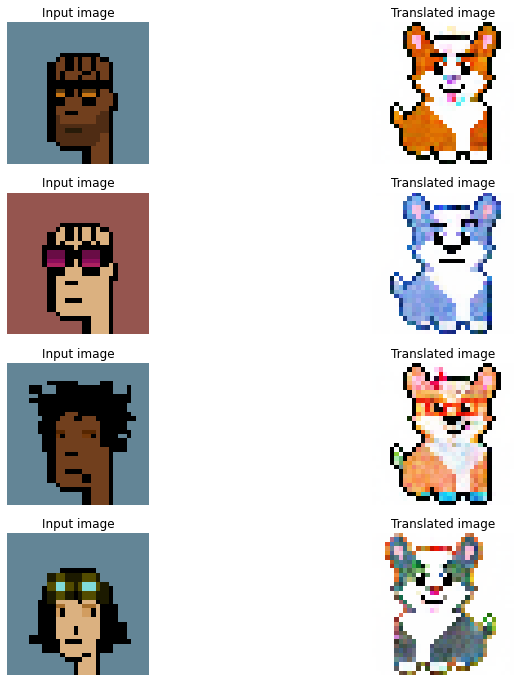

207/207 [==============================] - 70s 339ms/step - G_loss: 2.2780 - F_loss: 2.0205 - D_X_loss: 0.1323 - D_Y_loss: 0.1136
Epoch 85/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2468 - F_loss: 2.1501 - D_X_loss: 0.1258 - D_Y_loss: 0.1297

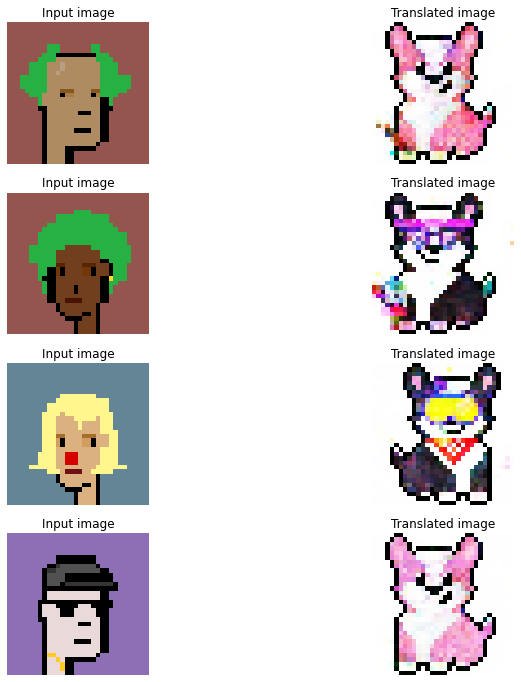

207/207 [==============================] - 70s 338ms/step - G_loss: 2.2430 - F_loss: 2.1495 - D_X_loss: 0.1262 - D_Y_loss: 0.1304
Epoch 86/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2239 - F_loss: 2.0772 - D_X_loss: 0.1212 - D_Y_loss: 0.1280

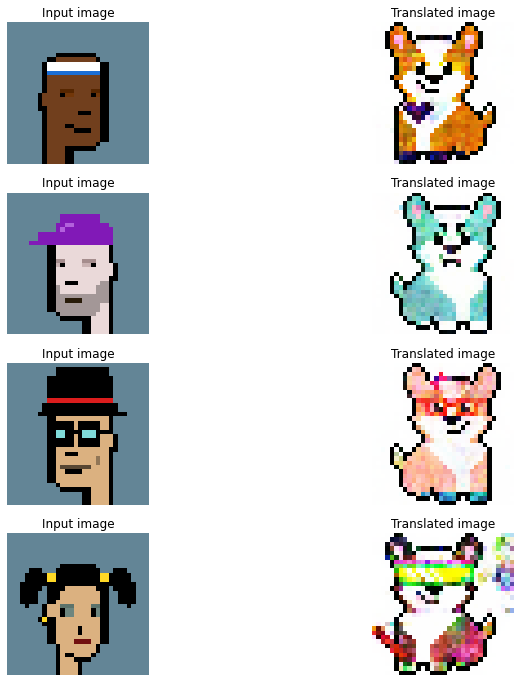

207/207 [==============================] - 70s 339ms/step - G_loss: 2.2242 - F_loss: 2.0738 - D_X_loss: 0.1209 - D_Y_loss: 0.1283
Epoch 87/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2546 - F_loss: 2.2017 - D_X_loss: 0.1134 - D_Y_loss: 0.1203

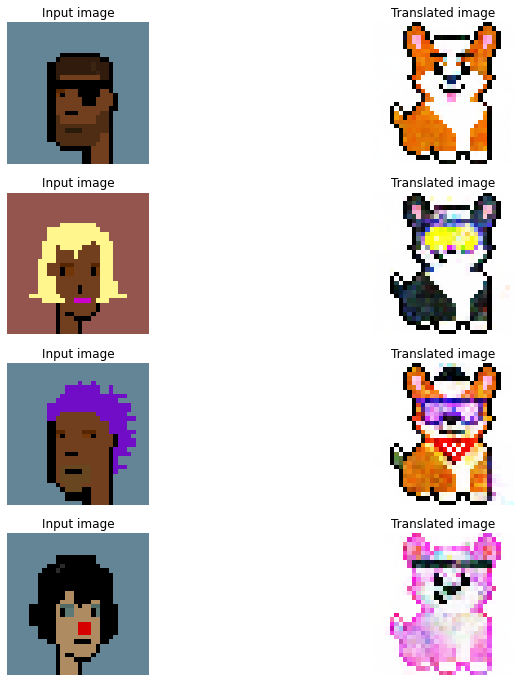

207/207 [==============================] - 70s 339ms/step - G_loss: 2.2604 - F_loss: 2.1976 - D_X_loss: 0.1134 - D_Y_loss: 0.1199
Epoch 88/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1675 - F_loss: 2.1680 - D_X_loss: 0.1254 - D_Y_loss: 0.1296

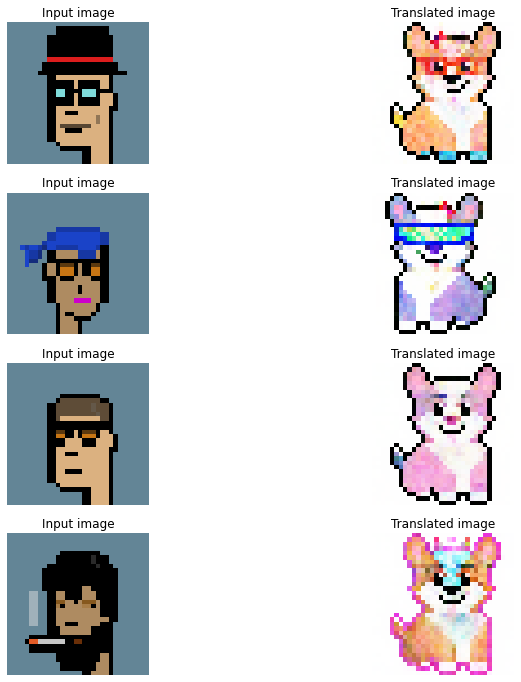

207/207 [==============================] - 70s 338ms/step - G_loss: 2.1710 - F_loss: 2.1682 - D_X_loss: 0.1255 - D_Y_loss: 0.1295
Epoch 89/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1221 - F_loss: 2.0997 - D_X_loss: 0.1310 - D_Y_loss: 0.1294

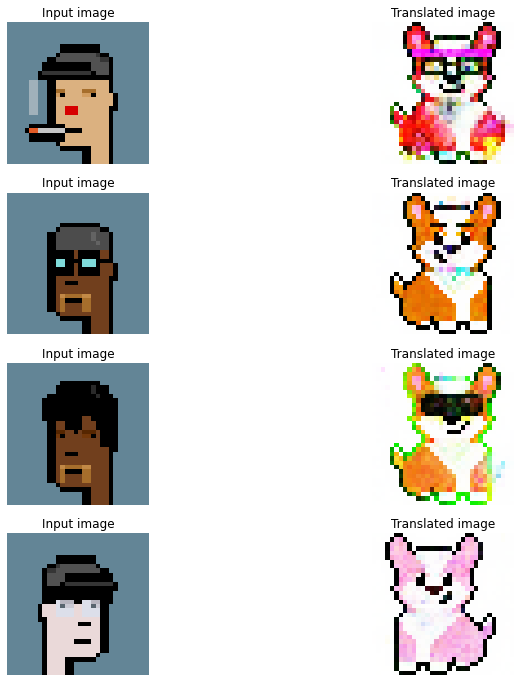

207/207 [==============================] - 70s 339ms/step - G_loss: 2.1226 - F_loss: 2.0989 - D_X_loss: 0.1307 - D_Y_loss: 0.1290
Epoch 90/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1765 - F_loss: 2.0655 - D_X_loss: 0.1276 - D_Y_loss: 0.1247

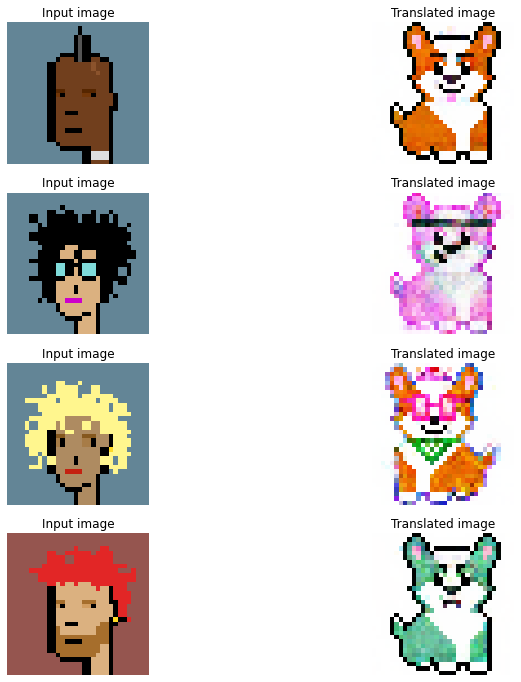

207/207 [==============================] - 70s 338ms/step - G_loss: 2.1748 - F_loss: 2.0658 - D_X_loss: 0.1270 - D_Y_loss: 0.1248
Epoch 91/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1806 - F_loss: 2.0392 - D_X_loss: 0.1188 - D_Y_loss: 0.1291

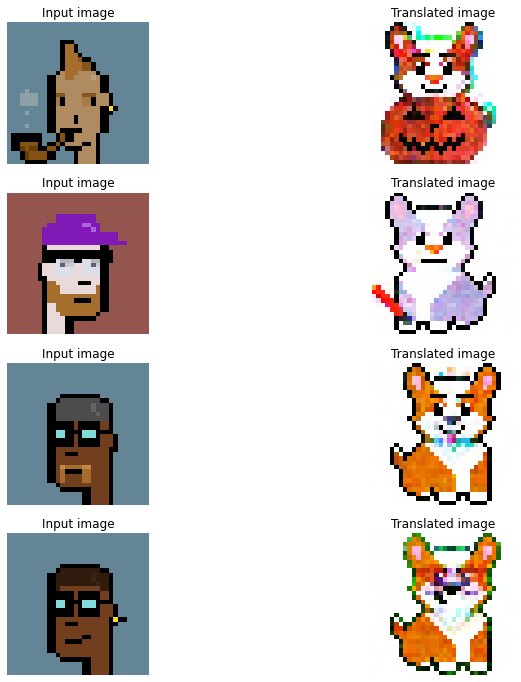

207/207 [==============================] - 70s 339ms/step - G_loss: 2.1791 - F_loss: 2.0379 - D_X_loss: 0.1203 - D_Y_loss: 0.1310
Epoch 92/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1084 - F_loss: 2.0773 - D_X_loss: 0.1212 - D_Y_loss: 0.1295

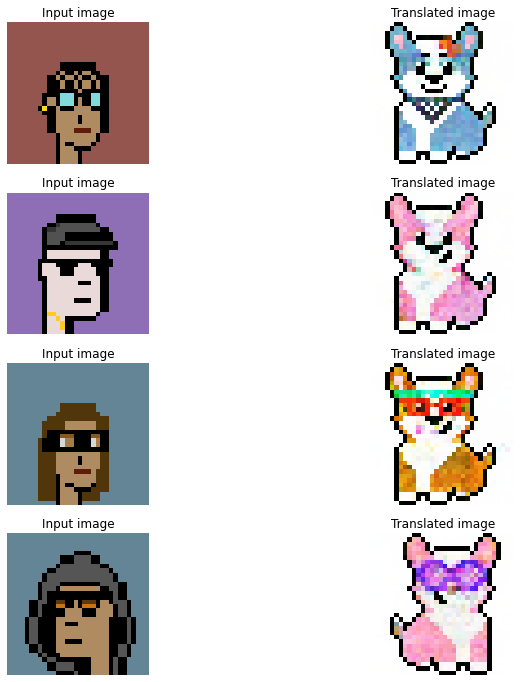

207/207 [==============================] - 70s 338ms/step - G_loss: 2.1117 - F_loss: 2.0725 - D_X_loss: 0.1225 - D_Y_loss: 0.1290
Epoch 93/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1550 - F_loss: 2.0406 - D_X_loss: 0.1337 - D_Y_loss: 0.1352

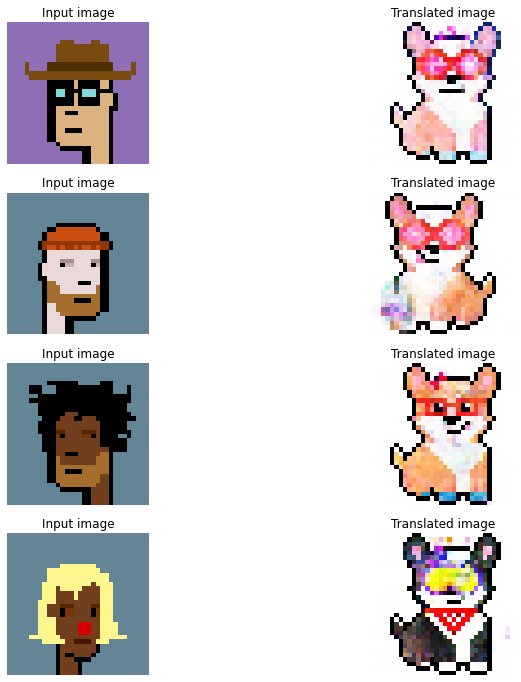

207/207 [==============================] - 70s 338ms/step - G_loss: 2.1508 - F_loss: 2.0387 - D_X_loss: 0.1335 - D_Y_loss: 0.1369
Epoch 94/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1203 - F_loss: 1.9404 - D_X_loss: 0.1349 - D_Y_loss: 0.1294

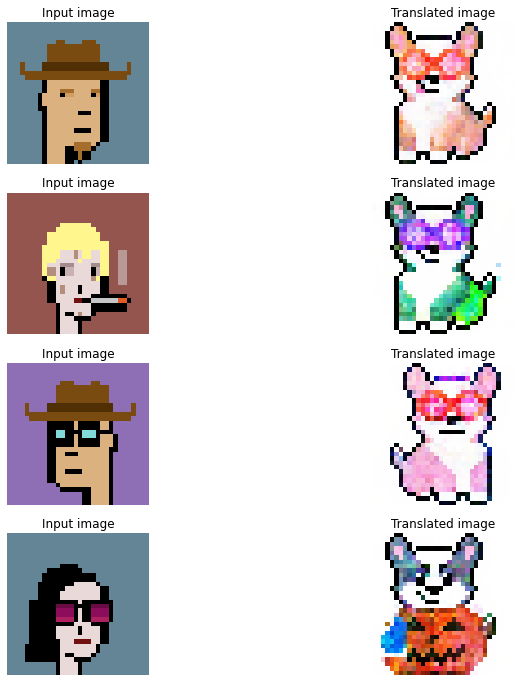

207/207 [==============================] - 70s 338ms/step - G_loss: 2.1135 - F_loss: 1.9423 - D_X_loss: 0.1343 - D_Y_loss: 0.1312
Epoch 95/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1913 - F_loss: 2.1229 - D_X_loss: 0.1182 - D_Y_loss: 0.1286

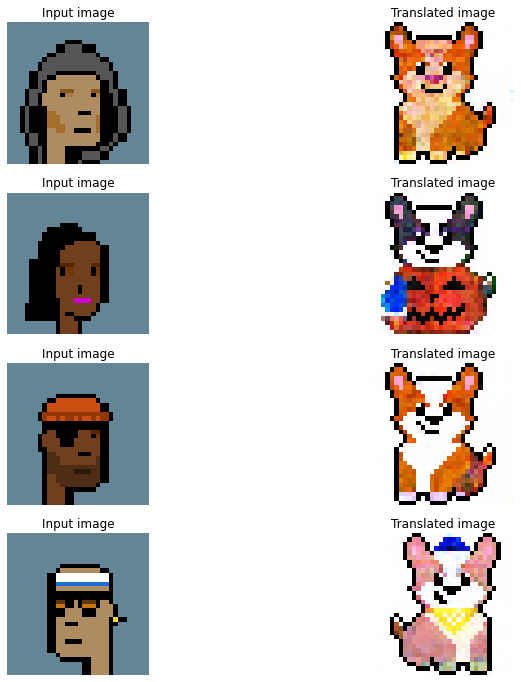

207/207 [==============================] - 70s 338ms/step - G_loss: 2.1922 - F_loss: 2.1276 - D_X_loss: 0.1177 - D_Y_loss: 0.1280
Epoch 96/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1088 - F_loss: 2.0615 - D_X_loss: 0.1189 - D_Y_loss: 0.1338

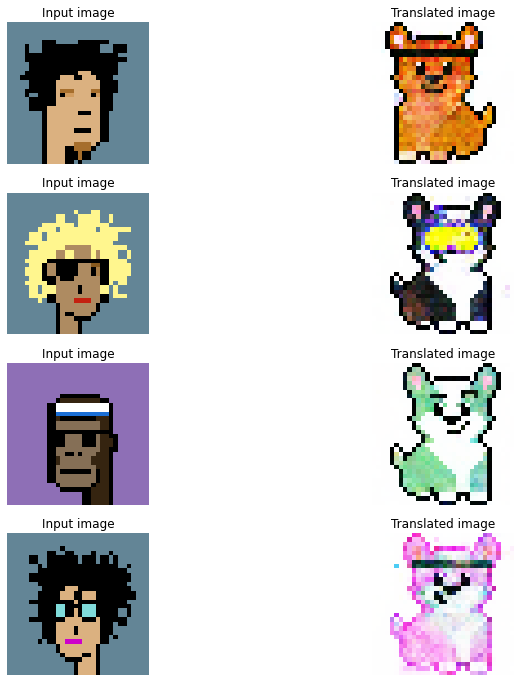

207/207 [==============================] - 70s 336ms/step - G_loss: 2.1120 - F_loss: 2.0658 - D_X_loss: 0.1186 - D_Y_loss: 0.1337
Epoch 97/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1104 - F_loss: 2.0567 - D_X_loss: 0.1255 - D_Y_loss: 0.1349

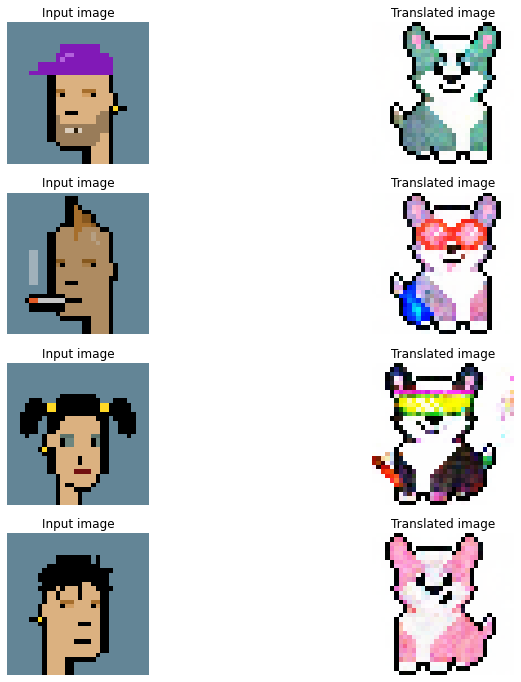

207/207 [==============================] - 70s 339ms/step - G_loss: 2.1106 - F_loss: 2.0553 - D_X_loss: 0.1251 - D_Y_loss: 0.1346
Epoch 98/200
207/207 [==============================] - ETA: 0s - G_loss: 2.0665 - F_loss: 2.1259 - D_X_loss: 0.1210 - D_Y_loss: 0.1348

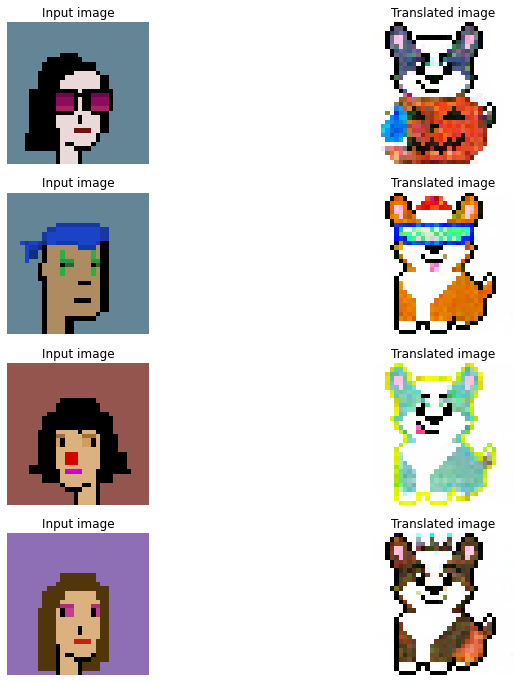

207/207 [==============================] - 70s 339ms/step - G_loss: 2.0643 - F_loss: 2.1245 - D_X_loss: 0.1207 - D_Y_loss: 0.1343
Epoch 99/200
207/207 [==============================] - ETA: 0s - G_loss: 2.0923 - F_loss: 2.1588 - D_X_loss: 0.1200 - D_Y_loss: 0.1370

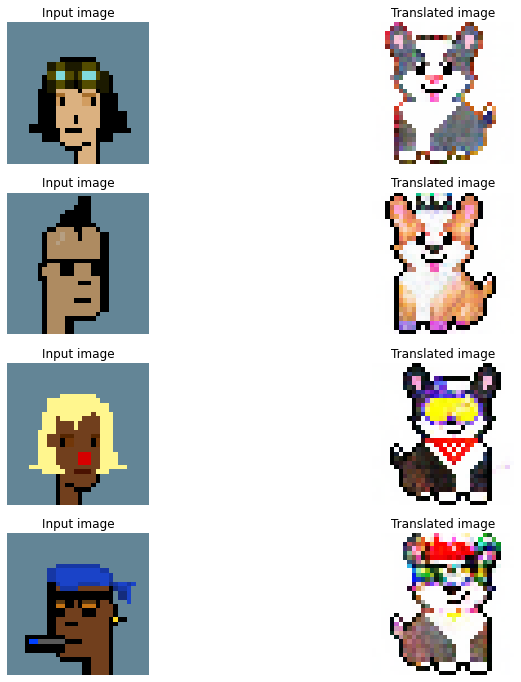

207/207 [==============================] - 70s 339ms/step - G_loss: 2.0910 - F_loss: 2.1603 - D_X_loss: 0.1194 - D_Y_loss: 0.1367
Epoch 100/200
207/207 [==============================] - ETA: 0s - G_loss: 2.0271 - F_loss: 2.0282 - D_X_loss: 0.1386 - D_Y_loss: 0.1377

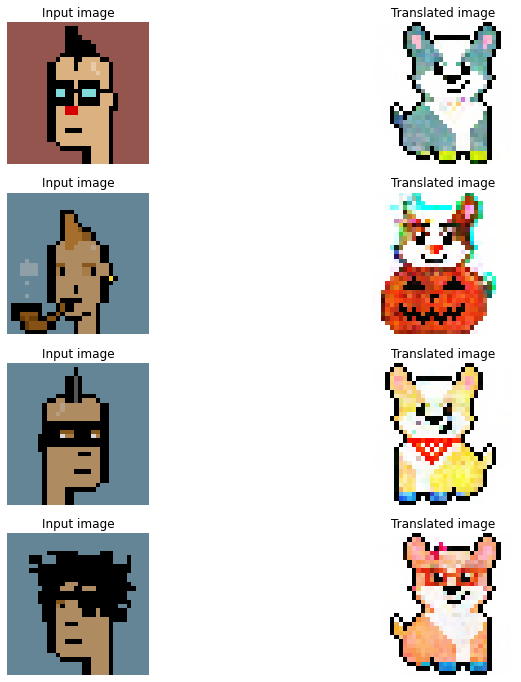

207/207 [==============================] - 70s 338ms/step - G_loss: 2.0298 - F_loss: 2.0250 - D_X_loss: 0.1382 - D_Y_loss: 0.1371
Epoch 101/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1215 - F_loss: 1.9528 - D_X_loss: 0.1321 - D_Y_loss: 0.1279

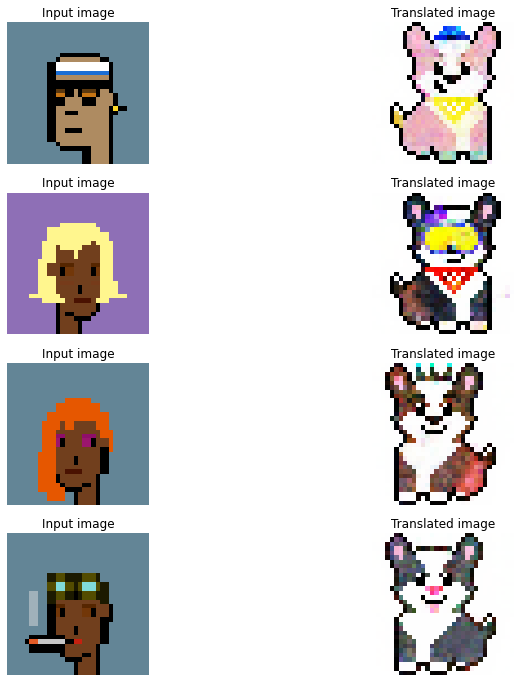

207/207 [==============================] - 70s 337ms/step - G_loss: 2.1196 - F_loss: 1.9706 - D_X_loss: 0.1316 - D_Y_loss: 0.1276
Epoch 102/200
207/207 [==============================] - ETA: 0s - G_loss: 2.0283 - F_loss: 2.0162 - D_X_loss: 0.1295 - D_Y_loss: 0.1354

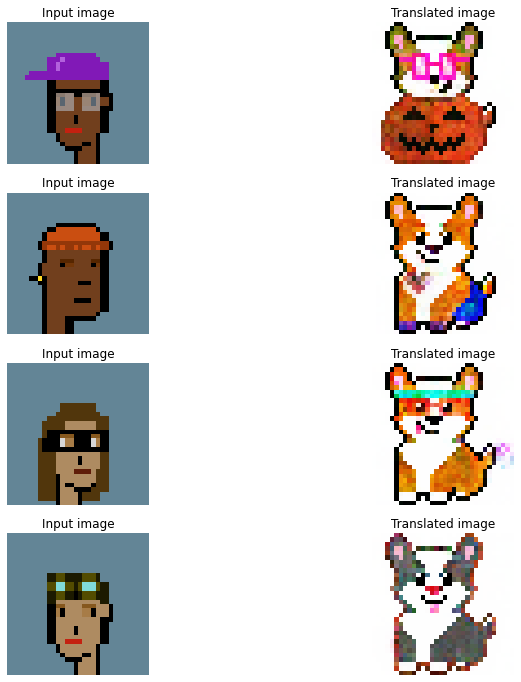

207/207 [==============================] - 70s 339ms/step - G_loss: 2.0226 - F_loss: 2.0120 - D_X_loss: 0.1297 - D_Y_loss: 0.1369
Epoch 103/200
207/207 [==============================] - ETA: 0s - G_loss: 2.0553 - F_loss: 2.0013 - D_X_loss: 0.1246 - D_Y_loss: 0.1360

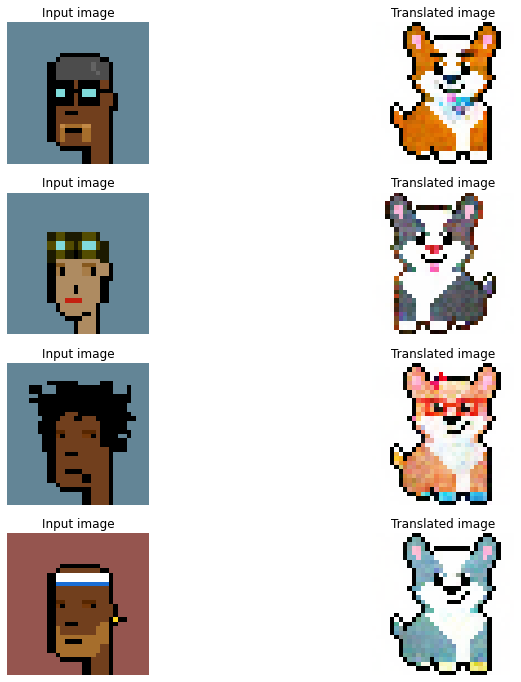

207/207 [==============================] - 70s 338ms/step - G_loss: 2.0554 - F_loss: 1.9962 - D_X_loss: 0.1245 - D_Y_loss: 0.1355
Epoch 104/200
207/207 [==============================] - ETA: 0s - G_loss: 2.0542 - F_loss: 1.9963 - D_X_loss: 0.1238 - D_Y_loss: 0.1312

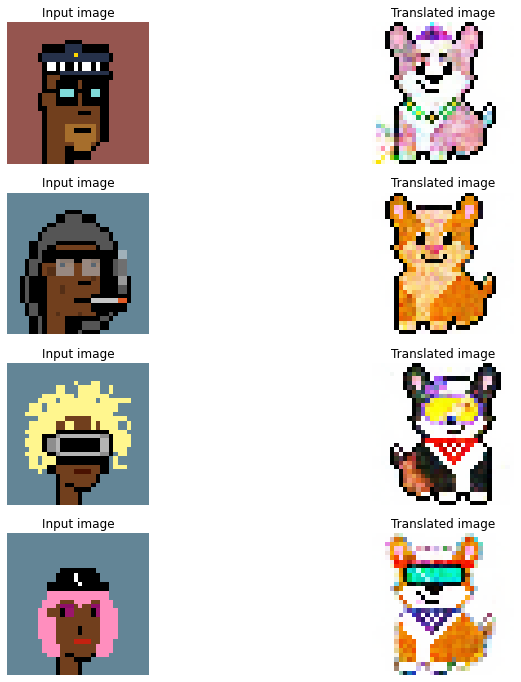

207/207 [==============================] - 70s 339ms/step - G_loss: 2.0515 - F_loss: 1.9981 - D_X_loss: 0.1233 - D_Y_loss: 0.1314
Epoch 105/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9630 - F_loss: 1.8930 - D_X_loss: 0.1410 - D_Y_loss: 0.1420

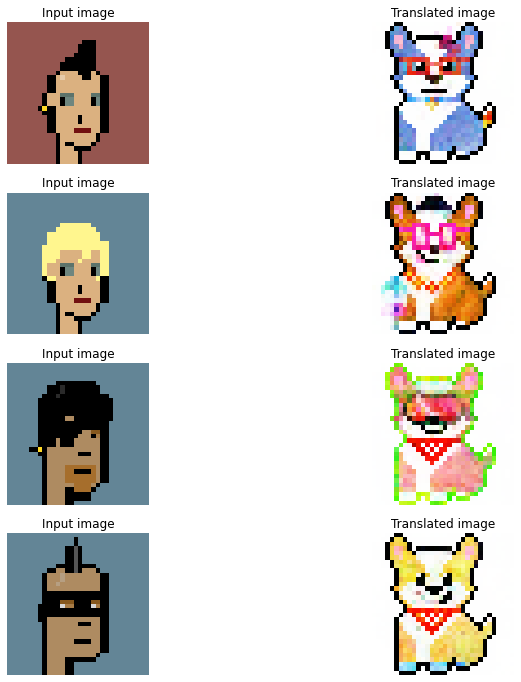

207/207 [==============================] - 70s 337ms/step - G_loss: 1.9593 - F_loss: 1.8884 - D_X_loss: 0.1413 - D_Y_loss: 0.1419
Epoch 106/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9826 - F_loss: 1.9268 - D_X_loss: 0.1314 - D_Y_loss: 0.1407

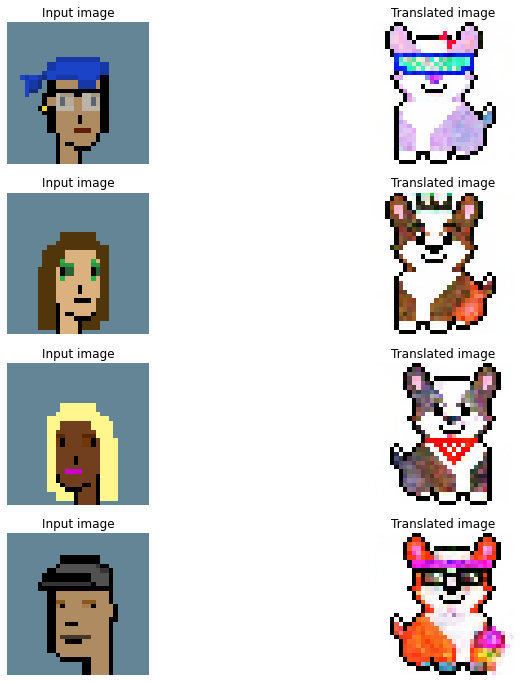

207/207 [==============================] - 70s 336ms/step - G_loss: 1.9769 - F_loss: 1.9254 - D_X_loss: 0.1310 - D_Y_loss: 0.1431
Epoch 107/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9685 - F_loss: 1.7766 - D_X_loss: 0.1400 - D_Y_loss: 0.1464

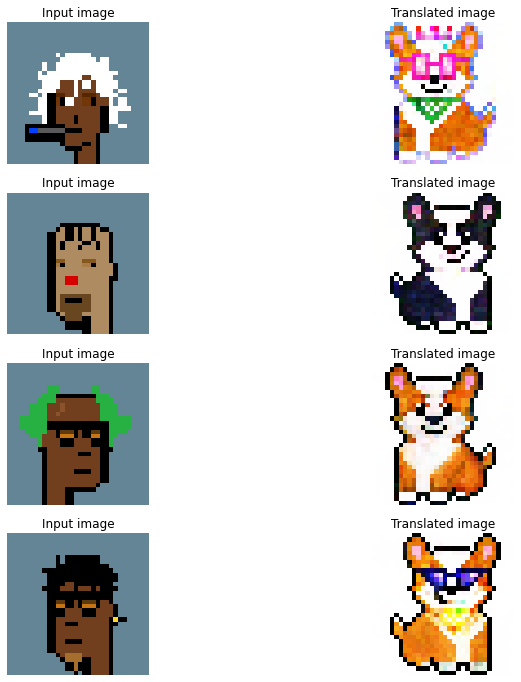

207/207 [==============================] - 69s 336ms/step - G_loss: 1.9759 - F_loss: 1.7745 - D_X_loss: 0.1396 - D_Y_loss: 0.1457
Epoch 108/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9676 - F_loss: 1.8342 - D_X_loss: 0.1398 - D_Y_loss: 0.1408

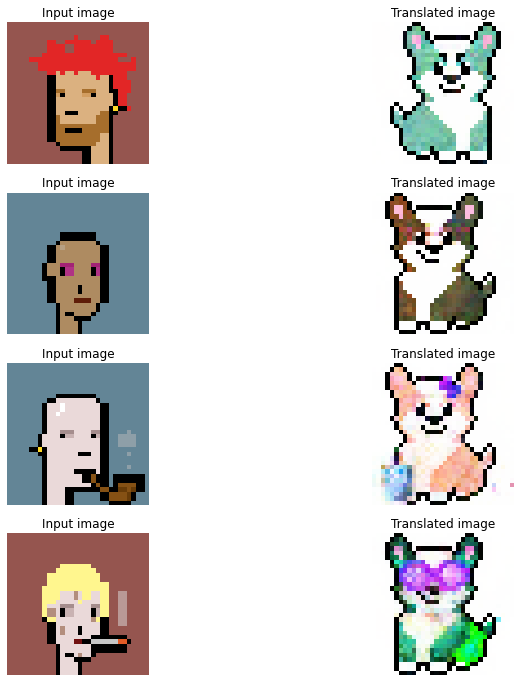

207/207 [==============================] - 70s 337ms/step - G_loss: 1.9702 - F_loss: 1.8298 - D_X_loss: 0.1408 - D_Y_loss: 0.1401
Epoch 109/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9423 - F_loss: 1.7860 - D_X_loss: 0.1405 - D_Y_loss: 0.1441

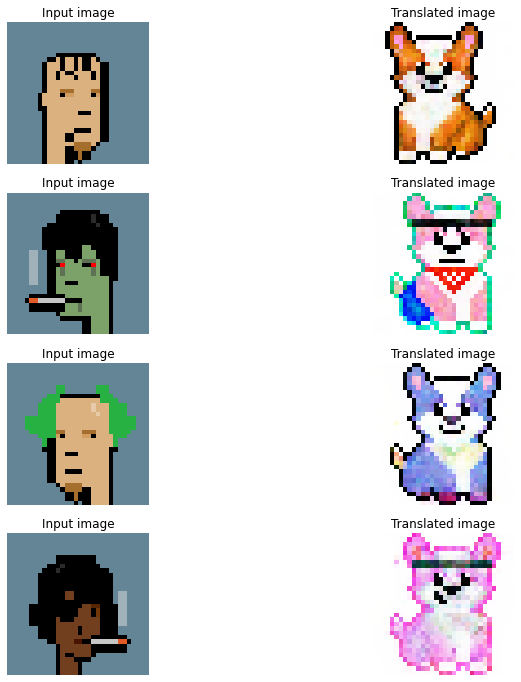

207/207 [==============================] - 69s 334ms/step - G_loss: 1.9405 - F_loss: 1.7857 - D_X_loss: 0.1407 - D_Y_loss: 0.1447
Epoch 110/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9263 - F_loss: 1.8995 - D_X_loss: 0.1381 - D_Y_loss: 0.1427

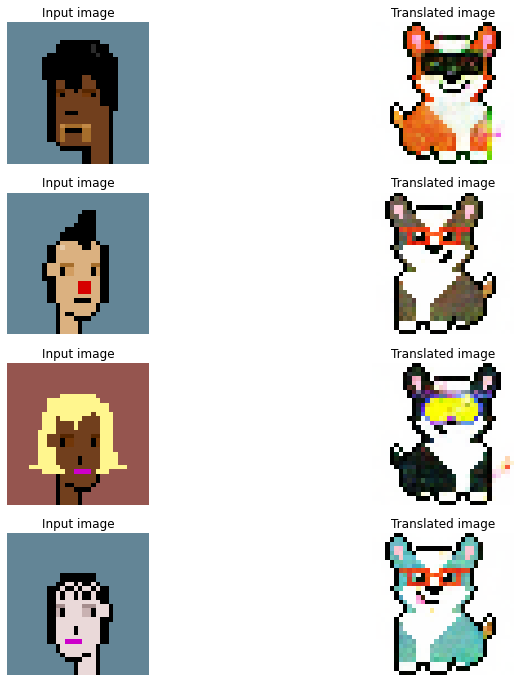

207/207 [==============================] - 70s 338ms/step - G_loss: 1.9246 - F_loss: 1.8939 - D_X_loss: 0.1387 - D_Y_loss: 0.1424
Epoch 111/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8863 - F_loss: 1.8403 - D_X_loss: 0.1359 - D_Y_loss: 0.1509

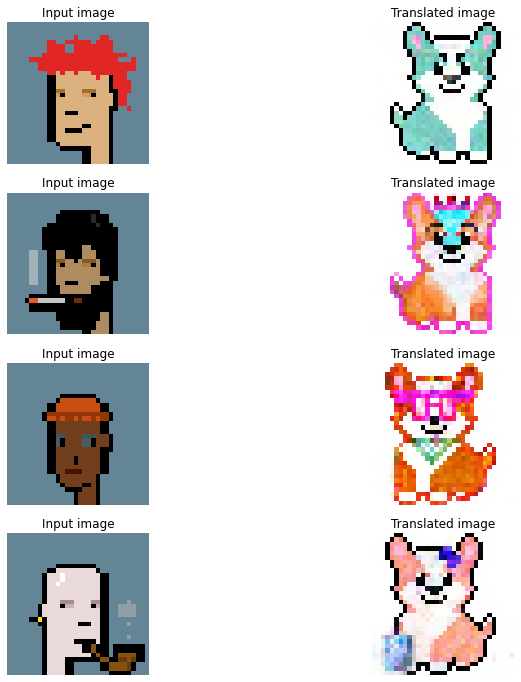

207/207 [==============================] - 69s 335ms/step - G_loss: 1.8876 - F_loss: 1.8362 - D_X_loss: 0.1364 - D_Y_loss: 0.1509
Epoch 112/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8894 - F_loss: 1.7767 - D_X_loss: 0.1420 - D_Y_loss: 0.1473

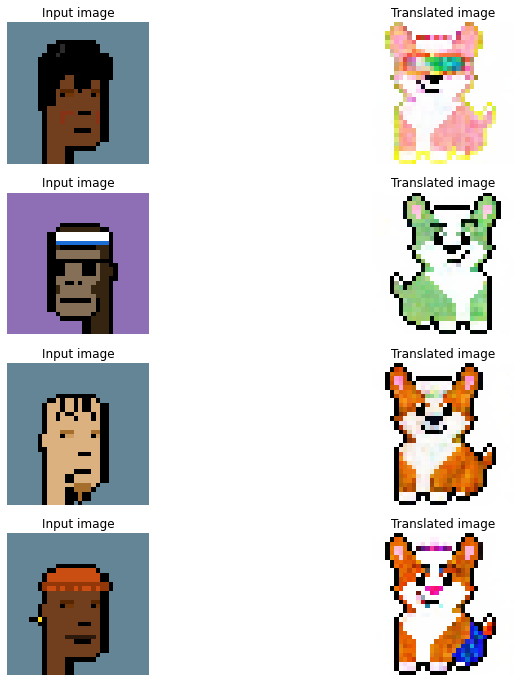

207/207 [==============================] - 69s 335ms/step - G_loss: 1.8833 - F_loss: 1.7736 - D_X_loss: 0.1417 - D_Y_loss: 0.1493
Epoch 113/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9090 - F_loss: 1.8692 - D_X_loss: 0.1441 - D_Y_loss: 0.1487

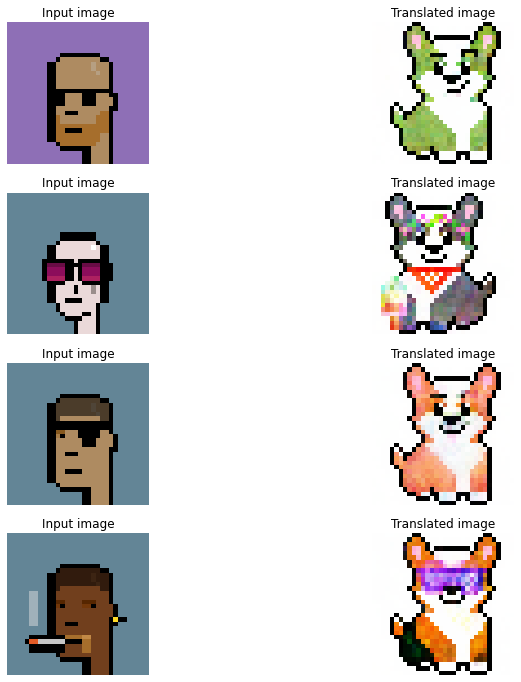

207/207 [==============================] - 70s 337ms/step - G_loss: 1.9143 - F_loss: 1.8698 - D_X_loss: 0.1439 - D_Y_loss: 0.1482
Epoch 114/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9253 - F_loss: 1.7849 - D_X_loss: 0.1362 - D_Y_loss: 0.1568

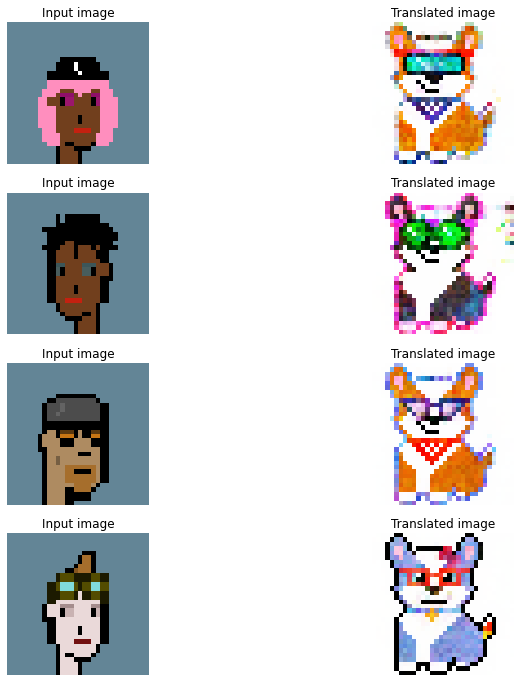

207/207 [==============================] - 70s 336ms/step - G_loss: 1.9239 - F_loss: 1.7799 - D_X_loss: 0.1364 - D_Y_loss: 0.1581
Epoch 115/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8201 - F_loss: 1.7716 - D_X_loss: 0.1535 - D_Y_loss: 0.1578

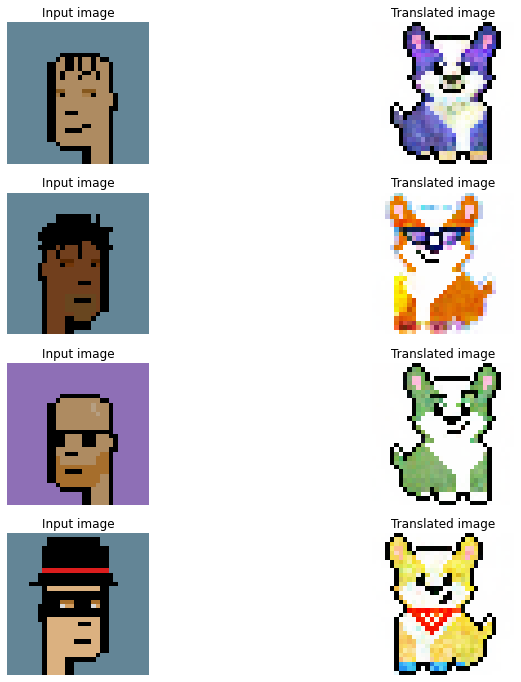

207/207 [==============================] - 70s 336ms/step - G_loss: 1.8150 - F_loss: 1.7681 - D_X_loss: 0.1540 - D_Y_loss: 0.1587
Epoch 116/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8243 - F_loss: 1.7026 - D_X_loss: 0.1540 - D_Y_loss: 0.1550

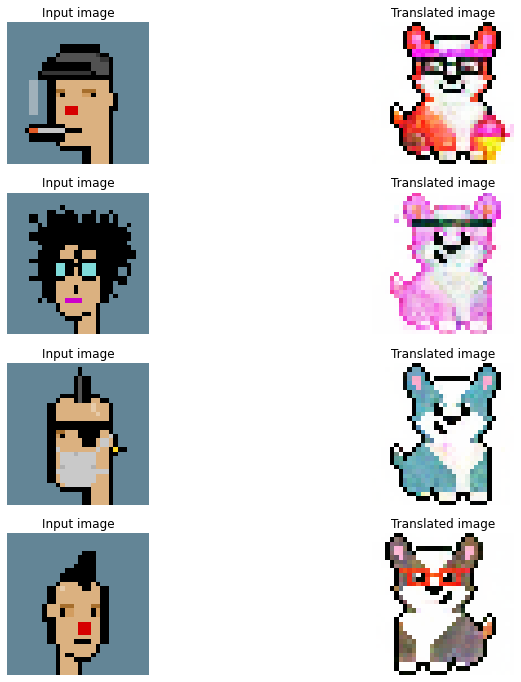

207/207 [==============================] - 70s 337ms/step - G_loss: 1.8217 - F_loss: 1.7084 - D_X_loss: 0.1533 - D_Y_loss: 0.1552
Epoch 117/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8602 - F_loss: 1.7464 - D_X_loss: 0.1400 - D_Y_loss: 0.1519

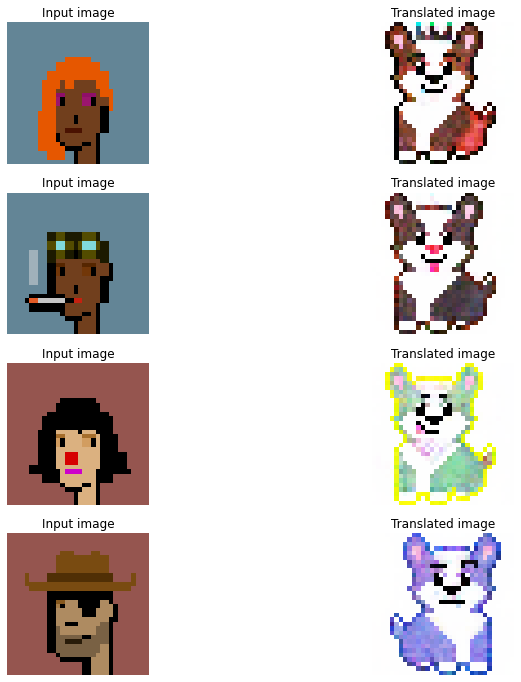

207/207 [==============================] - 70s 337ms/step - G_loss: 1.8555 - F_loss: 1.7481 - D_X_loss: 0.1400 - D_Y_loss: 0.1535
Epoch 118/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8752 - F_loss: 1.7178 - D_X_loss: 0.1510 - D_Y_loss: 0.1510

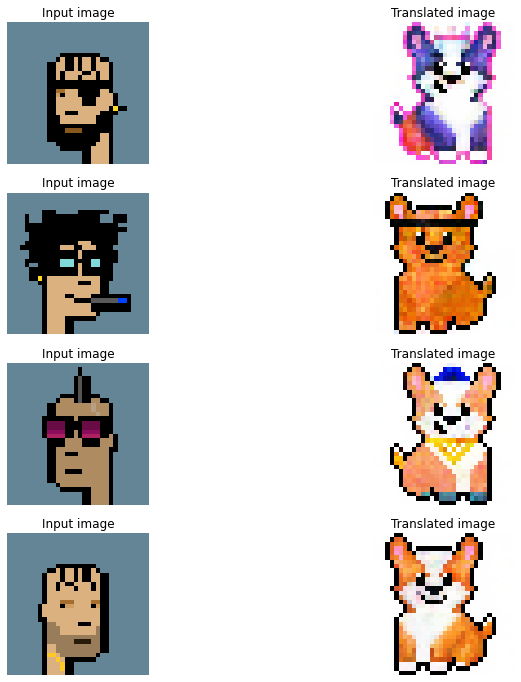

207/207 [==============================] - 70s 337ms/step - G_loss: 1.8729 - F_loss: 1.7168 - D_X_loss: 0.1507 - D_Y_loss: 0.1521
Epoch 119/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8293 - F_loss: 1.7081 - D_X_loss: 0.1451 - D_Y_loss: 0.1547

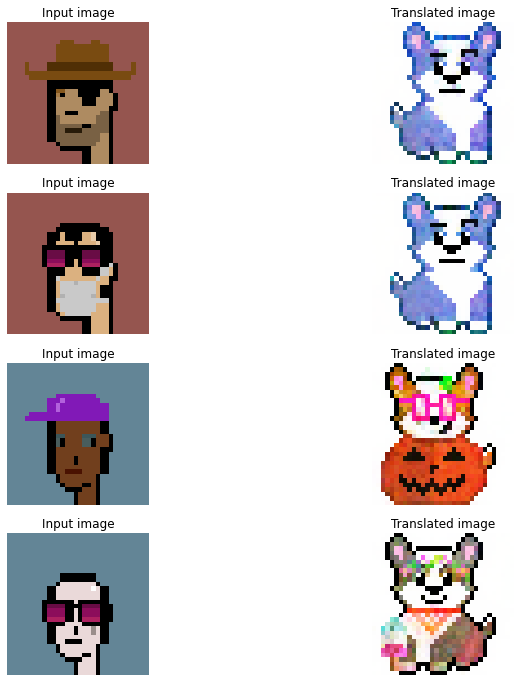

207/207 [==============================] - 70s 338ms/step - G_loss: 1.8354 - F_loss: 1.7084 - D_X_loss: 0.1448 - D_Y_loss: 0.1541
Epoch 120/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8315 - F_loss: 1.7547 - D_X_loss: 0.1434 - D_Y_loss: 0.1501

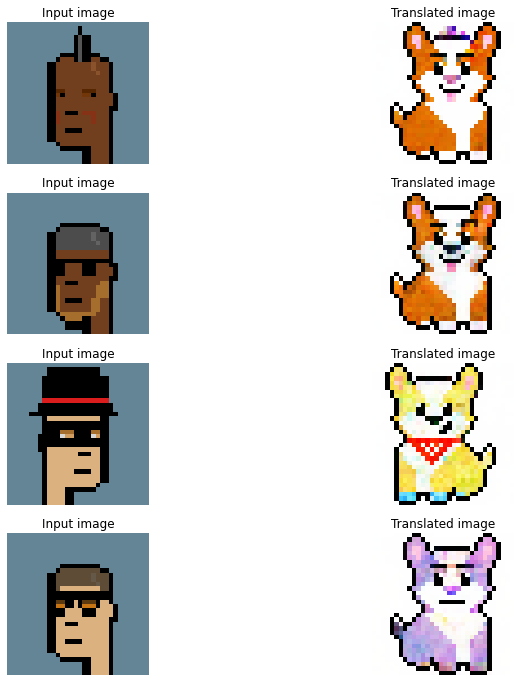

207/207 [==============================] - 70s 337ms/step - G_loss: 1.8304 - F_loss: 1.7704 - D_X_loss: 0.1428 - D_Y_loss: 0.1495
Epoch 121/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8706 - F_loss: 1.8116 - D_X_loss: 0.1377 - D_Y_loss: 0.1446

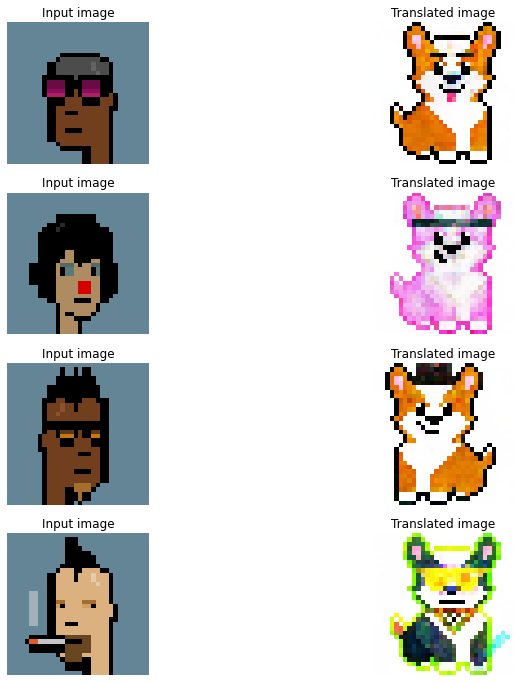

207/207 [==============================] - 70s 336ms/step - G_loss: 1.8704 - F_loss: 1.8091 - D_X_loss: 0.1380 - D_Y_loss: 0.1459
Epoch 122/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8108 - F_loss: 1.8319 - D_X_loss: 0.1414 - D_Y_loss: 0.1592

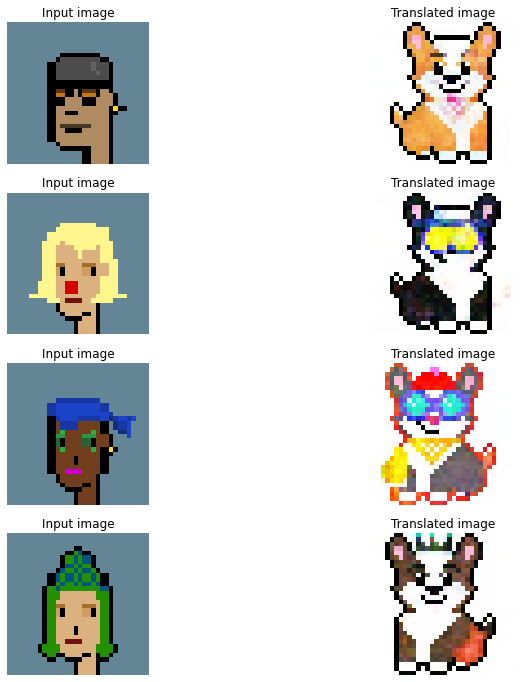

207/207 [==============================] - 70s 338ms/step - G_loss: 1.8100 - F_loss: 1.8435 - D_X_loss: 0.1415 - D_Y_loss: 0.1593
Epoch 123/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8455 - F_loss: 1.7715 - D_X_loss: 0.1442 - D_Y_loss: 0.1550

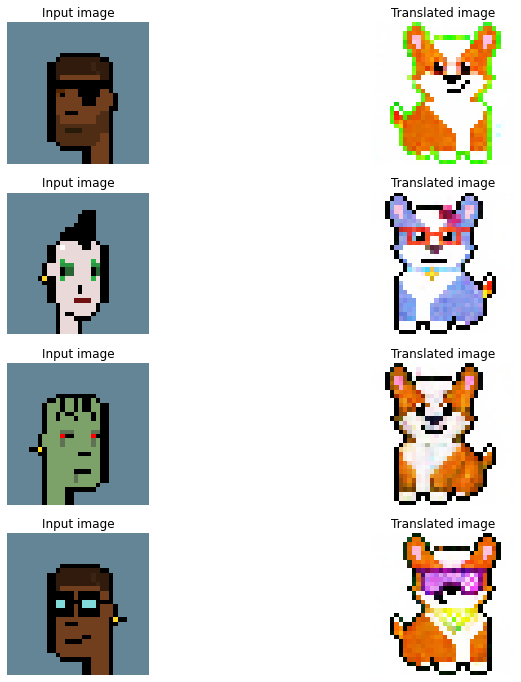

207/207 [==============================] - 69s 334ms/step - G_loss: 1.8470 - F_loss: 1.7910 - D_X_loss: 0.1436 - D_Y_loss: 0.1544
Epoch 124/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8061 - F_loss: 1.7326 - D_X_loss: 0.1478 - D_Y_loss: 0.1583

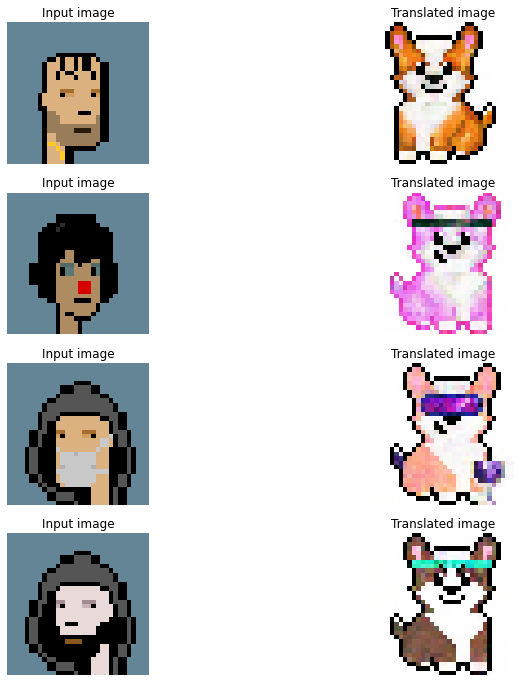

207/207 [==============================] - 70s 337ms/step - G_loss: 1.8035 - F_loss: 1.7313 - D_X_loss: 0.1473 - D_Y_loss: 0.1588
Epoch 125/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8541 - F_loss: 1.6529 - D_X_loss: 0.1550 - D_Y_loss: 0.1589

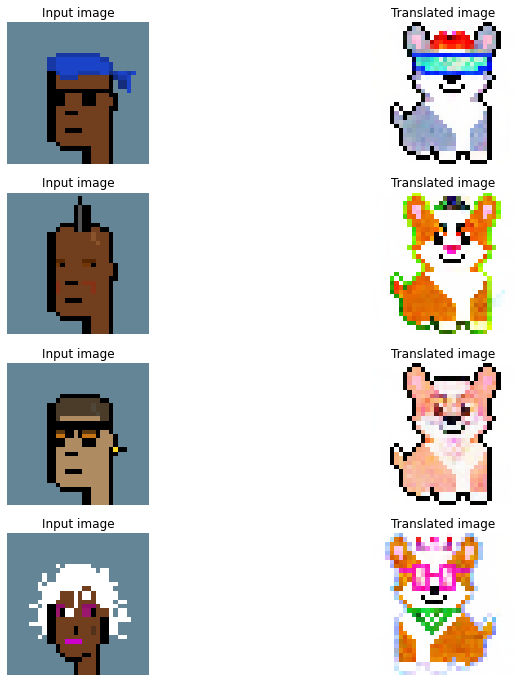

207/207 [==============================] - 70s 336ms/step - G_loss: 1.8598 - F_loss: 1.6514 - D_X_loss: 0.1547 - D_Y_loss: 0.1587
Epoch 126/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8474 - F_loss: 1.8414 - D_X_loss: 0.1352 - D_Y_loss: 0.1553

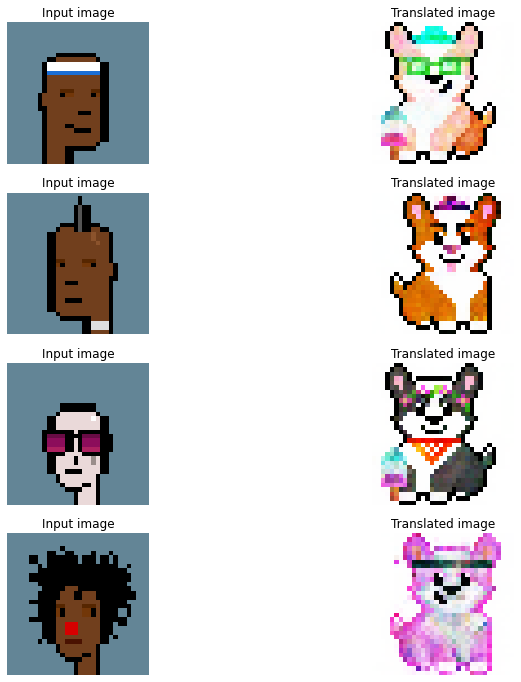

207/207 [==============================] - 69s 335ms/step - G_loss: 1.8450 - F_loss: 1.8527 - D_X_loss: 0.1360 - D_Y_loss: 0.1563
Epoch 127/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8150 - F_loss: 1.9142 - D_X_loss: 0.1331 - D_Y_loss: 0.1566

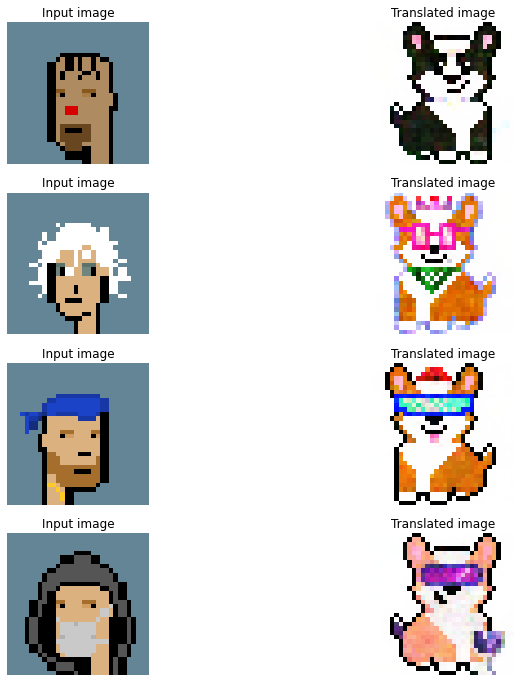

207/207 [==============================] - 70s 336ms/step - G_loss: 1.8184 - F_loss: 1.9148 - D_X_loss: 0.1326 - D_Y_loss: 0.1559
Epoch 128/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7762 - F_loss: 1.7204 - D_X_loss: 0.1501 - D_Y_loss: 0.1561

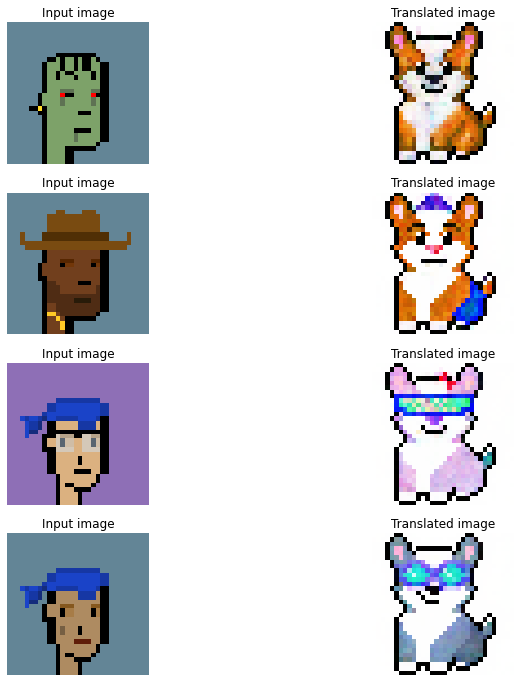

207/207 [==============================] - 70s 336ms/step - G_loss: 1.7756 - F_loss: 1.7168 - D_X_loss: 0.1508 - D_Y_loss: 0.1555
Epoch 129/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7415 - F_loss: 1.6395 - D_X_loss: 0.1534 - D_Y_loss: 0.1629

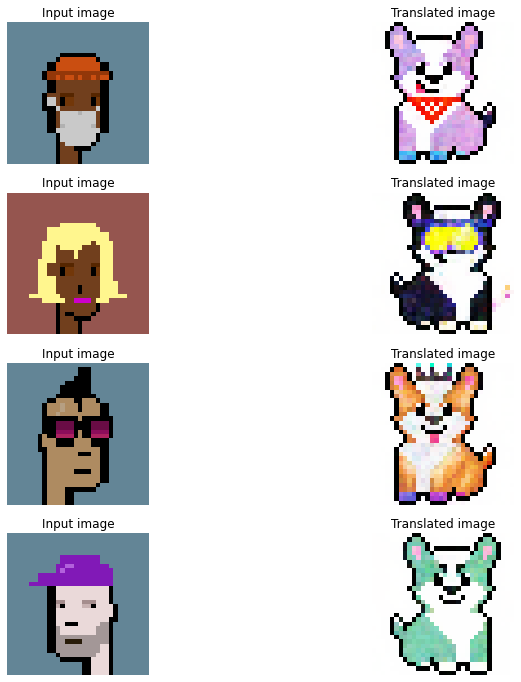

207/207 [==============================] - 69s 334ms/step - G_loss: 1.7372 - F_loss: 1.6395 - D_X_loss: 0.1532 - D_Y_loss: 0.1632
Epoch 130/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7427 - F_loss: 1.6774 - D_X_loss: 0.1467 - D_Y_loss: 0.1592

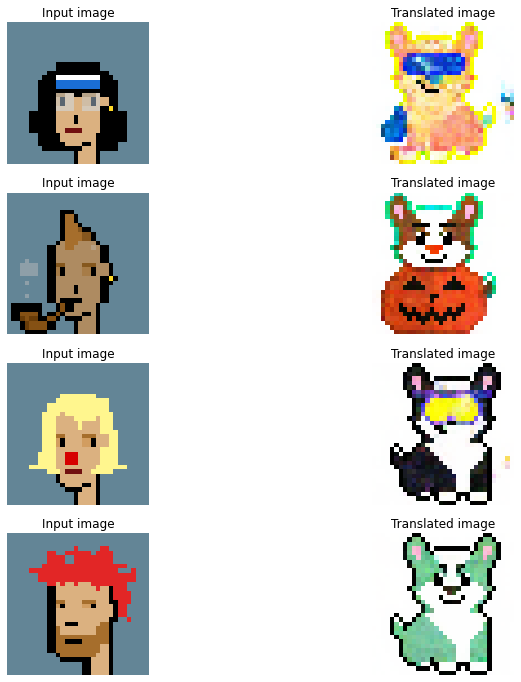

207/207 [==============================] - 70s 337ms/step - G_loss: 1.7380 - F_loss: 1.6739 - D_X_loss: 0.1474 - D_Y_loss: 0.1596
Epoch 131/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7315 - F_loss: 1.7318 - D_X_loss: 0.1460 - D_Y_loss: 0.1624

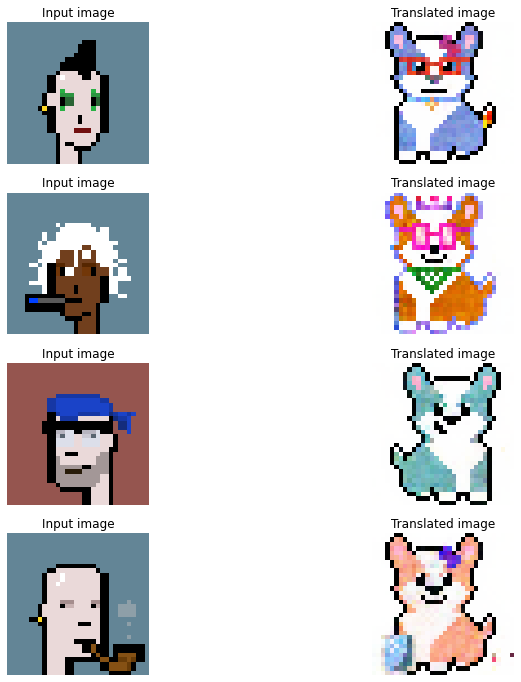

207/207 [==============================] - 69s 335ms/step - G_loss: 1.7268 - F_loss: 1.7286 - D_X_loss: 0.1466 - D_Y_loss: 0.1632
Epoch 132/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7602 - F_loss: 1.7323 - D_X_loss: 0.1529 - D_Y_loss: 0.1581

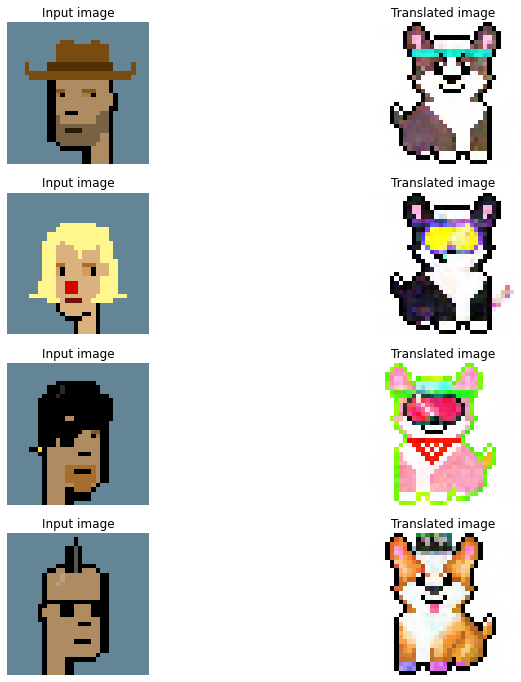

207/207 [==============================] - 70s 337ms/step - G_loss: 1.7563 - F_loss: 1.7260 - D_X_loss: 0.1540 - D_Y_loss: 0.1593
Epoch 133/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7306 - F_loss: 1.5715 - D_X_loss: 0.1611 - D_Y_loss: 0.1642

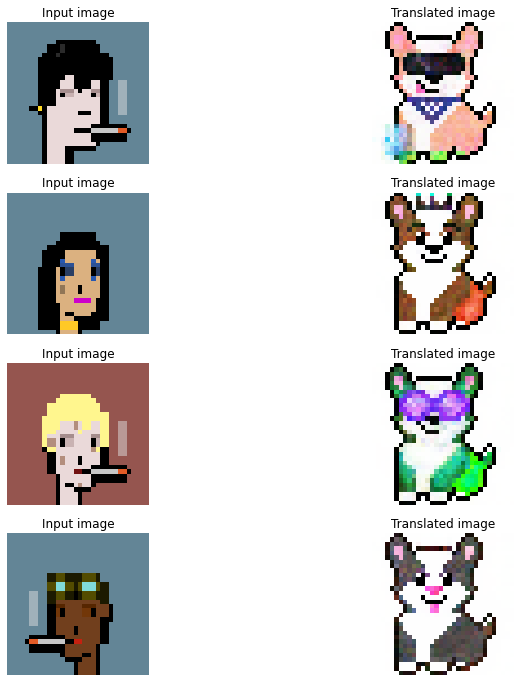

207/207 [==============================] - 70s 337ms/step - G_loss: 1.7309 - F_loss: 1.5812 - D_X_loss: 0.1605 - D_Y_loss: 0.1637
Epoch 134/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6987 - F_loss: 1.7195 - D_X_loss: 0.1479 - D_Y_loss: 0.1629

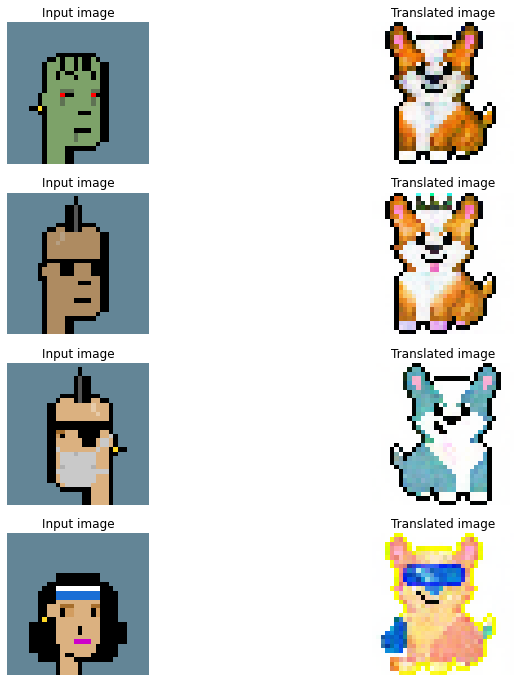

207/207 [==============================] - 70s 336ms/step - G_loss: 1.6957 - F_loss: 1.7154 - D_X_loss: 0.1485 - D_Y_loss: 0.1632
Epoch 135/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7437 - F_loss: 1.7140 - D_X_loss: 0.1486 - D_Y_loss: 0.1565

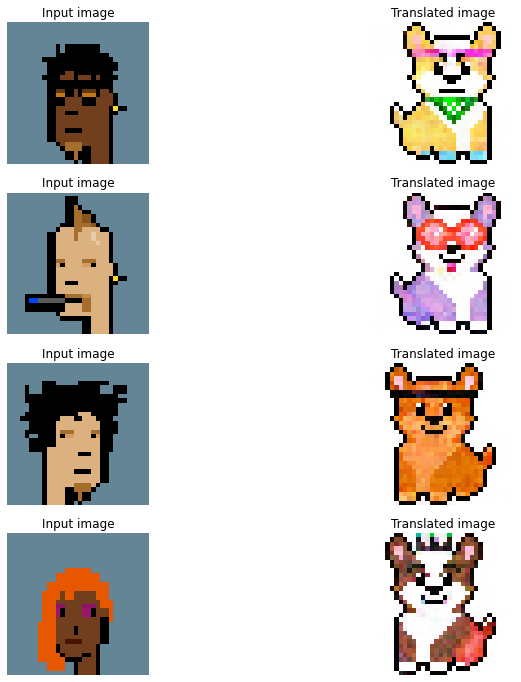

207/207 [==============================] - 70s 336ms/step - G_loss: 1.7401 - F_loss: 1.7111 - D_X_loss: 0.1495 - D_Y_loss: 0.1568
Epoch 136/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7300 - F_loss: 1.6446 - D_X_loss: 0.1546 - D_Y_loss: 0.1583

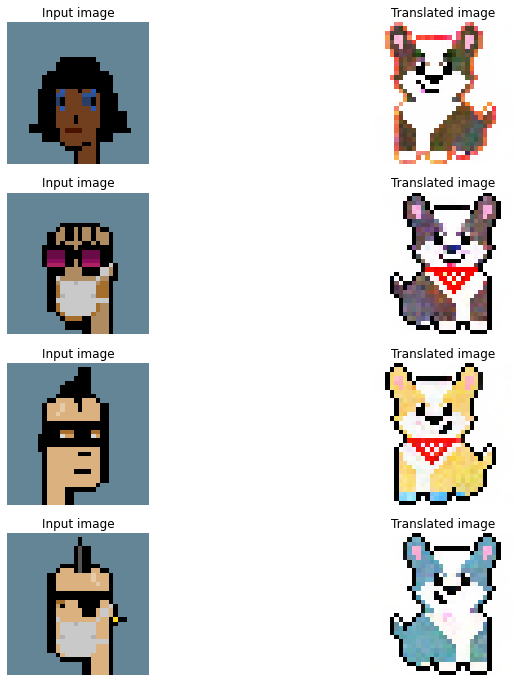

207/207 [==============================] - 69s 335ms/step - G_loss: 1.7282 - F_loss: 1.6409 - D_X_loss: 0.1560 - D_Y_loss: 0.1591
Epoch 137/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7357 - F_loss: 1.7167 - D_X_loss: 0.1438 - D_Y_loss: 0.1526

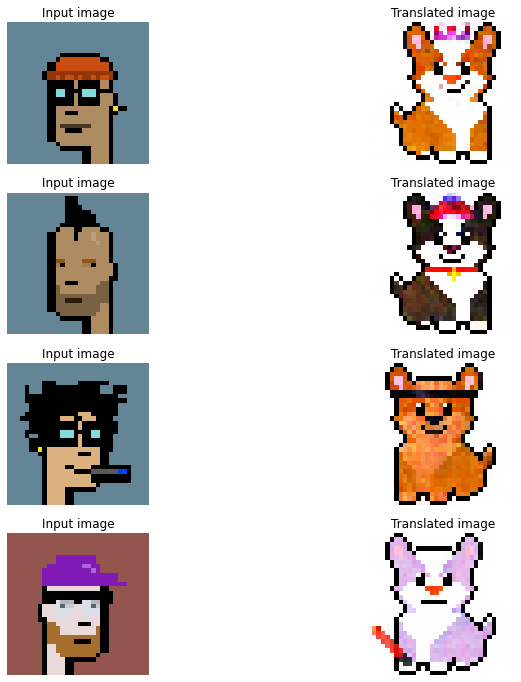

207/207 [==============================] - 70s 336ms/step - G_loss: 1.7343 - F_loss: 1.7123 - D_X_loss: 0.1450 - D_Y_loss: 0.1520
Epoch 138/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7321 - F_loss: 1.6621 - D_X_loss: 0.1600 - D_Y_loss: 0.1658

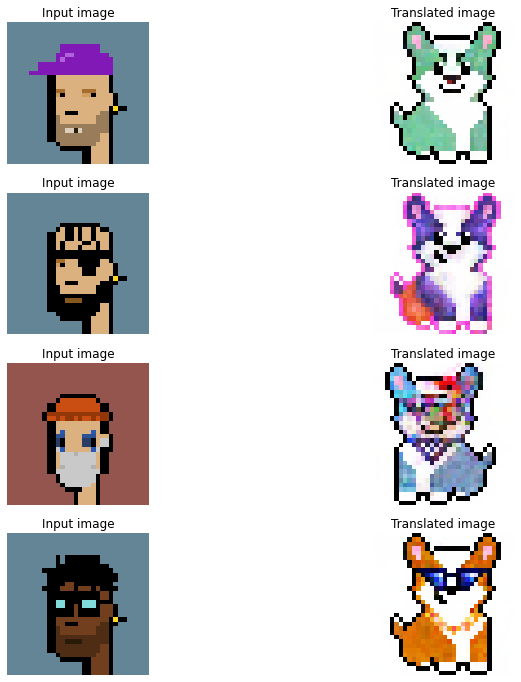

207/207 [==============================] - 69s 334ms/step - G_loss: 1.7296 - F_loss: 1.6604 - D_X_loss: 0.1601 - D_Y_loss: 0.1665
Epoch 139/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6664 - F_loss: 1.6691 - D_X_loss: 0.1528 - D_Y_loss: 0.1645

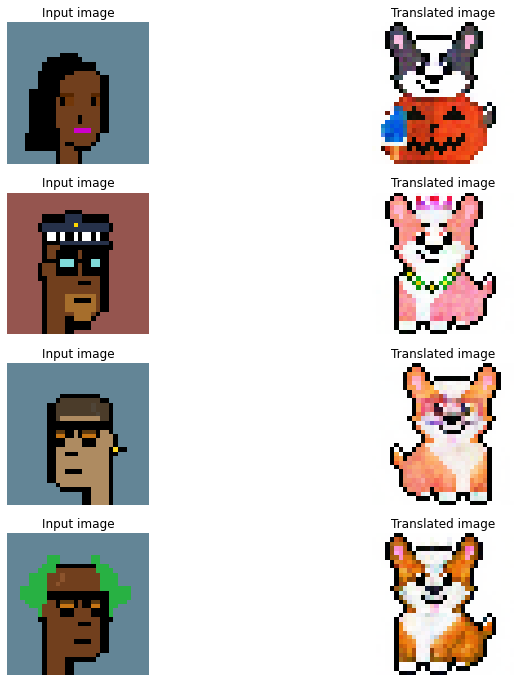

207/207 [==============================] - 69s 335ms/step - G_loss: 1.6778 - F_loss: 1.6645 - D_X_loss: 0.1535 - D_Y_loss: 0.1638
Epoch 140/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7017 - F_loss: 1.6870 - D_X_loss: 0.1566 - D_Y_loss: 0.1616

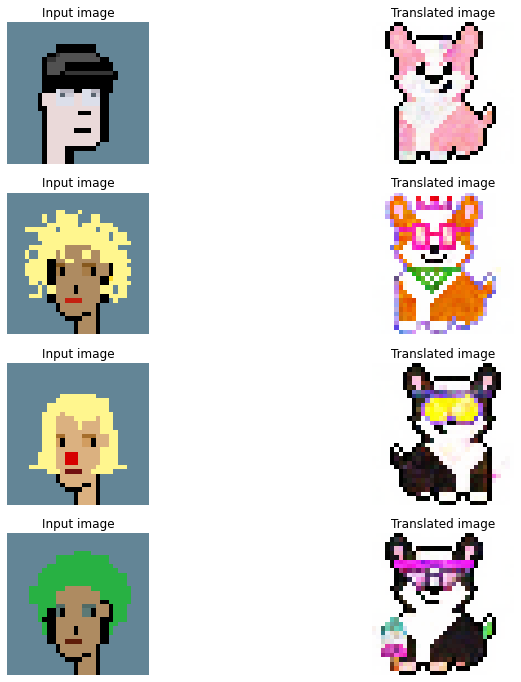

207/207 [==============================] - 69s 335ms/step - G_loss: 1.7048 - F_loss: 1.6837 - D_X_loss: 0.1574 - D_Y_loss: 0.1617
Epoch 141/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7009 - F_loss: 1.6720 - D_X_loss: 0.1500 - D_Y_loss: 0.1631

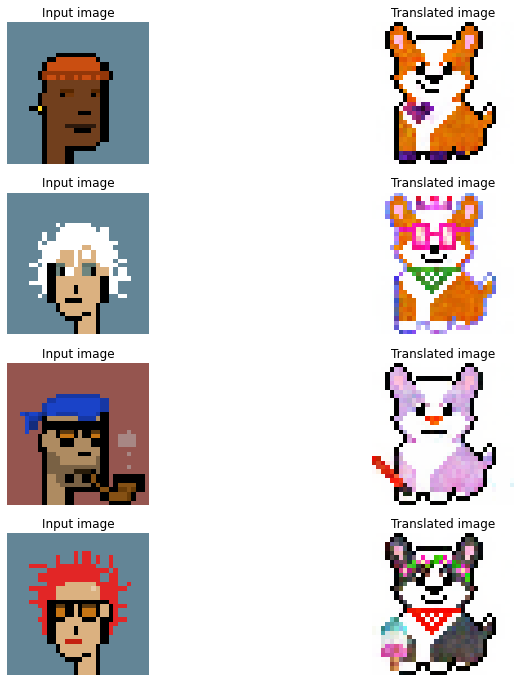

207/207 [==============================] - 69s 336ms/step - G_loss: 1.6989 - F_loss: 1.6725 - D_X_loss: 0.1494 - D_Y_loss: 0.1629
Epoch 142/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6885 - F_loss: 1.6319 - D_X_loss: 0.1524 - D_Y_loss: 0.1682

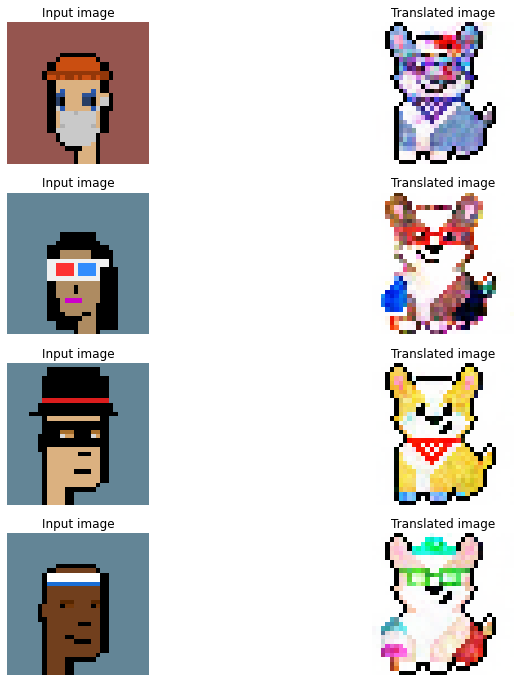

207/207 [==============================] - 69s 334ms/step - G_loss: 1.6865 - F_loss: 1.6335 - D_X_loss: 0.1525 - D_Y_loss: 0.1681
Epoch 143/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6706 - F_loss: 1.6945 - D_X_loss: 0.1509 - D_Y_loss: 0.1666

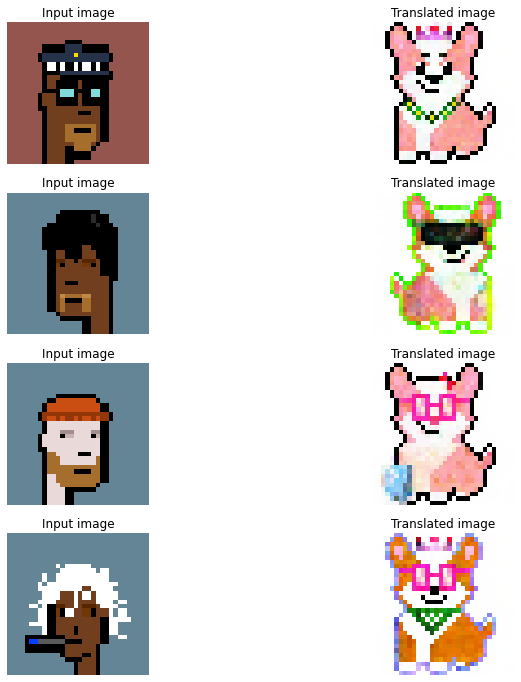

207/207 [==============================] - 70s 336ms/step - G_loss: 1.6677 - F_loss: 1.6942 - D_X_loss: 0.1508 - D_Y_loss: 0.1668
Epoch 144/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6949 - F_loss: 1.6807 - D_X_loss: 0.1441 - D_Y_loss: 0.1625

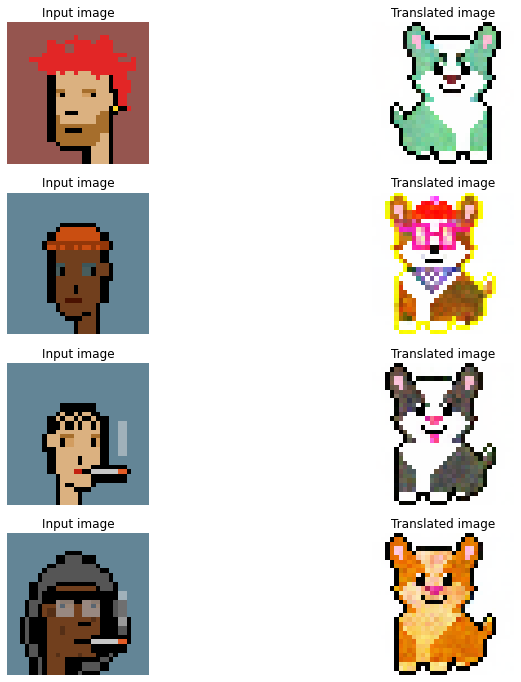

207/207 [==============================] - 70s 336ms/step - G_loss: 1.6909 - F_loss: 1.6911 - D_X_loss: 0.1437 - D_Y_loss: 0.1629
Epoch 145/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7038 - F_loss: 1.5753 - D_X_loss: 0.1555 - D_Y_loss: 0.1647

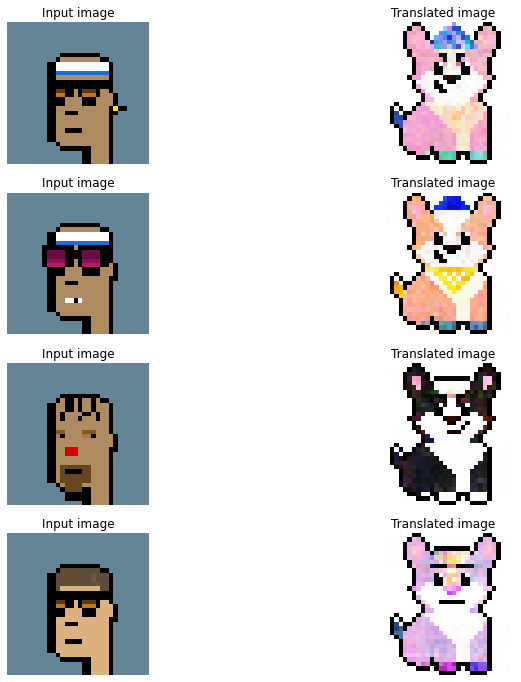

207/207 [==============================] - 70s 337ms/step - G_loss: 1.7042 - F_loss: 1.5699 - D_X_loss: 0.1562 - D_Y_loss: 0.1642
Epoch 146/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6371 - F_loss: 1.5923 - D_X_loss: 0.1550 - D_Y_loss: 0.1670

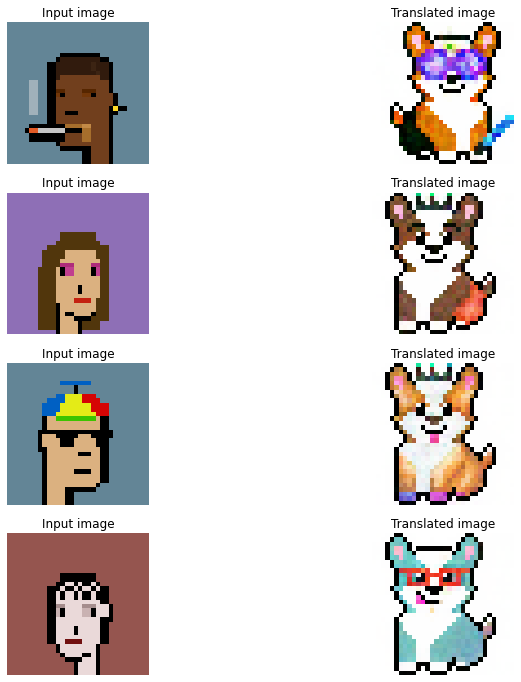

207/207 [==============================] - 69s 335ms/step - G_loss: 1.6354 - F_loss: 1.5887 - D_X_loss: 0.1555 - D_Y_loss: 0.1673
Epoch 147/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6663 - F_loss: 1.5709 - D_X_loss: 0.1584 - D_Y_loss: 0.1752

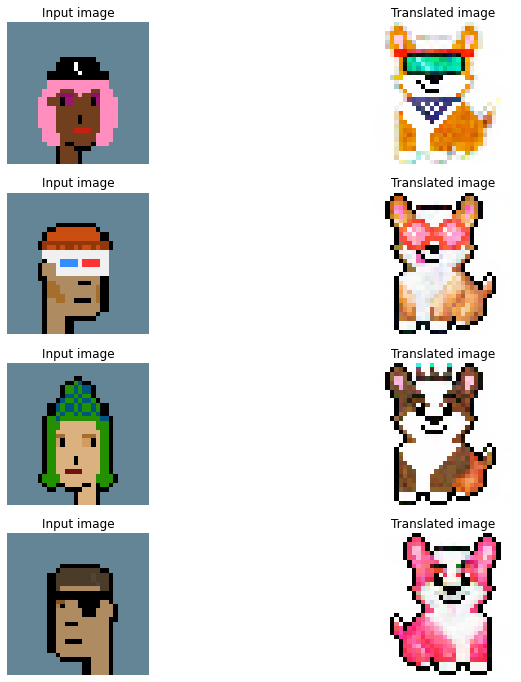

207/207 [==============================] - 70s 336ms/step - G_loss: 1.6626 - F_loss: 1.5825 - D_X_loss: 0.1578 - D_Y_loss: 0.1762
Epoch 148/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6176 - F_loss: 1.6675 - D_X_loss: 0.1513 - D_Y_loss: 0.1674

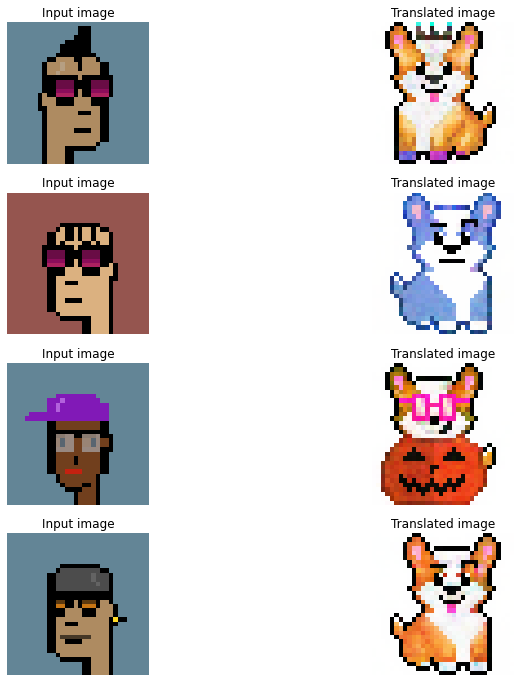

207/207 [==============================] - 69s 335ms/step - G_loss: 1.6149 - F_loss: 1.6645 - D_X_loss: 0.1520 - D_Y_loss: 0.1686
Epoch 149/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6428 - F_loss: 1.6069 - D_X_loss: 0.1497 - D_Y_loss: 0.1699

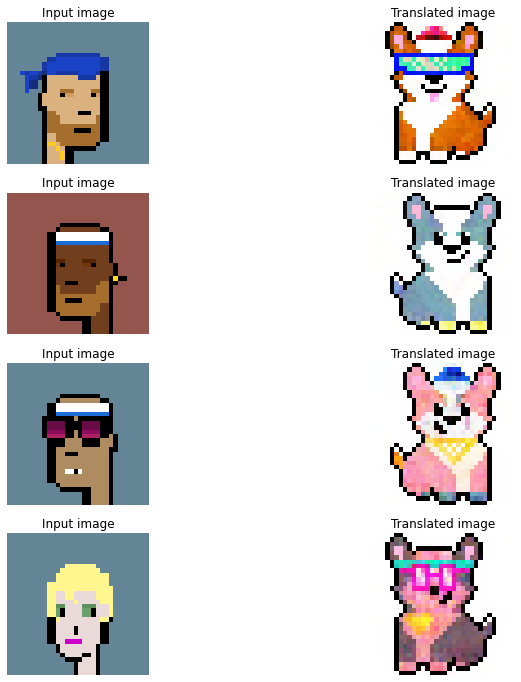

207/207 [==============================] - 69s 335ms/step - G_loss: 1.6409 - F_loss: 1.6017 - D_X_loss: 0.1509 - D_Y_loss: 0.1705
Epoch 150/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6604 - F_loss: 1.6348 - D_X_loss: 0.1541 - D_Y_loss: 0.1680

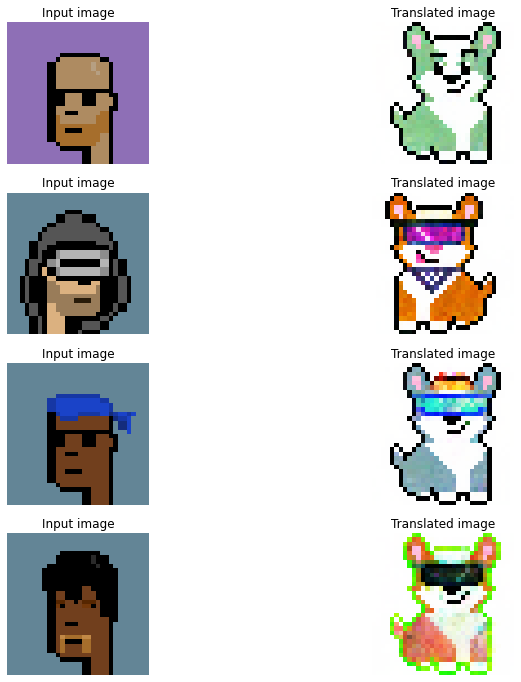

207/207 [==============================] - 69s 334ms/step - G_loss: 1.6663 - F_loss: 1.6437 - D_X_loss: 0.1534 - D_Y_loss: 0.1673
Epoch 151/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6640 - F_loss: 1.6075 - D_X_loss: 0.1608 - D_Y_loss: 0.1615

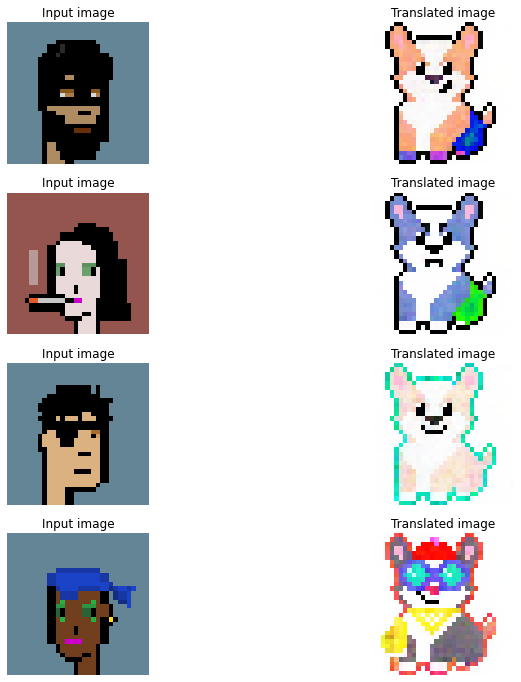

207/207 [==============================] - 69s 335ms/step - G_loss: 1.6646 - F_loss: 1.6085 - D_X_loss: 0.1601 - D_Y_loss: 0.1610
Epoch 152/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6094 - F_loss: 1.5459 - D_X_loss: 0.1555 - D_Y_loss: 0.1746

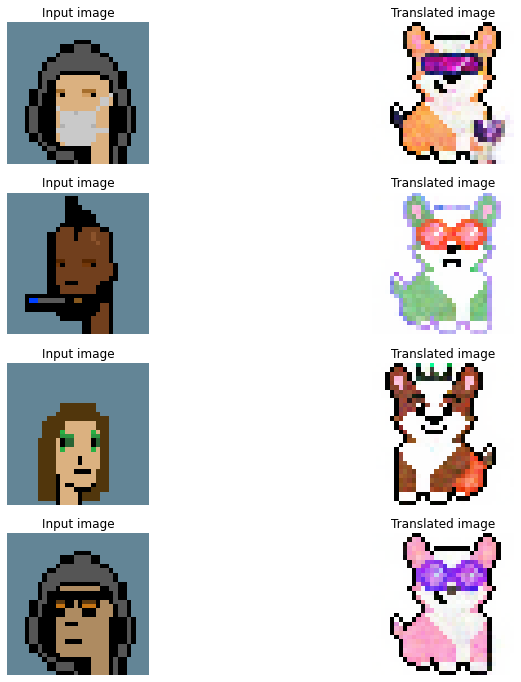

207/207 [==============================] - 70s 336ms/step - G_loss: 1.6079 - F_loss: 1.5491 - D_X_loss: 0.1562 - D_Y_loss: 0.1743
Epoch 153/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5893 - F_loss: 1.5343 - D_X_loss: 0.1654 - D_Y_loss: 0.1679

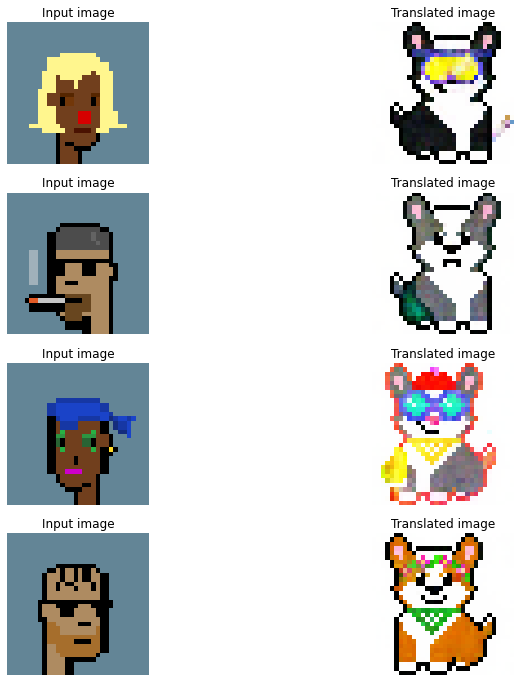

207/207 [==============================] - 70s 336ms/step - G_loss: 1.5933 - F_loss: 1.5318 - D_X_loss: 0.1654 - D_Y_loss: 0.1675
Epoch 154/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6018 - F_loss: 1.5699 - D_X_loss: 0.1561 - D_Y_loss: 0.1690

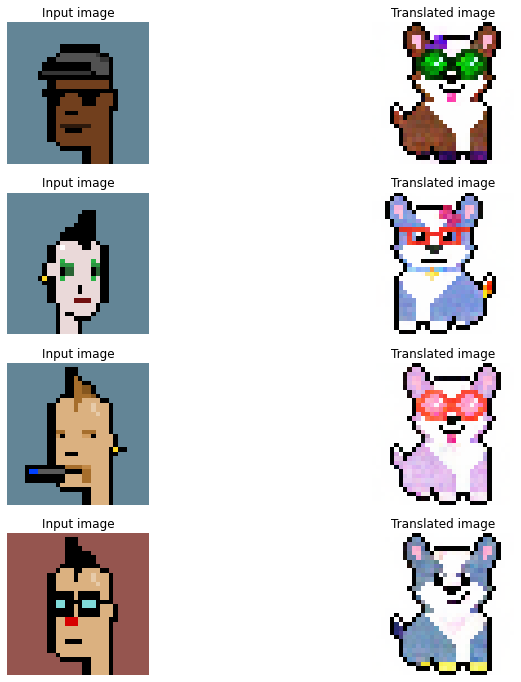

207/207 [==============================] - 69s 335ms/step - G_loss: 1.6012 - F_loss: 1.5659 - D_X_loss: 0.1569 - D_Y_loss: 0.1685
Epoch 155/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5768 - F_loss: 1.5665 - D_X_loss: 0.1571 - D_Y_loss: 0.1718

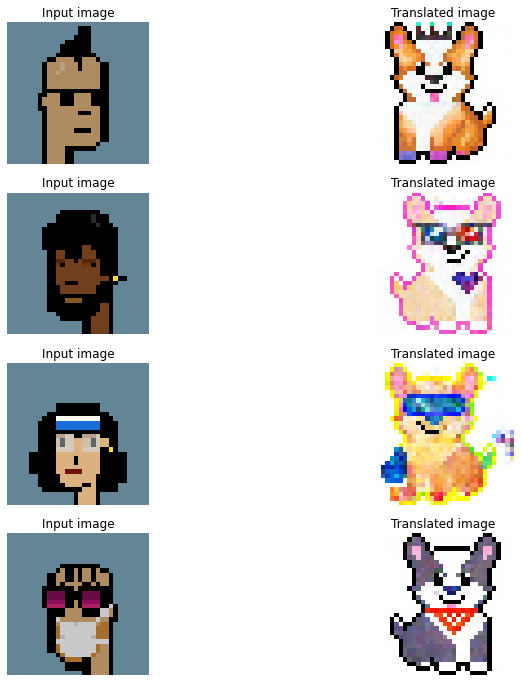

207/207 [==============================] - 69s 335ms/step - G_loss: 1.5752 - F_loss: 1.5695 - D_X_loss: 0.1576 - D_Y_loss: 0.1725
Epoch 156/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6068 - F_loss: 1.6055 - D_X_loss: 0.1519 - D_Y_loss: 0.1639

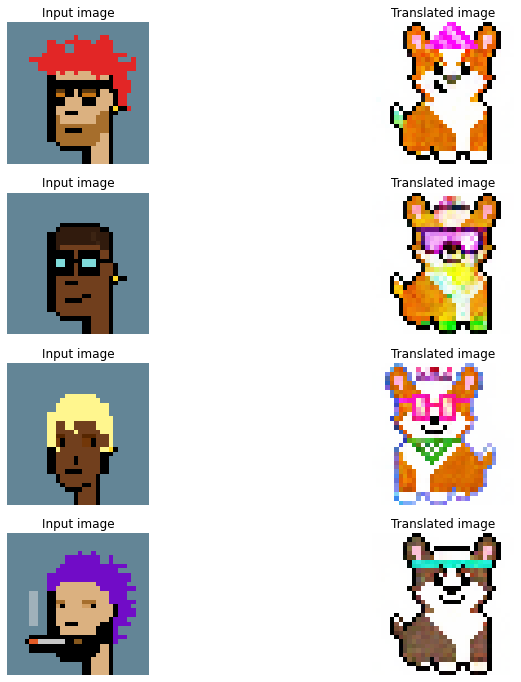

207/207 [==============================] - 69s 335ms/step - G_loss: 1.6069 - F_loss: 1.6009 - D_X_loss: 0.1521 - D_Y_loss: 0.1644
Epoch 157/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6466 - F_loss: 1.6260 - D_X_loss: 0.1538 - D_Y_loss: 0.1736

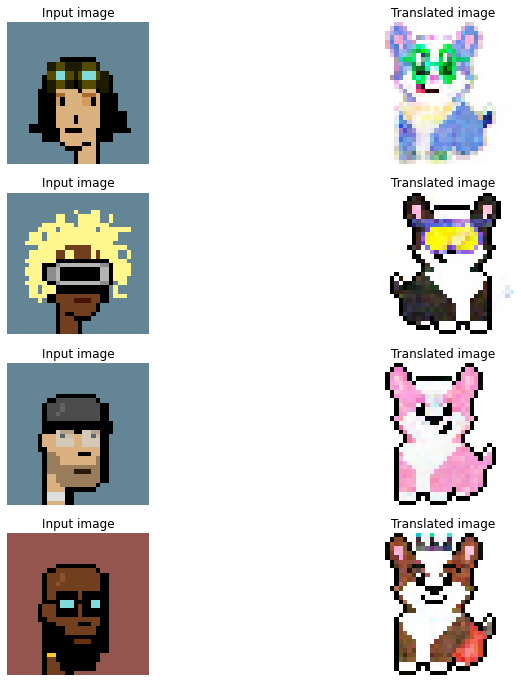

207/207 [==============================] - 69s 335ms/step - G_loss: 1.6440 - F_loss: 1.6232 - D_X_loss: 0.1546 - D_Y_loss: 0.1745
Epoch 158/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5998 - F_loss: 1.5771 - D_X_loss: 0.1583 - D_Y_loss: 0.1702

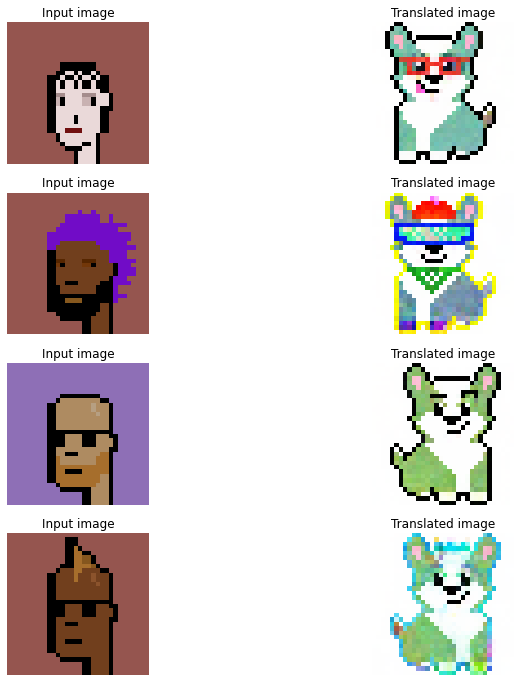

207/207 [==============================] - 69s 335ms/step - G_loss: 1.5952 - F_loss: 1.5731 - D_X_loss: 0.1597 - D_Y_loss: 0.1712
Epoch 159/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5932 - F_loss: 1.5831 - D_X_loss: 0.1545 - D_Y_loss: 0.1676

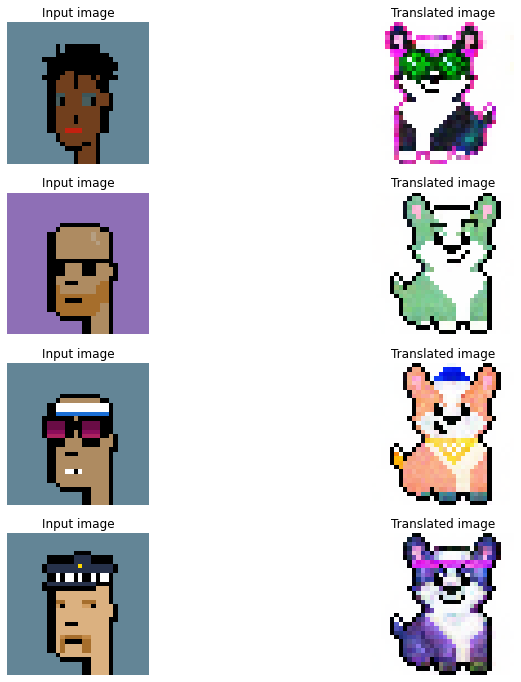

207/207 [==============================] - 70s 336ms/step - G_loss: 1.5922 - F_loss: 1.5841 - D_X_loss: 0.1539 - D_Y_loss: 0.1684
Epoch 160/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6118 - F_loss: 1.5997 - D_X_loss: 0.1570 - D_Y_loss: 0.1707

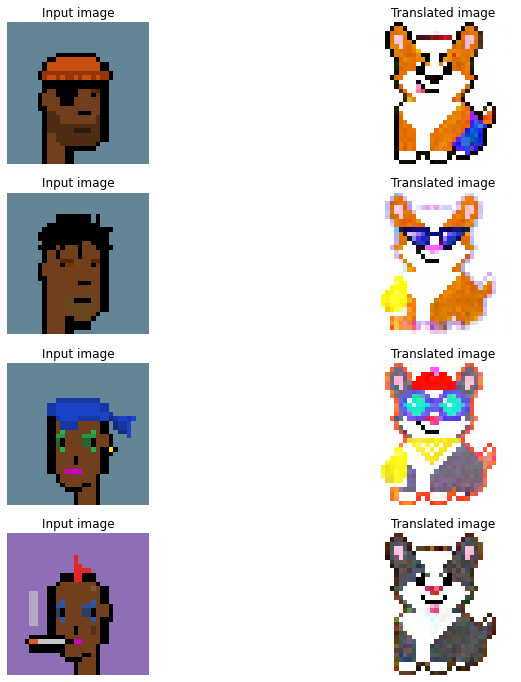

207/207 [==============================] - 69s 335ms/step - G_loss: 1.6124 - F_loss: 1.5975 - D_X_loss: 0.1567 - D_Y_loss: 0.1702
Epoch 161/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5966 - F_loss: 1.4904 - D_X_loss: 0.1577 - D_Y_loss: 0.1725

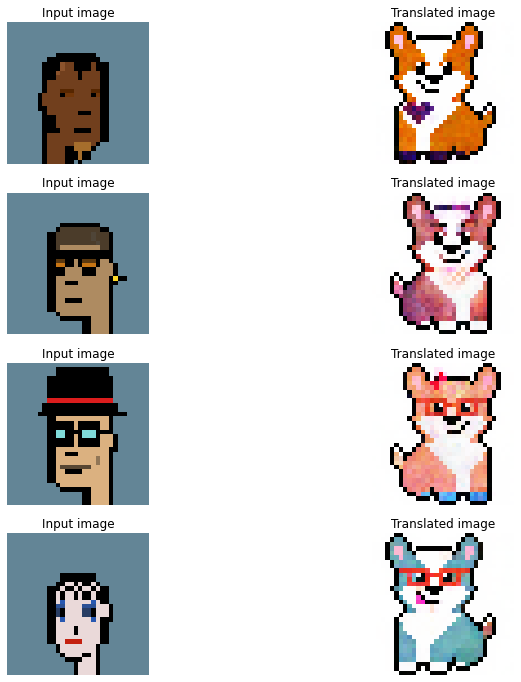

207/207 [==============================] - 70s 337ms/step - G_loss: 1.5955 - F_loss: 1.4931 - D_X_loss: 0.1570 - D_Y_loss: 0.1730
Epoch 162/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6479 - F_loss: 1.5363 - D_X_loss: 0.1487 - D_Y_loss: 0.1653

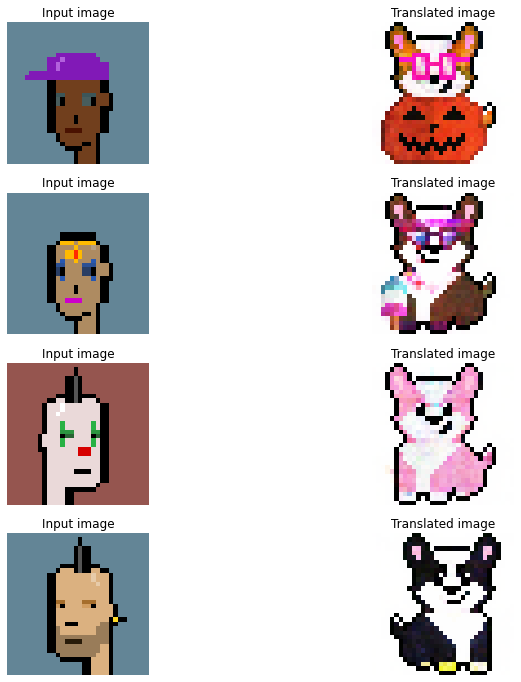

207/207 [==============================] - 69s 335ms/step - G_loss: 1.6517 - F_loss: 1.5332 - D_X_loss: 0.1482 - D_Y_loss: 0.1648
Epoch 163/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7034 - F_loss: 1.6922 - D_X_loss: 0.1462 - D_Y_loss: 0.1645

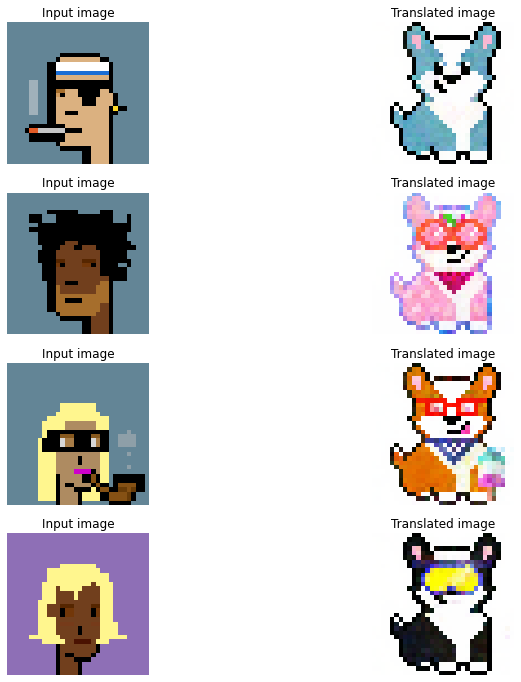

207/207 [==============================] - 69s 335ms/step - G_loss: 1.7009 - F_loss: 1.7001 - D_X_loss: 0.1456 - D_Y_loss: 0.1654
Epoch 164/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6196 - F_loss: 1.7103 - D_X_loss: 0.1447 - D_Y_loss: 0.1685

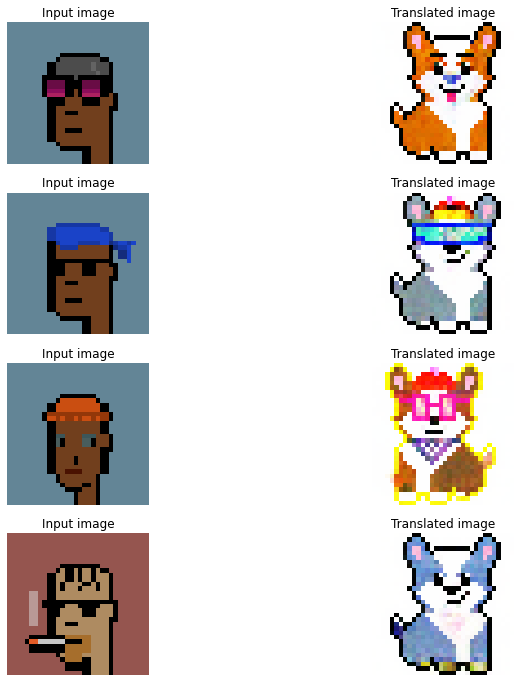

207/207 [==============================] - 70s 338ms/step - G_loss: 1.6198 - F_loss: 1.7173 - D_X_loss: 0.1442 - D_Y_loss: 0.1678
Epoch 165/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5596 - F_loss: 1.6843 - D_X_loss: 0.1551 - D_Y_loss: 0.1704

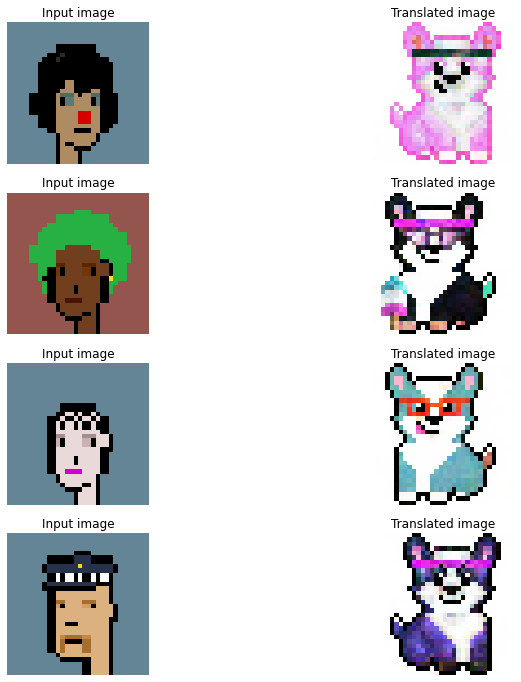

207/207 [==============================] - 69s 333ms/step - G_loss: 1.5571 - F_loss: 1.6829 - D_X_loss: 0.1564 - D_Y_loss: 0.1704
Epoch 166/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5845 - F_loss: 1.6138 - D_X_loss: 0.1468 - D_Y_loss: 0.1681

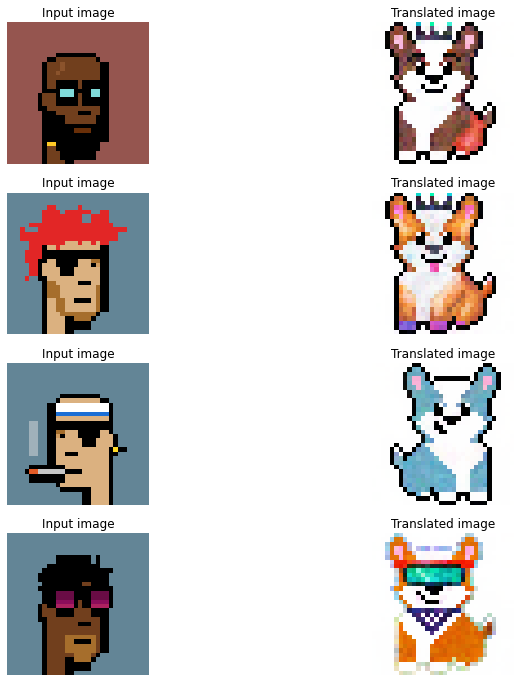

207/207 [==============================] - 69s 334ms/step - G_loss: 1.5827 - F_loss: 1.6149 - D_X_loss: 0.1461 - D_Y_loss: 0.1685
Epoch 167/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5313 - F_loss: 1.5619 - D_X_loss: 0.1613 - D_Y_loss: 0.1769

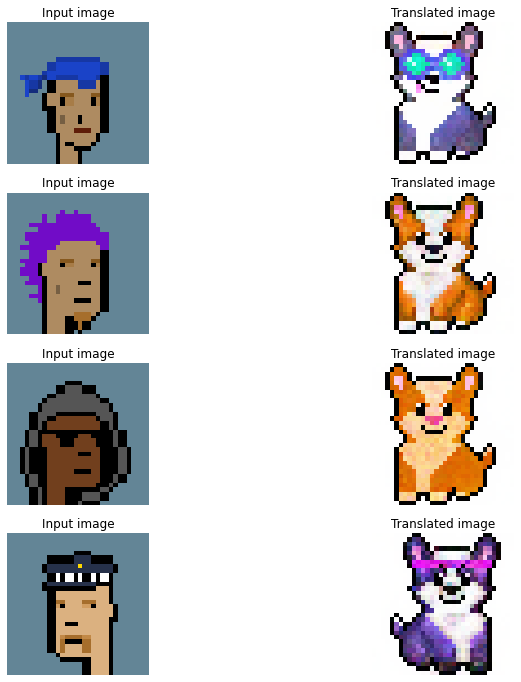

207/207 [==============================] - 69s 335ms/step - G_loss: 1.5305 - F_loss: 1.5632 - D_X_loss: 0.1609 - D_Y_loss: 0.1776
Epoch 168/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5340 - F_loss: 1.6410 - D_X_loss: 0.1494 - D_Y_loss: 0.1707

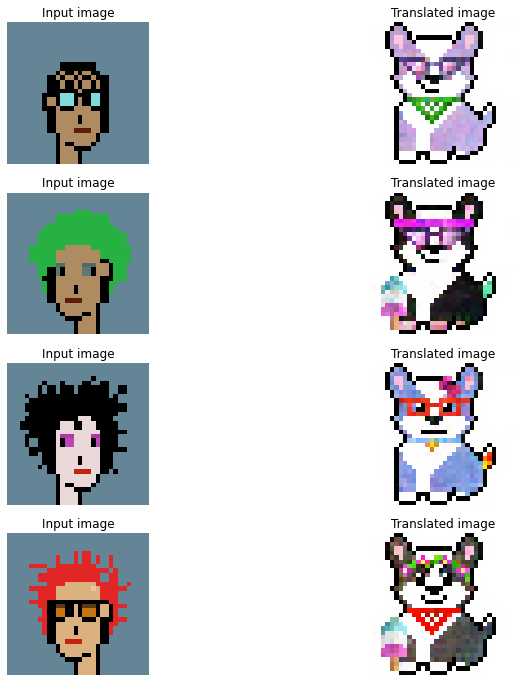

207/207 [==============================] - 70s 337ms/step - G_loss: 1.5333 - F_loss: 1.6382 - D_X_loss: 0.1499 - D_Y_loss: 0.1702
Epoch 169/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5245 - F_loss: 1.5719 - D_X_loss: 0.1579 - D_Y_loss: 0.1743

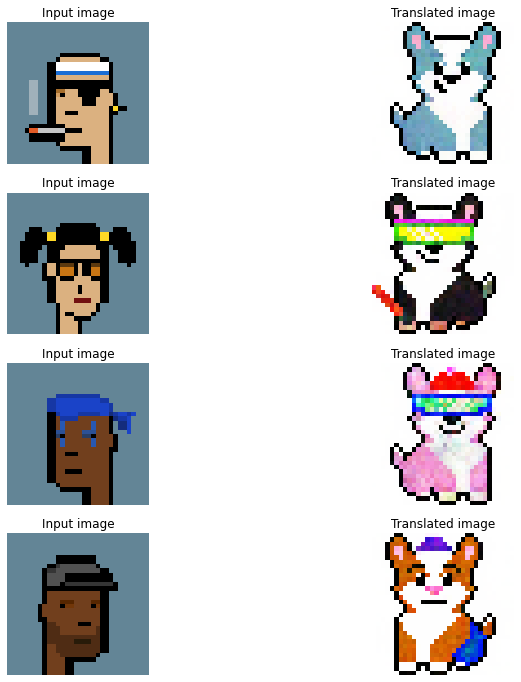

207/207 [==============================] - 70s 337ms/step - G_loss: 1.5230 - F_loss: 1.5676 - D_X_loss: 0.1575 - D_Y_loss: 0.1756
Epoch 170/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4945 - F_loss: 1.6057 - D_X_loss: 0.1541 - D_Y_loss: 0.1772

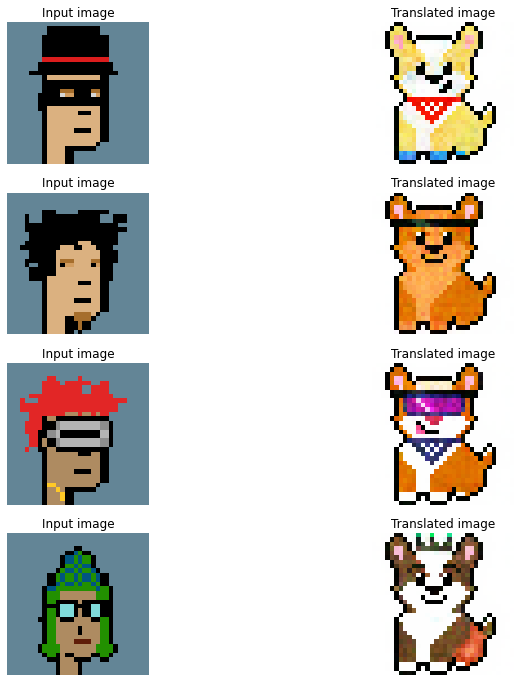

207/207 [==============================] - 70s 336ms/step - G_loss: 1.4960 - F_loss: 1.6065 - D_X_loss: 0.1536 - D_Y_loss: 0.1767
Epoch 171/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5198 - F_loss: 1.5357 - D_X_loss: 0.1599 - D_Y_loss: 0.1761

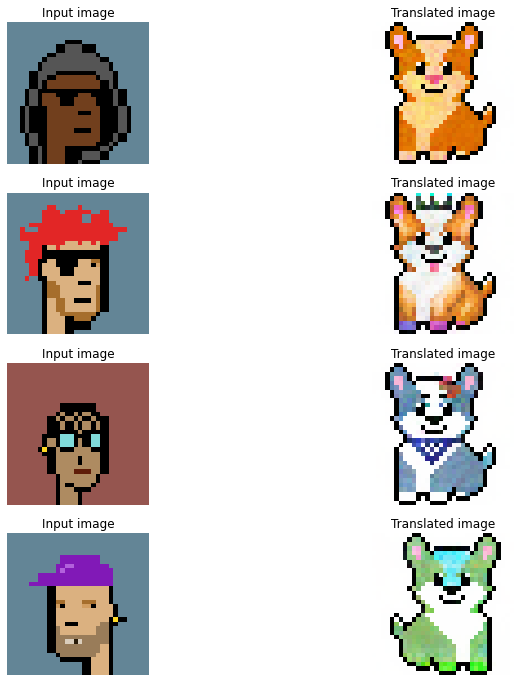

207/207 [==============================] - 70s 337ms/step - G_loss: 1.5175 - F_loss: 1.5321 - D_X_loss: 0.1600 - D_Y_loss: 0.1762
Epoch 172/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5496 - F_loss: 1.5014 - D_X_loss: 0.1696 - D_Y_loss: 0.1757

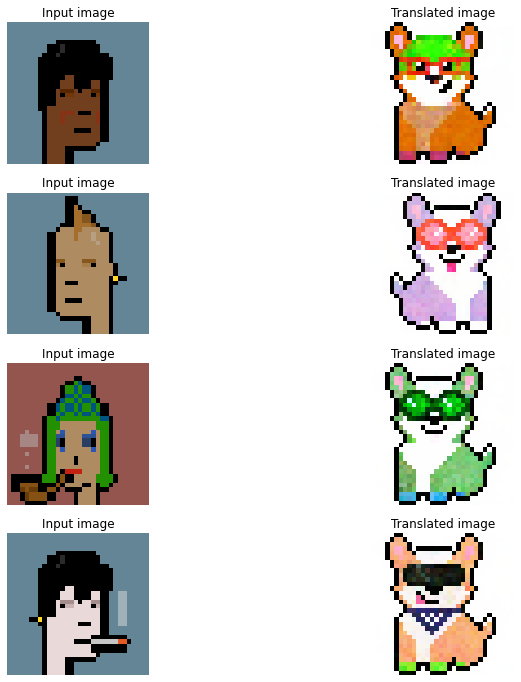

207/207 [==============================] - 70s 337ms/step - G_loss: 1.5512 - F_loss: 1.4993 - D_X_loss: 0.1697 - D_Y_loss: 0.1762
Epoch 173/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5631 - F_loss: 1.5653 - D_X_loss: 0.1553 - D_Y_loss: 0.1699

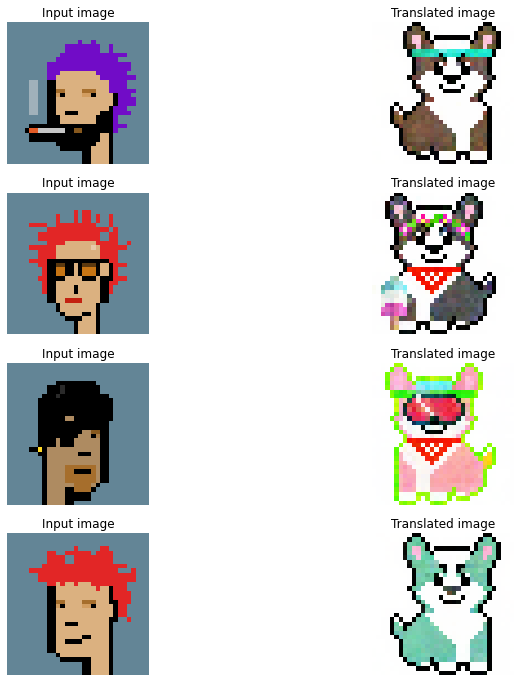

207/207 [==============================] - 69s 335ms/step - G_loss: 1.5622 - F_loss: 1.5613 - D_X_loss: 0.1559 - D_Y_loss: 0.1701
Epoch 174/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5432 - F_loss: 1.6019 - D_X_loss: 0.1511 - D_Y_loss: 0.1714

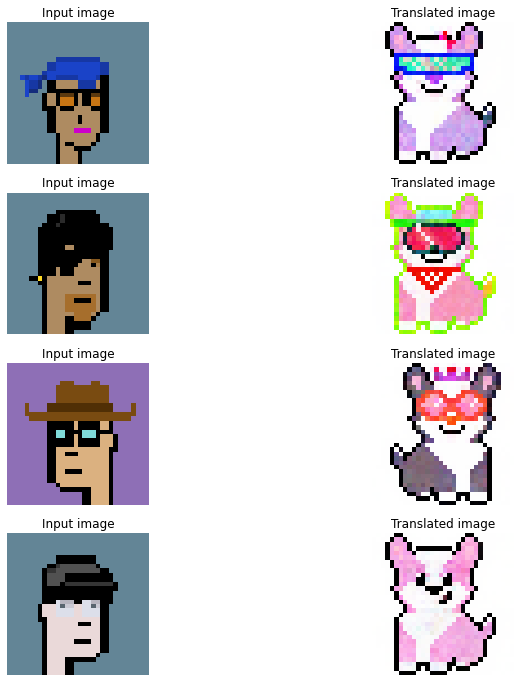

207/207 [==============================] - 73s 353ms/step - G_loss: 1.5513 - F_loss: 1.5984 - D_X_loss: 0.1517 - D_Y_loss: 0.1711
Epoch 175/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5123 - F_loss: 1.5758 - D_X_loss: 0.1511 - D_Y_loss: 0.1739

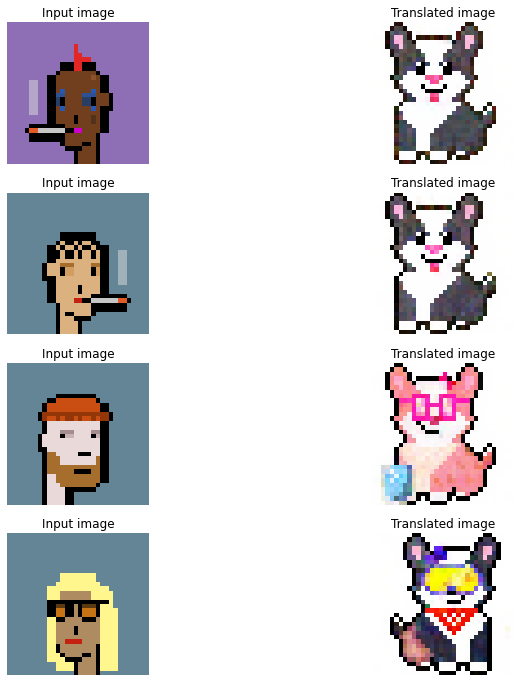

207/207 [==============================] - 74s 355ms/step - G_loss: 1.5077 - F_loss: 1.5715 - D_X_loss: 0.1517 - D_Y_loss: 0.1748
Epoch 176/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5080 - F_loss: 1.6502 - D_X_loss: 0.1392 - D_Y_loss: 0.1768

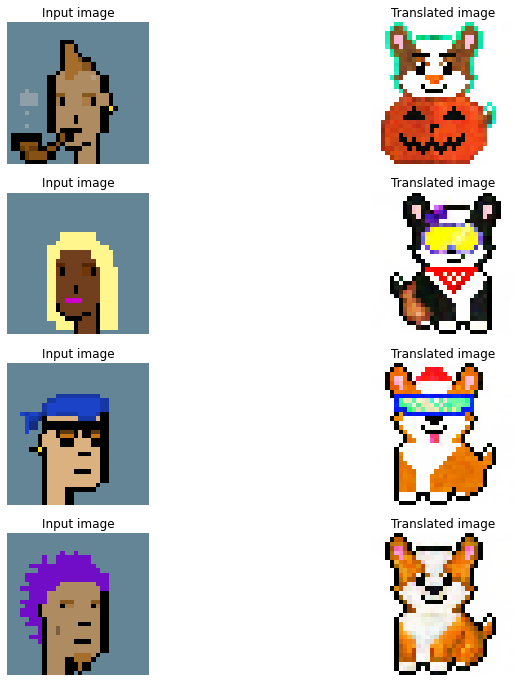

207/207 [==============================] - 73s 350ms/step - G_loss: 1.5071 - F_loss: 1.6569 - D_X_loss: 0.1388 - D_Y_loss: 0.1772
Epoch 177/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4942 - F_loss: 1.5728 - D_X_loss: 0.1520 - D_Y_loss: 0.1732

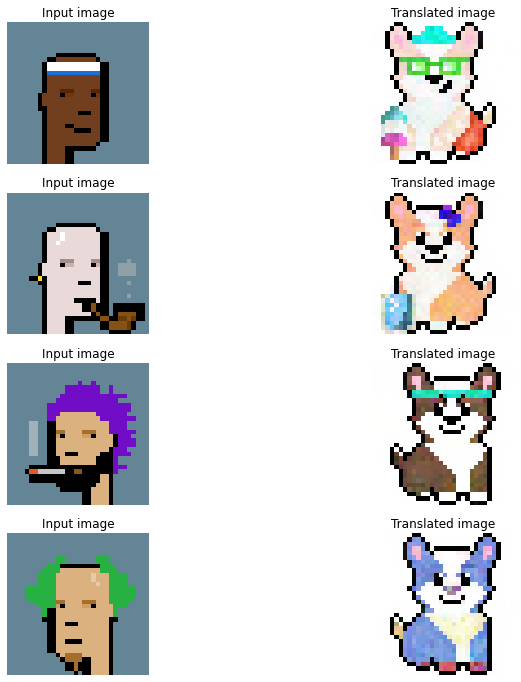

207/207 [==============================] - 73s 351ms/step - G_loss: 1.4929 - F_loss: 1.5813 - D_X_loss: 0.1513 - D_Y_loss: 0.1732
Epoch 178/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5335 - F_loss: 1.6042 - D_X_loss: 0.1447 - D_Y_loss: 0.1750

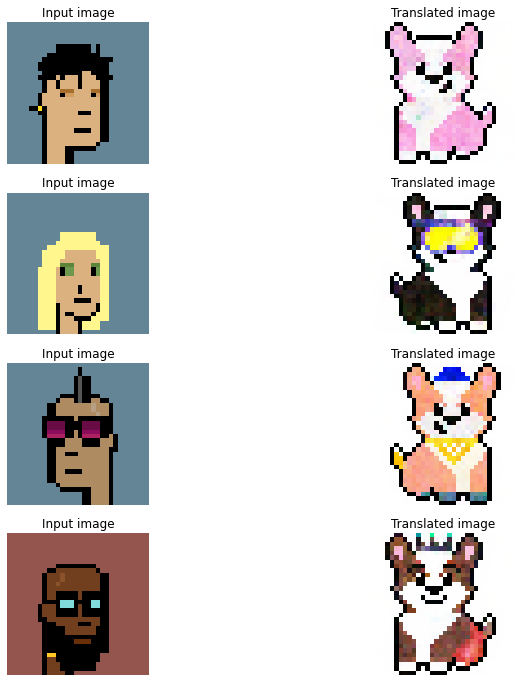

207/207 [==============================] - 76s 369ms/step - G_loss: 1.5311 - F_loss: 1.6124 - D_X_loss: 0.1441 - D_Y_loss: 0.1756
Epoch 179/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5459 - F_loss: 1.6205 - D_X_loss: 0.1519 - D_Y_loss: 0.1687

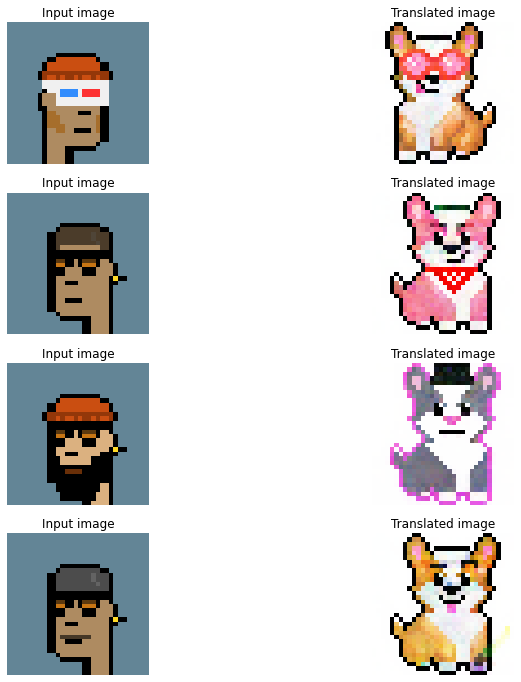

207/207 [==============================] - 75s 362ms/step - G_loss: 1.5473 - F_loss: 1.6169 - D_X_loss: 0.1530 - D_Y_loss: 0.1680
Epoch 180/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5557 - F_loss: 1.5661 - D_X_loss: 0.1525 - D_Y_loss: 0.1696

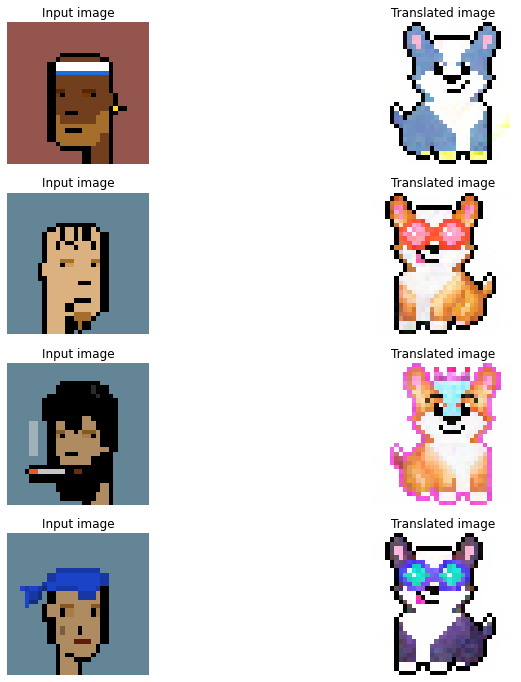

207/207 [==============================] - 75s 364ms/step - G_loss: 1.5546 - F_loss: 1.5614 - D_X_loss: 0.1538 - D_Y_loss: 0.1695
Epoch 181/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4869 - F_loss: 1.5264 - D_X_loss: 0.1537 - D_Y_loss: 0.1812

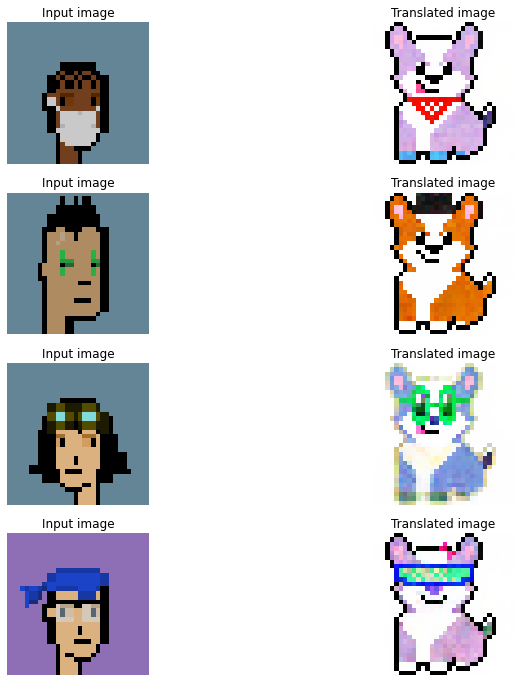

207/207 [==============================] - 75s 363ms/step - G_loss: 1.4903 - F_loss: 1.5239 - D_X_loss: 0.1532 - D_Y_loss: 0.1806
Epoch 182/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5455 - F_loss: 1.5595 - D_X_loss: 0.1518 - D_Y_loss: 0.1729

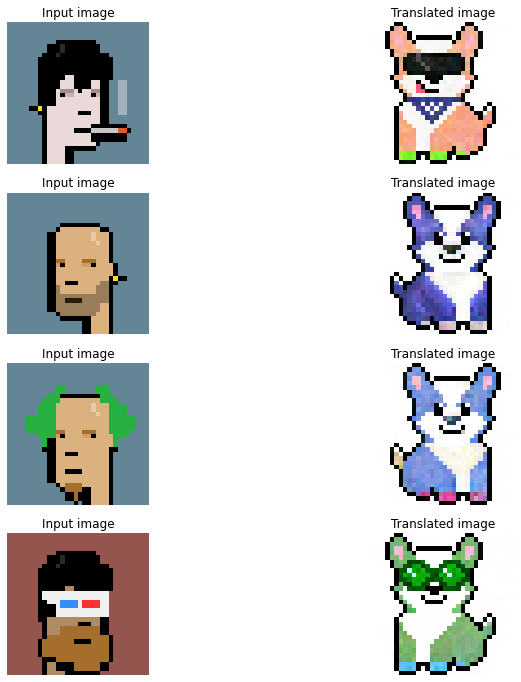

207/207 [==============================] - 71s 342ms/step - G_loss: 1.5417 - F_loss: 1.5600 - D_X_loss: 0.1517 - D_Y_loss: 0.1735
Epoch 183/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5507 - F_loss: 1.5808 - D_X_loss: 0.1521 - D_Y_loss: 0.1728

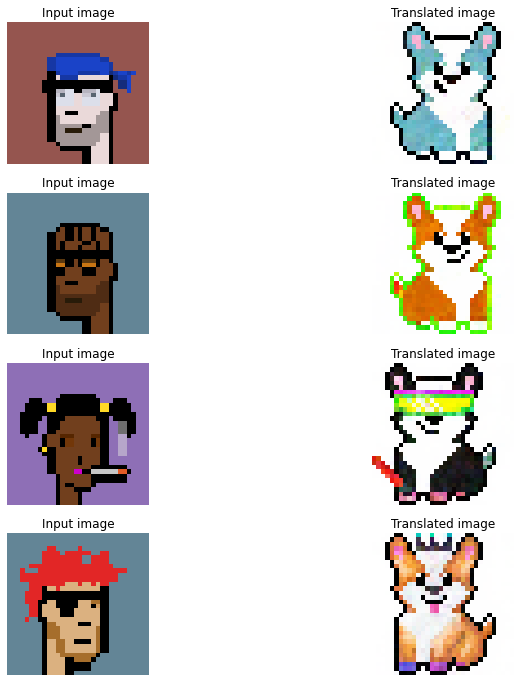

207/207 [==============================] - 70s 340ms/step - G_loss: 1.5553 - F_loss: 1.5758 - D_X_loss: 0.1528 - D_Y_loss: 0.1727
Epoch 184/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5237 - F_loss: 1.5122 - D_X_loss: 0.1581 - D_Y_loss: 0.1687

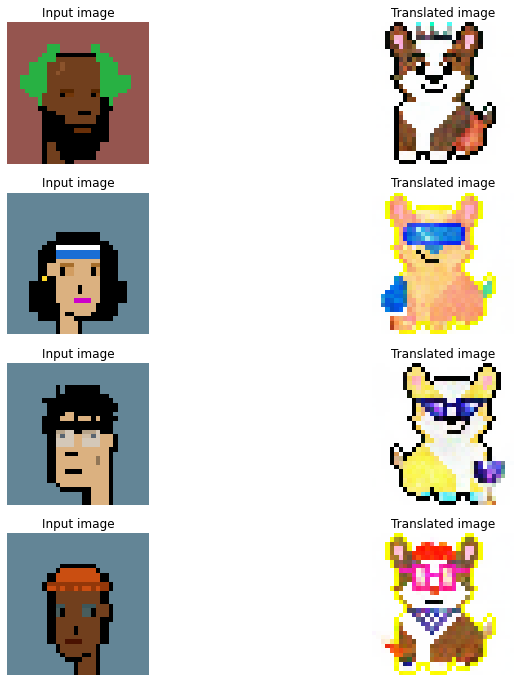

207/207 [==============================] - 71s 341ms/step - G_loss: 1.5192 - F_loss: 1.5073 - D_X_loss: 0.1592 - D_Y_loss: 0.1697
Epoch 185/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5143 - F_loss: 1.5179 - D_X_loss: 0.1476 - D_Y_loss: 0.1790

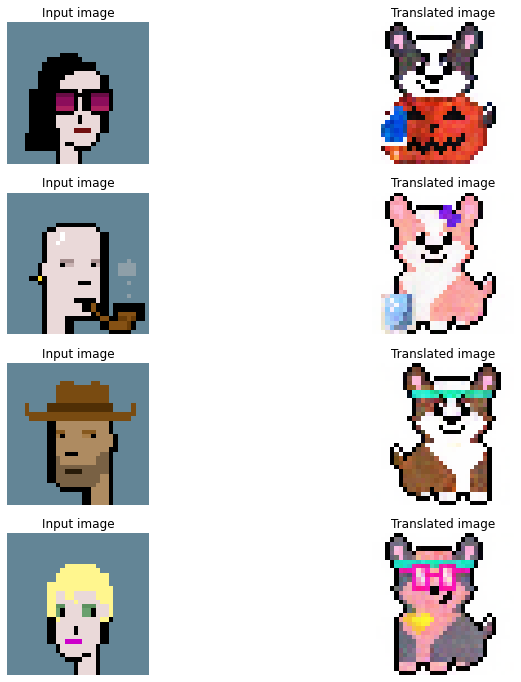

207/207 [==============================] - 71s 341ms/step - G_loss: 1.5181 - F_loss: 1.5200 - D_X_loss: 0.1472 - D_Y_loss: 0.1784
Epoch 186/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5037 - F_loss: 1.5500 - D_X_loss: 0.1501 - D_Y_loss: 0.1782

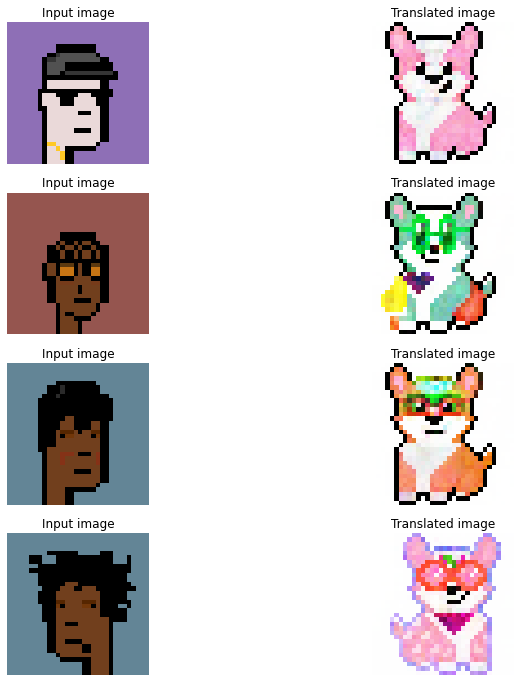

207/207 [==============================] - 71s 341ms/step - G_loss: 1.5008 - F_loss: 1.5467 - D_X_loss: 0.1507 - D_Y_loss: 0.1792
Epoch 187/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4936 - F_loss: 1.5582 - D_X_loss: 0.1449 - D_Y_loss: 0.1735

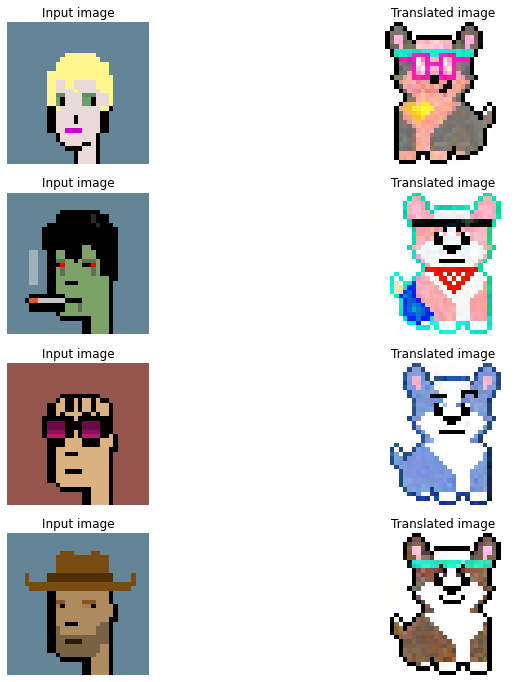

207/207 [==============================] - 71s 341ms/step - G_loss: 1.4994 - F_loss: 1.5562 - D_X_loss: 0.1446 - D_Y_loss: 0.1729
Epoch 188/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5025 - F_loss: 1.6291 - D_X_loss: 0.1474 - D_Y_loss: 0.1729

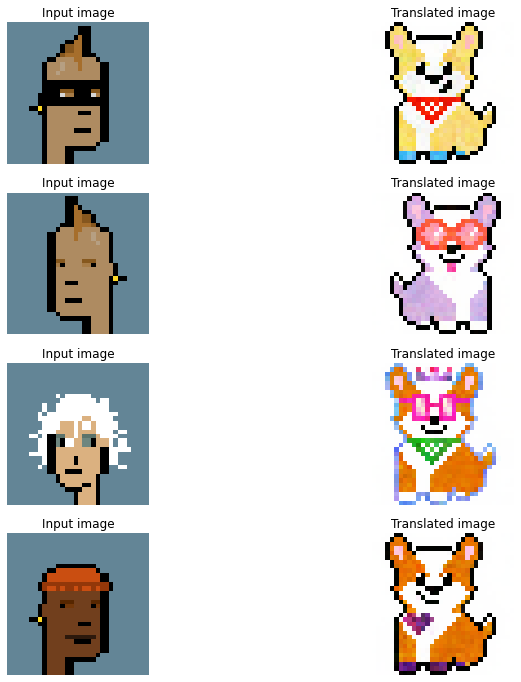

207/207 [==============================] - 70s 340ms/step - G_loss: 1.5003 - F_loss: 1.6268 - D_X_loss: 0.1479 - D_Y_loss: 0.1729
Epoch 189/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4386 - F_loss: 1.4865 - D_X_loss: 0.1537 - D_Y_loss: 0.1758

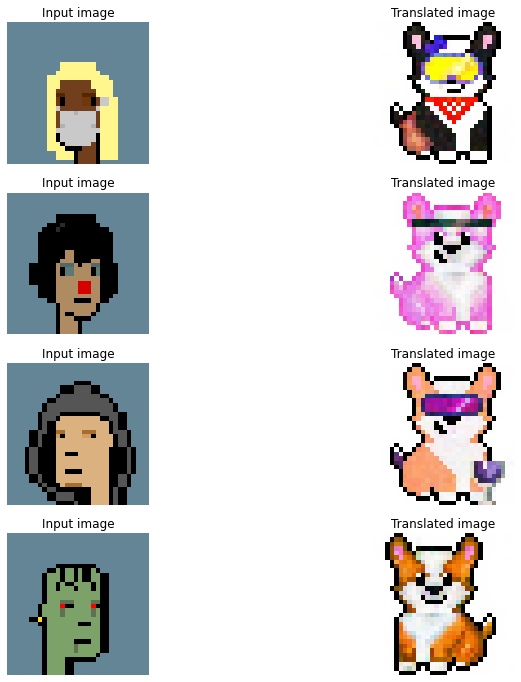

207/207 [==============================] - 73s 351ms/step - G_loss: 1.4370 - F_loss: 1.4838 - D_X_loss: 0.1534 - D_Y_loss: 0.1762
Epoch 190/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4600 - F_loss: 1.5741 - D_X_loss: 0.1446 - D_Y_loss: 0.1775

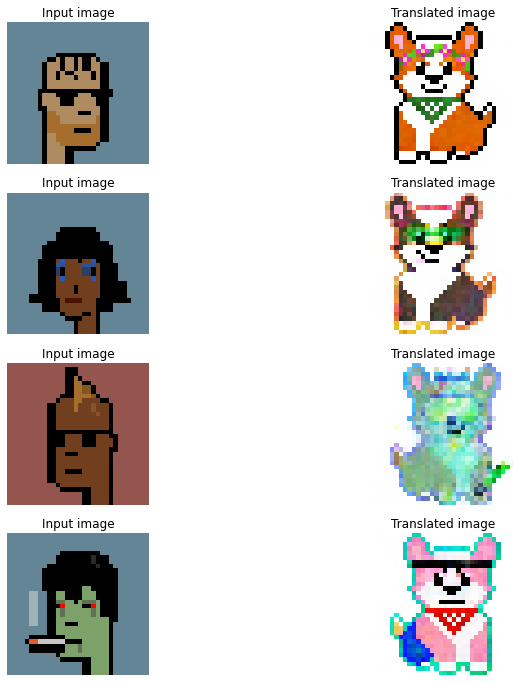

207/207 [==============================] - 74s 360ms/step - G_loss: 1.4659 - F_loss: 1.5731 - D_X_loss: 0.1462 - D_Y_loss: 0.1772
Epoch 191/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4385 - F_loss: 1.4764 - D_X_loss: 0.1567 - D_Y_loss: 0.1776

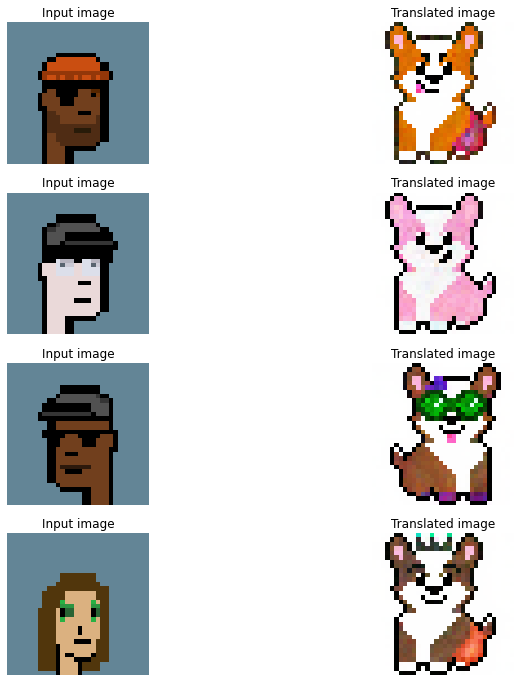

207/207 [==============================] - 74s 359ms/step - G_loss: 1.4357 - F_loss: 1.4732 - D_X_loss: 0.1567 - D_Y_loss: 0.1777
Epoch 192/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4155 - F_loss: 1.5096 - D_X_loss: 0.1656 - D_Y_loss: 0.1776

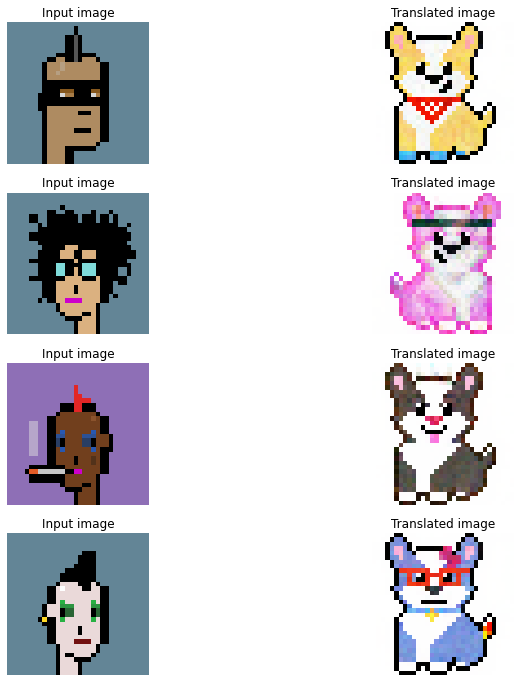

207/207 [==============================] - 75s 362ms/step - G_loss: 1.4122 - F_loss: 1.5047 - D_X_loss: 0.1667 - D_Y_loss: 0.1782
Epoch 193/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4027 - F_loss: 1.4988 - D_X_loss: 0.1517 - D_Y_loss: 0.1799

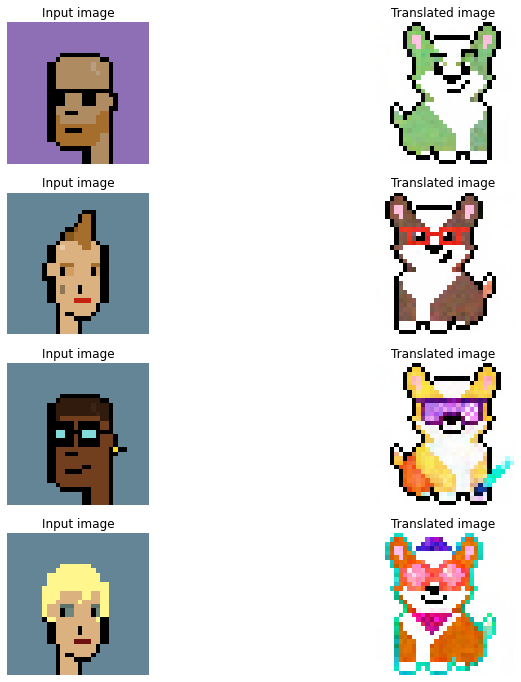

207/207 [==============================] - 74s 360ms/step - G_loss: 1.4098 - F_loss: 1.4951 - D_X_loss: 0.1514 - D_Y_loss: 0.1794
Epoch 194/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4171 - F_loss: 1.4524 - D_X_loss: 0.1502 - D_Y_loss: 0.1776

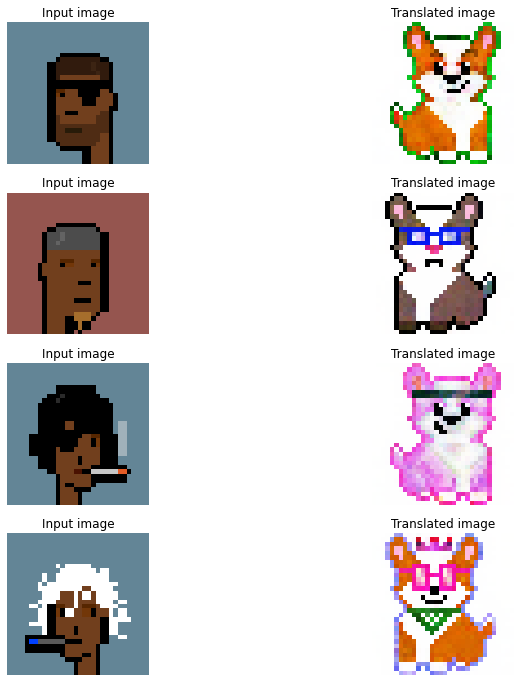

207/207 [==============================] - 75s 361ms/step - G_loss: 1.4143 - F_loss: 1.4616 - D_X_loss: 0.1499 - D_Y_loss: 0.1781
Epoch 195/200
207/207 [==============================] - ETA: 0s - G_loss: 1.3594 - F_loss: 1.4959 - D_X_loss: 0.1534 - D_Y_loss: 0.1862

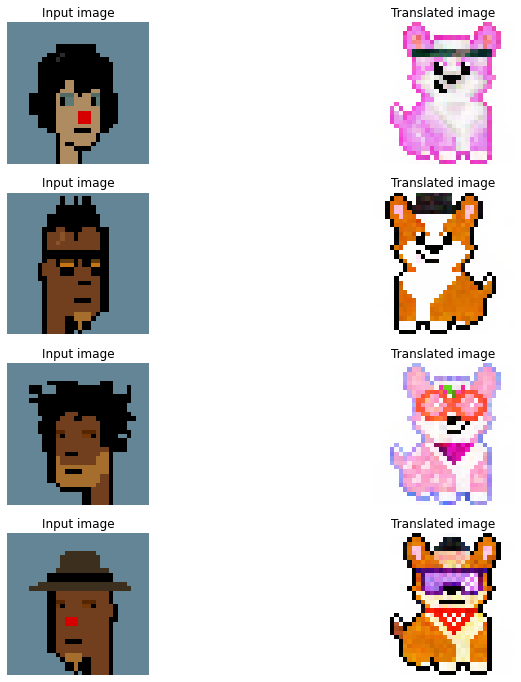

207/207 [==============================] - 75s 360ms/step - G_loss: 1.3570 - F_loss: 1.4978 - D_X_loss: 0.1531 - D_Y_loss: 0.1863
Epoch 196/200
207/207 [==============================] - ETA: 0s - G_loss: 1.3729 - F_loss: 1.6097 - D_X_loss: 0.1464 - D_Y_loss: 0.1764

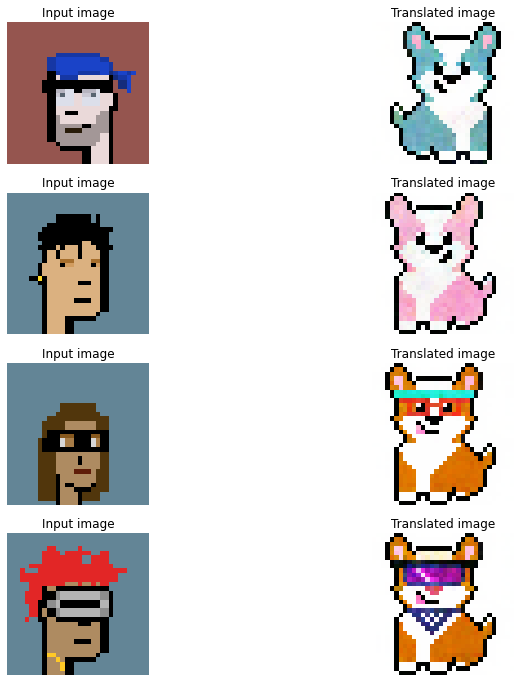

207/207 [==============================] - 75s 361ms/step - G_loss: 1.3790 - F_loss: 1.6064 - D_X_loss: 0.1474 - D_Y_loss: 0.1766
Epoch 197/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4190 - F_loss: 1.5291 - D_X_loss: 0.1573 - D_Y_loss: 0.1792

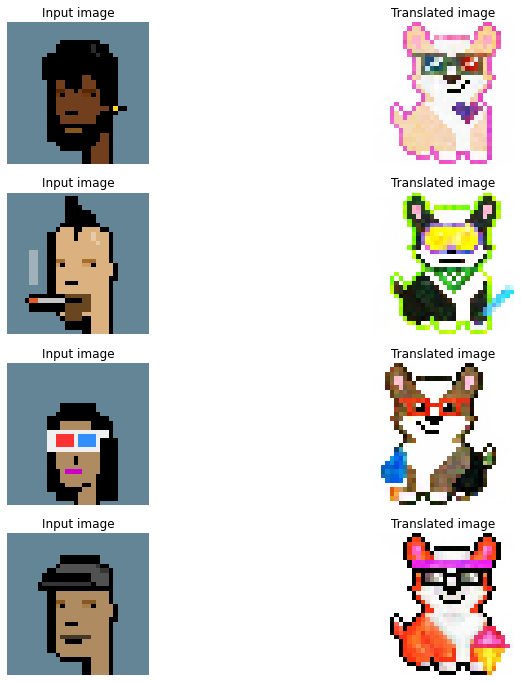

207/207 [==============================] - 75s 360ms/step - G_loss: 1.4168 - F_loss: 1.5247 - D_X_loss: 0.1586 - D_Y_loss: 0.1793
Epoch 198/200
207/207 [==============================] - ETA: 0s - G_loss: 1.3877 - F_loss: 1.4817 - D_X_loss: 0.1541 - D_Y_loss: 0.1769

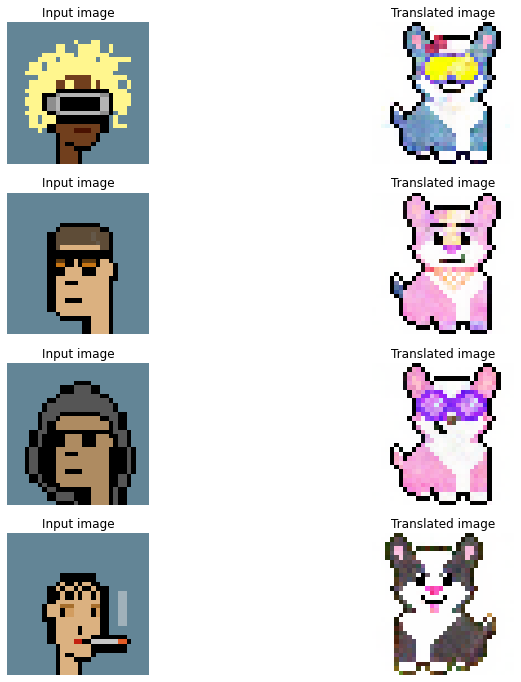

207/207 [==============================] - 75s 361ms/step - G_loss: 1.3953 - F_loss: 1.4815 - D_X_loss: 0.1550 - D_Y_loss: 0.1771
Epoch 199/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4594 - F_loss: 1.4462 - D_X_loss: 0.1572 - D_Y_loss: 0.1794

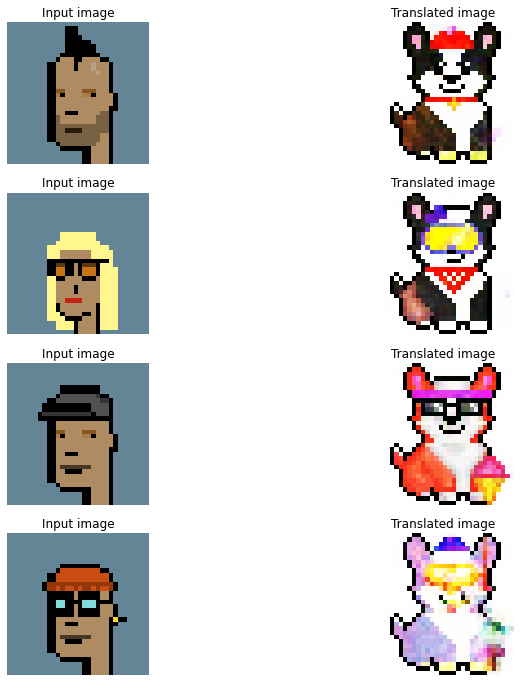

207/207 [==============================] - 75s 361ms/step - G_loss: 1.4564 - F_loss: 1.4490 - D_X_loss: 0.1573 - D_Y_loss: 0.1795
Epoch 200/200
207/207 [==============================] - ETA: 0s - G_loss: 1.4060 - F_loss: 1.4529 - D_X_loss: 0.1513 - D_Y_loss: 0.1795

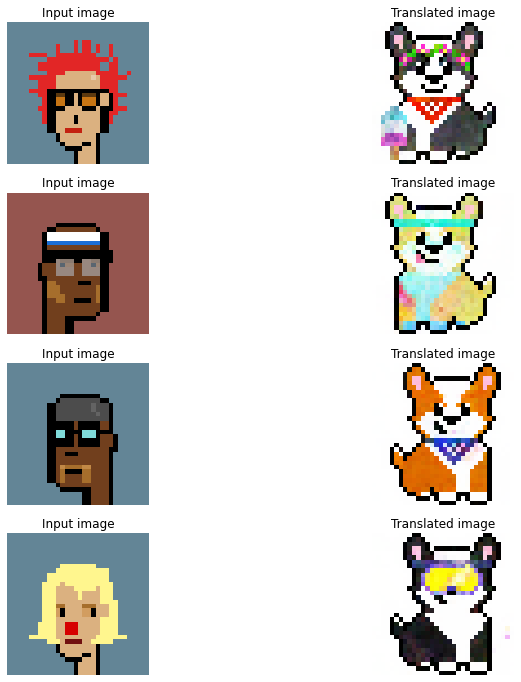

207/207 [==============================] - 75s 361ms/step - G_loss: 1.4032 - F_loss: 1.4497 - D_X_loss: 0.1516 - D_Y_loss: 0.1795


In [19]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_ds2, train_ds)),
    epochs=200,
    callbacks=[plotter],
)